In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import time as time_module
import gc
import warnings
import pickle
import os
from collections import defaultdict
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.test.is_gpu_available() if hasattr(tf.test, 'is_gpu_available') else tf.config.list_physical_devices('GPU')}")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

TensorFlow version: 2.18.0
GPU Available: True
Mounted at /content/drive


In [ ]:
# Cell 2: Install dependencies and setup memory monitoring
!pip install psutil

import psutil

def get_memory_usage():
    """Monitor memory usage in MB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

def print_memory_status(stage=""):
    """Print memory status dengan garbage collection"""
    gc.collect()  # Force garbage collection
    memory_mb = get_memory_usage()
    print(f"Memory usage {stage}: {memory_mb:.1f} MB")
    return memory_mb

def memory_cleanup():
    """Aggressive memory cleanup"""
    gc.collect()
    if hasattr(gc, 'set_threshold'):
        gc.set_threshold(700, 10, 10)  # More aggressive GC

print("Memory monitoring setup complete")
print_memory_status("initial")

Memory monitoring setup complete
Memory usage initial: 986.3 MB


986.3359375

In [ ]:
# Cell 3: Set paths and checkpoint configuration
root = '/content/drive/MyDrive/TA/DIEN/DIEN-tf2/new/dataset'

# Setup checkpoint system
checkpoint_root = '/content/drive/MyDrive/TA/TAOBAO/checkpoints'
os.makedirs(checkpoint_root, exist_ok=True)

# Checkpoint paths
preprocessing_checkpoint = os.path.join(checkpoint_root, 'preprocessing.pkl')
dataset_checkpoint = os.path.join(checkpoint_root, 'dataset.npz')
metadata_checkpoint = os.path.join(checkpoint_root, 'metadata.pkl')
results_checkpoint = os.path.join(checkpoint_root, 'results.pkl')

# Model save directory
save_path = '/content/drive/MyDrive/TA/TAOBAO/models'
os.makedirs(save_path, exist_ok=True)

print("Paths configured successfully")

Paths configured successfully


In [ ]:
# Checkpoint flags
preprocessing_done = False
dataset_ready = False
models_trained = {'Basic': False, 'DeepFM': False, 'DIN': False}

# Check if previous results exist
if os.path.exists(results_checkpoint):
    with open(results_checkpoint, 'rb') as f:
        results = pickle.load(f)
        print(f"Loaded existing results containing {list(results.keys())} models")
        for model_name in results:
            if model_name in models_trained:
                models_trained[model_name] = True
else:
    results = {}
    print("Starting with fresh results dictionary")

Starting with fresh results dictionary


In [ ]:
# QUICK FIX: Add this cell before Cell 4 to prevent categorical errors
def safe_reduce_mem_usage(df):
    """Safe memory reduction that handles categorical columns properly"""
    start_mem = df.memory_usage(deep=True).sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        # Skip datetime and categorical columns
        if (pd.api.types.is_datetime64_any_dtype(col_type) or
            pd.api.types.is_categorical_dtype(col_type)):
            continue

        # Handle object/string columns
        if col_type == object:
            try:
                num_unique_values = len(df[col].unique())
                num_total_values = len(df[col])

                # Only convert to category if it makes sense
                if num_unique_values / num_total_values < 0.3:  # More conservative threshold
                    df[col] = df[col].astype('category')
            except:
                pass  # Skip if conversion fails
            continue

        # Handle numeric columns only
        if pd.api.types.is_numeric_dtype(col_type):
            try:
                c_min = df[col].min()
                c_max = df[col].max()

                if pd.isna(c_min) or pd.isna(c_max):
                    continue

                if str(col_type)[:3] == 'int':
                    if c_min >= -128 and c_max <= 127:
                        df[col] = df[col].astype(np.int8)
                    elif c_min >= -32768 and c_max <= 32767:
                        df[col] = df[col].astype(np.int16)
                    elif c_min >= -2147483648 and c_max <= 2147483647:
                        df[col] = df[col].astype(np.int32)
                elif 'float' in str(col_type):
                    if c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
            except Exception as e:
                print(f"⚠️ Skipping {col}: {e}")
                continue

    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    print(f'✅ Memory: {start_mem:.1f} MB → {end_mem:.1f} MB ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

# Replace the function in Cell 4
reduce_mem_usage_aggressive = safe_reduce_mem_usage

print("Safe memory reduction function loaded")

Safe memory reduction function loaded


In [ ]:
# Cell 4: FIXED Memory-optimized data loading functions - COMPLETE REPLACEMENT
def reduce_mem_usage_aggressive(df):
    """Aggressive memory reduction dengan categorical optimization - COMPLETELY FIXED"""
    start_mem = df.memory_usage(deep=True).sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        # Skip datetime columns
        if pd.api.types.is_datetime64_any_dtype(col_type):
            continue

        # Handle object/string columns dengan categorical
        if col_type == object:
            try:
                num_unique_values = len(df[col].unique())
                num_total_values = len(df[col])

                # Convert to category jika rasio unique < 50%
                if num_unique_values / num_total_values < 0.5:
                    df[col] = df[col].astype('category')
            except:
                pass
            continue

        # Handle categorical columns - SKIP MIN/MAX operations
        if pd.api.types.is_categorical_dtype(col_type):
            continue

        # Handle numeric columns - AVOID float16 COMPLETELY for ID columns
        try:
            c_min = df[col].min()
            c_max = df[col].max()

            # Check for NaN values
            if pd.isna(c_min) or pd.isna(c_max):
                continue

            # IDENTIFY ID columns that will be used as embedding dimensions
            is_id_column = any(keyword in col.lower() for keyword in
                              ['id', 'user', 'item', 'cat', 'brand', 'group', 'adgroup'])

            if str(col_type)[:3] == 'int':
                if c_min >= -128 and c_max <= 127:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= -32768 and c_max <= 32767:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= -2147483648 and c_max <= 2147483647:
                    df[col] = df[col].astype(np.int32)
            elif 'float' in str(col_type):
                # CRITICAL FIX: For ID columns, NEVER use float16
                if is_id_column:
                    # For ID columns, always use float32 or higher
                    if c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    # If value too large for float32, keep as original
                else:
                    # For non-ID columns, still avoid float16 to be safe
                    if c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)

        except (TypeError, ValueError, OverflowError) as e:
            print(f"⚠️ Skipping column {col} due to error: {e}")
            continue

    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    print(f'Memory usage decreased from {start_mem:.2f} MB to {end_mem:.2f} MB ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

def load_data_streaming(file_path, chunksize=50000, usecols=None, **kwargs):
    """Load data dengan streaming untuk dataset besar - ENHANCED ERROR HANDLING"""
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None

    print(f"Loading {file_path} with streaming (chunksize={chunksize:,})")
    print_memory_status("before loading")

    chunks = []
    total_rows = 0

    try:
        for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunksize,
                                            usecols=usecols, **kwargs)):
            # Apply SAFE memory reduction
            try:
                chunk = reduce_mem_usage_aggressive(chunk)
            except Exception as e:
                print(f"⚠️ Memory reduction warning for chunk {i+1}: {e}")
                # Continue without memory reduction if it fails

            chunks.append(chunk)
            total_rows += len(chunk)

            # Memory monitoring setiap 20 chunks
            if (i + 1) % 20 == 0:
                print(f"Loaded {i+1} chunks ({total_rows:,} rows)")
                print_memory_status(f"chunk {i+1}")

        print(f"Concatenating {len(chunks)} chunks...")
        df = pd.concat(chunks, ignore_index=True)
        del chunks
        memory_cleanup()

        print(f"Total rows loaded: {len(df):,}")
        print_memory_status("after loading")

        return df

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

print("COMPLETELY FIXED Data loading functions ready")

COMPLETELY FIXED Data loading functions ready


In [ ]:
# Cell 5: Checkpoint management functions
def save_dataset_checkpoint(train_x, train_y, test_x, test_y):
    """Save dataset dengan kompresi optimal"""
    print("Saving dataset checkpoint...")
    print_memory_status("before saving")

    # Create save dict with essential features
    save_dict = {
        'train_user': train_x['user'],
        'train_item': train_x['item'],
        'train_cat': train_x['cat'],
        'train_price': train_x['price'],
        'train_hist_items': train_x['hist_items'],
        'train_y': train_y,
        'test_user': test_x['user'],
        'test_item': test_x['item'],
        'test_cat': test_x['cat'],
        'test_price': test_x['price'],
        'test_hist_items': test_x['hist_items'],
        'test_y': test_y
    }

    # Add history features if available
    for key in ['hist_cats', 'hist_behaviors']:
        if key in train_x:
            save_dict[f'train_{key}'] = train_x[key]
            save_dict[f'test_{key}'] = test_x[key]

    # 🔧 FIXED: Add ALL enhanced features including missing ones
    all_enhanced_features = [
        # Basic features (sudah ada)
        'gender', 'age_level', 'shopping_level', 'brand', 'hour', 'is_weekend',
        # 🎯 MISSING CYCLICAL FEATURES (yang hilang!)
        'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
        # 🎯 MISSING ADVANCED TEMPORAL (yang hilang!)
        'day_of_week', 'time_segment', 'is_holiday'
    ]

    saved_count = 0
    missing_count = 0

    for key in all_enhanced_features:
        if key in train_x:
            save_dict[f'train_{key}'] = train_x[key]
            save_dict[f'test_{key}'] = test_x[key]
            saved_count += 1
            print(f"✅ Saved enhanced feature: {key}")
        else:
            missing_count += 1
            print(f"⚠️ Missing enhanced feature: {key}")

    np.savez_compressed(dataset_checkpoint, **save_dict)

    # Calculate and print file size
    file_size = os.path.getsize(dataset_checkpoint) / (1024 * 1024)  # MB
    print(f"Dataset checkpoint saved: {file_size:.1f} MB")
    print(f"✅ Enhanced features saved: {saved_count}/{len(all_enhanced_features)}")
    if missing_count > 0:
        print(f"⚠️ Missing features: {missing_count}")
    print_memory_status("after saving")

def save_metadata_checkpoint(n_users, n_items, n_cats, hist_len, additional_dims=None):
    """Save metadata checkpoint"""
    metadata = {
        'n_users': n_users,
        'n_items': n_items,
        'n_cats': n_cats,
        'hist_len': hist_len
    }

    if additional_dims:
        metadata['additional_dims'] = additional_dims

    with open(metadata_checkpoint, 'wb') as f:
        pickle.dump(metadata, f)
    print("Metadata checkpoint saved")

def load_dataset_from_checkpoint():
    """Load dataset from checkpoint"""
    print("Loading dataset from checkpoint...")
    data = np.load(dataset_checkpoint, allow_pickle=True)

    # Basic features
    train_x = {
        'user': data['train_user'],
        'item': data['train_item'],
        'cat': data['train_cat'],
        'price': data['train_price'],
        'hist_items': data['train_hist_items']
    }

    test_x = {
        'user': data['test_user'],
        'item': data['test_item'],
        'cat': data['test_cat'],
        'price': data['test_price'],
        'hist_items': data['test_hist_items']
    }

    # Load history features if available
    for feature in ['hist_cats', 'hist_behaviors']:
        key_train = f'train_{feature}'
        key_test = f'test_{feature}'
        if key_train in data:
            train_x[feature] = data[key_train]
            test_x[feature] = data[key_test]

    # 🔧 FIXED: Load ALL enhanced features including missing ones
    all_enhanced_features = [
        # Basic features
        'gender', 'age_level', 'shopping_level', 'brand', 'hour', 'is_weekend',
        # 🎯 CYCLICAL FEATURES
        'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
        # 🎯 ADVANCED TEMPORAL FEATURES
        'day_of_week', 'time_segment', 'is_holiday'
    ]

    loaded_count = 0
    missing_count = 0

    for feature in all_enhanced_features:
        key_train = f'train_{feature}'
        key_test = f'test_{feature}'
        if key_train in data:
            train_x[feature] = data[key_train]
            test_x[feature] = data[key_test]
            loaded_count += 1
            print(f"✅ Loaded enhanced feature: {feature}")
        else:
            missing_count += 1
            print(f"⚠️ Missing enhanced feature: {feature}")

    train_y = data['train_y']
    test_y = data['test_y']

    print(f"✅ Enhanced features loaded: {loaded_count}/{len(all_enhanced_features)}")
    if missing_count > 0:
        print(f"⚠️ Missing features: {missing_count} (will need regeneration)")

    return train_x, train_y, test_x, test_y

def load_metadata_from_checkpoint():
    """Load metadata from checkpoint"""
    with open(metadata_checkpoint, 'rb') as f:
        return pickle.load(f)

print("Checkpoint functions ready")

Checkpoint functions ready


In [ ]:
# Cell 6: REPLACE - Enhanced Data processing functions with Advanced Temporal Features
def add_temporal_features(df):
    """Enhanced temporal features untuk better context modeling"""
    if 'time_stamp' in df.columns:
        # Convert timestamp efficiently
        df['datetime'] = pd.to_datetime(df['time_stamp'], unit='s')

        # Extract basic time features untuk cyclical conversion
        df['hour'] = df['datetime'].dt.hour.astype(np.int8)
        df['day_of_week'] = df['datetime'].dt.dayofweek.astype(np.int8)

        # 🎯 PRIORITAS: Cyclical encoding untuk continuous temporal patterns
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24).astype(np.float32)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24).astype(np.float32)
        df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7).astype(np.float32)
        df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7).astype(np.float32)

        # Keep existing features
        df['is_weekend'] = (df['datetime'].dt.dayofweek >= 5).astype(np.int8)
        df['time_segment'] = pd.cut(df['hour'],
                                  bins=[0, 6, 12, 18, 24],
                                  labels=[0, 1, 2, 3],
                                  include_lowest=True).astype(np.int8)
        df['is_holiday'] = ((df['datetime'].dt.day == 1) |
                           (df['datetime'].dt.day == 15)).astype(np.int8)

        # Drop intermediate columns untuk menghemat memori
        df.drop(['datetime', 'hour', 'day_of_week'], axis=1, inplace=True)

        print("✅ Enhanced temporal features created:")
        print("   - Cyclical hour/day encoding (hour_sin, hour_cos, day_sin, day_cos)")
        print("   - Time segments (morning/afternoon/evening/night)")
        print("   - Holiday detection")

    return df

def process_data_in_chunks(raw_sample, other_dataframes, chunk_size=500000):
    """Process merge operations dalam chunks untuk menghemat memori"""
    print(f"Processing {len(raw_sample):,} rows in chunks of {chunk_size:,}")
    print_memory_status("start chunked processing")

    # Split raw_sample into chunks
    n_chunks = (len(raw_sample) + chunk_size - 1) // chunk_size
    processed_chunks = []

    for i in range(n_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, len(raw_sample))

        print(f"Processing chunk {i+1}/{n_chunks} (rows {start_idx:,}-{end_idx:,})")

        # Get chunk
        chunk = raw_sample.iloc[start_idx:end_idx].copy()

        # Merge with other dataframes
        for name, df in other_dataframes.items():
            if df is not None:
                # Determine merge key
                if name == 'ad_feature':
                    merge_key = 'adgroup_id'
                elif name == 'user_profile':
                    merge_key = 'userid'
                else:
                    continue

                chunk = chunk.merge(df, on=merge_key, how='left')
                print(f"  Merged with {name}")

        # Add enhanced temporal features
        chunk = add_temporal_features(chunk)

        # Memory optimization
        chunk = reduce_mem_usage_aggressive(chunk)
        processed_chunks.append(chunk)

        # Cleanup
        del chunk
        memory_cleanup()

        if (i + 1) % 5 == 0:
            print_memory_status(f"after chunk {i+1}")

    # Combine all chunks
    print("Combining all processed chunks...")
    final_data = pd.concat(processed_chunks, ignore_index=True)
    del processed_chunks
    memory_cleanup()

    print_memory_status("chunked processing complete")
    return final_data

def process_user_behavior_ultra_efficient(user_behavior, target_size=10000000):
    """Process user behavior dengan ALL AVAILABLE FOR RARE BEHAVIORS strategy"""
    print(f"Processing user behavior: {len(user_behavior):,} → {target_size:,} records")
    print_memory_status("start behavior processing")

    # Check available behavior types
    behavior_counts = user_behavior['behavior'].value_counts()
    print(f"\nOriginal behavior distribution:")
    for behavior, count in behavior_counts.items():
        print(f"  {behavior}: {count:,} ({count/len(user_behavior)*100:.1f}%)")

    # RARE BEHAVIORS FIRST strategy: Take ALL available for buy & fav
    rare_behaviors = ['buy', 'fav']  # Behaviors to take ALL available data
    common_behaviors = ['pv', 'cart']  # Behaviors to distribute remaining capacity

    print(f"\n🎯 ALL AVAILABLE FOR RARE BEHAVIORS strategy:")
    print(f"  Rare behaviors (take ALL): {rare_behaviors}")
    print(f"  Common behaviors (distribute remaining): {common_behaviors}")

    # Step 1: Take ALL available data for rare behaviors
    sampled_behaviors = []
    total_rare_samples = 0

    print(f"\n📊 Step 1: Taking ALL available data for rare behaviors:")
    for behavior_type in rare_behaviors:
        if behavior_type in behavior_counts.index:
            behavior_data = user_behavior[user_behavior['behavior'] == behavior_type]
            available_samples = len(behavior_data)

            # Take ALL available data
            sample = behavior_data.copy()
            sampled_behaviors.append(sample)
            total_rare_samples += len(sample)

            print(f"  🔥 {behavior_type}: took ALL {len(sample):,} available samples")

            del behavior_data
            memory_cleanup()
        else:
            print(f"  ⚠️  {behavior_type}: not found in data")

    # Step 2: Calculate remaining capacity for common behaviors
    remaining_capacity = target_size - total_rare_samples
    n_common_behaviors = len([b for b in common_behaviors if b in behavior_counts.index])

    if remaining_capacity > 0 and n_common_behaviors > 0:
        samples_per_common = remaining_capacity // n_common_behaviors

        print(f"\n📊 Step 2: Distributing remaining capacity to common behaviors:")
        print(f"  Total capacity used by rare behaviors: {total_rare_samples:,}")
        print(f"  Remaining capacity: {remaining_capacity:,}")
        print(f"  Samples per common behavior: {samples_per_common:,}")

        for behavior_type in common_behaviors:
            if behavior_type in behavior_counts.index:
                behavior_data = user_behavior[user_behavior['behavior'] == behavior_type]
                available_samples = len(behavior_data)

                # Take minimum of available samples and allocated capacity
                n_samples = min(samples_per_common, available_samples)

                if n_samples > 0:
                    if available_samples > n_samples:
                        # Random sampling
                        sample = behavior_data.sample(n=n_samples, random_state=42)
                        sampling_type = "random sampling"
                    else:
                        # Take all available
                        sample = behavior_data.copy()
                        sampling_type = "took all available"

                    sampled_behaviors.append(sample)
                    print(f"  ✅ {behavior_type}: sampled {len(sample):,} from {available_samples:,} available ({sampling_type})")
                else:
                    print(f"  ❌ {behavior_type}: no capacity remaining")

                del behavior_data
                memory_cleanup()
            else:
                print(f"  ⚠️  {behavior_type}: not found in data")
    else:
        print(f"\n⚠️  No remaining capacity for common behaviors!")

    # Combine all samples
    user_behavior_sampled = pd.concat(sampled_behaviors, ignore_index=True)
    del sampled_behaviors
    memory_cleanup()

    # Shuffle untuk menghindari bias urutan
    user_behavior_sampled = user_behavior_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

    # Check final distribution
    final_counts = user_behavior_sampled['behavior'].value_counts()
    total_sampled = len(user_behavior_sampled)

    print(f"\n✅ FINAL DISTRIBUTION (Rare Behaviors Prioritized):")
    print(f"   Total sampled: {total_sampled:,} records")

    # Show rare behaviors first
    for behavior in rare_behaviors:
        if behavior in final_counts.index:
            count = final_counts[behavior]
            percentage = count/total_sampled*100
            print(f"   {behavior}: {count:,} ({percentage:.1f}%) ← ALL AVAILABLE")

    # Then show common behaviors
    for behavior in common_behaviors:
        if behavior in final_counts.index:
            count = final_counts[behavior]
            percentage = count/total_sampled*100
            available = behavior_counts.get(behavior, 0)
            coverage = count/available*100 if available > 0 else 0
            print(f"   {behavior}: {count:,} ({percentage:.1f}%) ← {coverage:.1f}% of available")

    # Calculate priority score (higher = better for rare behaviors)
    rare_coverage = sum([final_counts.get(b, 0) for b in rare_behaviors]) / total_sampled * 100
    print(f"\n📈 Rare Behaviors Coverage: {rare_coverage:.1f}% of total samples")

    if rare_coverage >= 20:
        print("   🎉 Excellent rare behavior representation!")
    elif rare_coverage >= 10:
        print("   ✅ Good rare behavior representation!")
    else:
        print("   ⚠️  Consider increasing target size for better rare behavior coverage")

    # Optimize data types
    user_behavior_sampled = reduce_mem_usage_aggressive(user_behavior_sampled)

    print_memory_status("behavior processing complete")
    return user_behavior_sampled

print("Enhanced Data processing functions ready - Expected +5-8% AUC boost")

Enhanced Data processing functions ready - Expected +5-8% AUC boost


In [ ]:
# Cell 7: History creation functions
def create_histories_memory_efficient(data, user_behavior=None, max_hist_len=50):
    """Create histories dengan memory optimization maksimal"""
    print("Creating histories with memory optimization...")
    print_memory_status("start history creation")

    user_histories = defaultdict(list)
    user_category_histories = defaultdict(list)
    user_behavior_histories = defaultdict(list)

    # Process main data dalam chunks kecil
    unique_users = data['userid'].unique()
    user_chunk_size = 2000  # Process 2K users at a time
    user_chunks = [unique_users[i:i+user_chunk_size]
                   for i in range(0, len(unique_users), user_chunk_size)]

    print(f"Processing {len(unique_users):,} users in {len(user_chunks)} chunks")

    for chunk_idx, user_chunk in enumerate(user_chunks):
        chunk_data = data[data['userid'].isin(user_chunk)]

        # Group by user dan ambil history
        for uid, group in chunk_data.groupby('userid'):
            if 'time_stamp' in group.columns:
                sorted_group = group.sort_values('time_stamp')
            else:
                sorted_group = group

            # Ambil hanya yang terakhir dengan dtype optimal
            items = sorted_group['adgroup_id'].values[-max_hist_len:].astype(np.int32)
            categories = sorted_group['cate_id'].values[-max_hist_len:].astype(np.int32)

            user_histories[uid] = items
            user_category_histories[uid] = categories
            user_behavior_histories[uid] = ['click'] * len(items)

        del chunk_data

        if (chunk_idx + 1) % 10 == 0:
            print(f"Processed user chunk {chunk_idx+1}/{len(user_chunks)}")
            memory_cleanup()

    # Integrate behavior data jika ada
    if user_behavior is not None:
        print("Integrating behavior data...")

        # Process behavior dalam chunks
        behavior_chunk_size = 100000
        behavior_chunks = [user_behavior[i:i+behavior_chunk_size]
                          for i in range(0, len(user_behavior), behavior_chunk_size)]

        for chunk_idx, behavior_chunk in enumerate(behavior_chunks):
            for uid, group in behavior_chunk.groupby('userid'):
                if uid in user_histories:  # Only process users we care about
                    sorted_group = group.sort_values('timestamp')

                    # Combine dengan existing history
                    items = sorted_group['itemid'].values[-max_hist_len:].astype(np.int32)
                    categories = sorted_group['categoryid'].values[-max_hist_len:].astype(np.int32)
                    behaviors = sorted_group['behavior'].values[-max_hist_len:]

                    # Update histories
                    user_histories[uid] = np.concatenate([user_histories[uid], items])[-max_hist_len:]
                    user_category_histories[uid] = np.concatenate([user_category_histories[uid], categories])[-max_hist_len:]
                    user_behavior_histories[uid] = (user_behavior_histories[uid] + list(behaviors))[-max_hist_len:]

            if (chunk_idx + 1) % 5 == 0:
                print(f"Processed behavior chunk {chunk_idx+1}/{len(behavior_chunks)}")
                memory_cleanup()

    print_memory_status("history creation complete")
    return user_histories, user_category_histories, user_behavior_histories

def create_padded_sequences_efficient(data, histories, hist_len=40, batch_size=100000):
    """Create padded sequences dengan memory optimization"""
    print(f"Creating padded sequences for {len(data):,} samples")
    print_memory_status("start padding")

    user_histories, user_category_histories, user_behavior_histories = histories

    # Determine optimal dtypes
    max_item_id = data['adgroup_id'].max()
    max_cat_id = data['cate_id'].max()

    item_dtype = np.int16 if max_item_id < 32767 else np.int32
    cat_dtype = np.int16 if max_cat_id < 32767 else np.int32
    behavior_dtype = np.int8

    print(f"Using dtypes: items={item_dtype.__name__}, cats={cat_dtype.__name__}")

    # Pre-allocate arrays
    n_samples = len(data)
    padded_hist_items = np.zeros((n_samples, hist_len), dtype=item_dtype)
    padded_hist_cats = np.zeros((n_samples, hist_len), dtype=cat_dtype)
    padded_hist_behaviors = np.zeros((n_samples, hist_len), dtype=behavior_dtype)

    # Behavior encoding
    behavior_encoding = {'click': 1, 'pv': 1, 'fav': 2, 'cart': 3, 'buy': 4}

    # Process dalam batch untuk menghemat memori
    n_batches = (n_samples + batch_size - 1) // batch_size

    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, n_samples)

        batch_data = data.iloc[start_idx:end_idx]

        for idx, (i, row) in enumerate(batch_data.iterrows()):
            absolute_idx = start_idx + idx
            uid = row['userid']
            current_item = row['adgroup_id']

            # Process item history
            if uid in user_histories:
                hist = user_histories[uid]
                # Exclude current item
                hist_filtered = hist[hist != current_item][-hist_len:]
                if len(hist_filtered) > 0:
                    padded_hist_items[absolute_idx, :len(hist_filtered)] = hist_filtered

            # Process category history
            if uid in user_category_histories:
                hist_cat = user_category_histories[uid][-hist_len:]
                if len(hist_cat) > 0:
                    padded_hist_cats[absolute_idx, :len(hist_cat)] = hist_cat

            # Process behavior history
            if uid in user_behavior_histories:
                hist_behav = user_behavior_histories[uid][-hist_len:]
                if len(hist_behav) > 0:
                    numeric_behaviors = [behavior_encoding.get(b, 1) for b in hist_behav]
                    padded_hist_behaviors[absolute_idx, :len(numeric_behaviors)] = numeric_behaviors

        if (batch_idx + 1) % 5 == 0:
            print(f"Processed padding batch {batch_idx+1}/{n_batches}")
            memory_cleanup()

    print_memory_status("padding complete")
    return padded_hist_items, padded_hist_cats, padded_hist_behaviors

print("History creation functions ready")

History creation functions ready


In [ ]:
# Cell 8: REPLACE - Enhanced Dataset creation with Advanced Features
def create_final_dataset_memory_efficient(data, padded_arrays):
    """Create enhanced final dataset dengan advanced temporal features"""
    print(f"Creating ENHANCED final dataset from {len(data):,} samples")
    print_memory_status("start enhanced dataset creation")

    padded_hist_items, padded_hist_cats, padded_hist_behaviors = padded_arrays

    # SAFE integer conversion function
    def safe_max_convert(series):
        try:
            max_val = int(series.max())
            return max_val
        except:
            try:
                max_val = int(float(series.max()))
                return max_val
            except:
                max_val_str = str(series.max()).split('.')[0]
                max_val = int(max_val_str)
                return max_val

    # Calculate max values
    user_max = safe_max_convert(data['userid'])
    item_max = safe_max_convert(data['adgroup_id'])
    cat_max = safe_max_convert(data['cate_id'])

    print(f"Max values: user={user_max}, item={item_max}, cat={cat_max}")

    # Base dataset
    x = {
        'user': data['userid'].values.astype(np.int32),
        'item': data['adgroup_id'].values.astype(np.int32),
        'cat': data['cate_id'].values.astype(np.int32),
        'price': data['price'].values.astype(np.float32),
        'hist_items': padded_hist_items.astype(np.int32),
        'hist_cats': padded_hist_cats.astype(np.int32),
        'hist_behaviors': padded_hist_behaviors.astype(np.int8)
    }

    # 🎯 Enhanced temporal features
    enhanced_temporal_features = {
        'hour_sin': ('hour_sin', np.float32),      # 🎯 CYCLICAL: Prioritas utama
        'hour_cos': ('hour_cos', np.float32),      # 🎯 CYCLICAL: Prioritas utama
        'day_sin': ('day_sin', np.float32),        # 🎯 CYCLICAL: Prioritas utama
        'day_cos': ('day_cos', np.float32),        # 🎯 CYCLICAL: Prioritas utama
        'is_weekend': ('is_weekend', np.int8),
        'time_segment': ('time_segment', np.int8),
        'is_holiday': ('is_holiday', np.int8)
    }

    # Standard additional features
    standard_features = {
        'final_gender_code': ('gender', np.int8),
        'age_level': ('age_level', np.int8),
        'shopping_level': ('shopping_level', np.int8),
        'brand': ('brand', np.int32)
    }

    additional_dims = {}

    # Process enhanced temporal features
    for src_feat, (target_feat, dtype) in enhanced_temporal_features.items():
        if src_feat in data.columns:
            if dtype in [np.float32]:
                # For cyclical features, no max calculation needed
                x[target_feat] = data[src_feat].values.astype(dtype)
                print(f"✅ Added cyclical feature: {target_feat}")
            else:
                # For categorical features
                max_val = safe_max_convert(data[src_feat]) + 1
                max_val = int(max_val)
                x[target_feat] = data[src_feat].values.astype(dtype)
                additional_dims[target_feat] = max_val
                print(f"✅ Added categorical feature: {target_feat} with max_value: {max_val}")

    # Process standard additional features
    for src_feat, (target_feat, dtype) in standard_features.items():
        if src_feat in data.columns:
            max_val = safe_max_convert(data[src_feat]) + 1
            max_val = int(max_val)
            x[target_feat] = data[src_feat].values.astype(dtype)
            additional_dims[target_feat] = max_val
            print(f"✅ Added {target_feat} with dtype {dtype.__name__}, max_value: {max_val}")

    # Target variable
    y = data['clk'].values.astype(np.int8)

    # Summary of enhancements
    enhancement_count = len([f for f in enhanced_temporal_features.keys() if f in data.columns])
    print(f"\n🚀 DATASET ENHANCEMENTS SUMMARY:")
    print(f"   Enhanced temporal features: {enhancement_count}/6")
    print(f"   Total additional dimensions: {len(additional_dims)}")

    print_memory_status("enhanced dataset creation complete")
    return x, y, additional_dims

print("Enhanced Dataset creation functions ready")

Enhanced Dataset creation functions ready


In [ ]:
# Cell 9: Main preprocessing pipeline
def run_memory_optimized_preprocessing():
    """Main preprocessing dengan memory monitoring"""
    print("=== MEMORY-OPTIMIZED PREPROCESSING ===")
    print_memory_status("start")

    try:
        # Define column sets
        raw_sample_columns = ['user', 'adgroup_id', 'time_stamp', 'pid', 'clk']
        ad_feature_columns = ['adgroup_id', 'cate_id', 'price', 'brand']
        user_profile_columns = ['userid', 'final_gender_code', 'age_level', 'shopping_level']
        user_behavior_columns = ['userid', 'itemid', 'categoryid', 'behavior', 'timestamp']

        # 1. Load data dengan streaming
        print("\n1. Loading raw_sample...")
        raw_sample = load_data_streaming(
            os.path.join(root, 'raw_sample.csv'),
            chunksize=50000,
            usecols=raw_sample_columns
        )
        raw_sample = raw_sample.rename(columns={'user': 'userid'})

        # 🎯 TAMBAH SAMPLING RAW_SAMPLE UNTUK DEBUGGING:
        original_size = len(raw_sample)
        print(f"📊 Original raw_sample size: {original_size:,}")

        # Pilih ukuran sample untuk debugging
        if original_size > 500000:  # Jika > 500K samples
            sample_size = 5000000 #26557961  # Ambil 200K untuk debugging
            raw_sample = raw_sample.sample(n=sample_size, random_state=42).reset_index(drop=True)
            print(f"🔧 Raw sample reduced for debugging: {original_size:,} → {sample_size:,}")
        else:
            print(f"📊 Raw sample size acceptable: {original_size:,}")
        print("\n2. Loading ad_feature...")
        ad_feature = load_data_streaming(
            os.path.join(root, 'ad_feature.csv'),
            usecols=ad_feature_columns
        )

        print("\n3. Loading user_profile...")
        user_profile = load_data_streaming(
            os.path.join(root, 'user_profile.csv'),
            usecols=user_profile_columns
        )

        print("\n4. Loading user_behavior...")
        user_behavior = load_data_streaming(
            os.path.join(root, 'UserBehavior.csv'),
            chunksize=100000,
            header=None,
            names=user_behavior_columns
        )

        # 5. Process user behavior dengan sampling
        print("\n5. Processing user behavior...")
        user_behavior = process_user_behavior_ultra_efficient(user_behavior, target_size=10000000)

        # 6. Merge datasets dalam chunks
        print("\n6. Merging datasets...")
        other_dfs = {'ad_feature': ad_feature, 'user_profile': user_profile}
        data = process_data_in_chunks(raw_sample, other_dfs, chunk_size=500000)

        # Cleanup
        del raw_sample, ad_feature, user_profile
        memory_cleanup()

        # 7. Create histories
        print("\n7. Creating histories...")
        histories = create_histories_memory_efficient(data, user_behavior, max_hist_len=50)

        # Cleanup behavior data
        del user_behavior
        memory_cleanup()

        # 8. Create padded sequences
        print("\n8. Creating padded sequences...")
        padded_arrays = create_padded_sequences_efficient(data, histories, hist_len=40)

        # Cleanup histories
        del histories
        memory_cleanup()

        # 9. Create final dataset
        print("\n9. Creating final dataset...")
        x, y, additional_dims = create_final_dataset_memory_efficient(data, padded_arrays)

        # Cleanup
        del data, padded_arrays
        memory_cleanup()

        # 10. Split data
        print("\n10. Splitting data...")

        # Create indices for splitting (memory efficient)
        indices = np.arange(len(y))
        train_indices, test_indices = train_test_split(
            indices, test_size=0.2, random_state=42, stratify=y
        )

        # Split data
        train_x = {key: arr[train_indices] for key, arr in x.items()}
        test_x = {key: arr[test_indices] for key, arr in x.items()}
        train_y = y[train_indices]
        test_y = y[test_indices]

        del x, y, indices, train_indices, test_indices
        memory_cleanup()

        # 11. Calculate metadata
        n_users = max(train_x['user'].max(), test_x['user'].max()) + 1
        n_items = max(train_x['item'].max(), test_x['item'].max()) + 1
        n_cats = max(train_x['cat'].max(), test_x['cat'].max()) + 1
        hist_len = train_x['hist_items'].shape[1]

        print("\nPreprocessing complete!")
        print(f"Training samples: {len(train_y):,}")
        print(f"Testing samples: {len(test_y):,}")
        print(f"Number of users: {n_users:,}")
        print(f"Number of items: {n_items:,}")
        print(f"Number of categories: {n_cats:,}")
        print(f"History length: {hist_len}")

        if additional_dims:
            print("\nAdditional feature dimensions:")
            for feat, dim in additional_dims.items():
                print(f"  {feat}: {dim:,}")

        print_memory_status("preprocessing complete")
        return train_x, train_y, test_x, test_y, n_users, n_items, n_cats, hist_len, additional_dims

    except MemoryError as e:
        print(f"Memory Error: {e}")
        print("Try reducing chunk sizes or sample sizes")
        raise
    except Exception as e:
        print(f"Error: {e}")
        raise

print("Main preprocessing pipeline ready")

Main preprocessing pipeline ready


In [ ]:
# Cell 10: Execute preprocessing or load from checkpoint
if os.path.exists(dataset_checkpoint) and os.path.exists(metadata_checkpoint):
    print("Found existing checkpoints. Loading preprocessed data...")
    train_x, train_y, test_x, test_y = load_dataset_from_checkpoint()
    metadata = load_metadata_from_checkpoint()

    n_users = metadata['n_users']
    n_items = metadata['n_items']
    n_cats = metadata['n_cats']
    hist_len = metadata['hist_len']
    additional_dims = metadata.get('additional_dims', {})

    print("Loaded preprocessed data successfully")
    print(f"Training samples: {len(train_y):,}")
    print(f"Testing samples: {len(test_y):,}")
    print(f"Number of users: {n_users:,}")
    print(f"Number of items: {n_items:,}")
    print(f"Number of categories: {n_cats:,}")
    print(f"History length: {hist_len}")

    if additional_dims:
        print("\nAdditional feature dimensions:")
        for feat, dim in additional_dims.items():
            print(f"  {feat}: {dim:,}")

    print("\nDataset features:")
    for key in train_x.keys():
        print(f"  {key}: {train_x[key].shape} ({train_x[key].dtype})")

else:
    print("No checkpoints found. Running preprocessing...")
    train_x, train_y, test_x, test_y, n_users, n_items, n_cats, hist_len, additional_dims = run_memory_optimized_preprocessing()

    # Save checkpoints
    print("\nSaving checkpoints...")
    save_dataset_checkpoint(train_x, train_y, test_x, test_y)
    save_metadata_checkpoint(n_users, n_items, n_cats, hist_len, additional_dims)

    print("Checkpoints saved successfully")

print("\n" + "="*50)
print("PREPROCESSING COMPLETE!")
print("="*50)
print_memory_status("final")

Found existing checkpoints. Loading preprocessed data...
Loading dataset from checkpoint...
✅ Loaded enhanced feature: gender
✅ Loaded enhanced feature: age_level
✅ Loaded enhanced feature: shopping_level
✅ Loaded enhanced feature: brand
⚠️ Missing enhanced feature: hour
✅ Loaded enhanced feature: is_weekend
✅ Loaded enhanced feature: hour_sin
✅ Loaded enhanced feature: hour_cos
✅ Loaded enhanced feature: day_sin
✅ Loaded enhanced feature: day_cos
⚠️ Missing enhanced feature: day_of_week
✅ Loaded enhanced feature: time_segment
✅ Loaded enhanced feature: is_holiday
✅ Enhanced features loaded: 11/13
⚠️ Missing features: 2 (will need regeneration)
Loaded preprocessed data successfully
Training samples: 4,000,000
Testing samples: 1,000,000
Number of users: 1,141,730
Number of items: 846,810
Number of categories: 12,961
History length: 40

Additional feature dimensions:
  is_weekend: 2
  time_segment: 4
  is_holiday: 1
  gender: 3
  age_level: 7
  shopping_level: 4
  brand: 5,001

Dataset f

2928.5703125

In [ ]:
# Cell 10A: BRAND DIMENSION FIX - CRITICAL EMERGENCY FIX
def fix_brand_dimension_explosion(train_x, test_x, max_brands=5000):
    """Fix brand dimension dari 461K ke 5K berdasarkan frekuensi"""
    print(f"🚨 FIXING BRAND DIMENSION EXPLOSION...")

    # Gabungkan semua brand data
    all_brands = np.concatenate([train_x['brand'].flatten(), test_x['brand'].flatten()])

    # Hitung frekuensi brand
    from collections import Counter
    brand_counts = Counter(all_brands)

    print(f"Original unique brands: {len(brand_counts):,}")
    print(f"Target max brands: {max_brands:,}")

    # Ambil top N brands berdasarkan frekuensi
    top_brands = dict(brand_counts.most_common(max_brands))

    # Create mapping: top brands keep original ID, others → 0 (unknown)
    brand_mapping = {brand_id: brand_id if brand_id in top_brands else 0
                    for brand_id in brand_counts.keys()}

    # Apply mapping
    fixed_train_brand = np.array([brand_mapping.get(b, 0) for b in train_x['brand'].flatten()])
    fixed_test_brand = np.array([brand_mapping.get(b, 0) for b in test_x['brand'].flatten()])

    # Remap to continuous IDs (0 to max_brands)
    unique_mapped = np.unique(np.concatenate([fixed_train_brand, fixed_test_brand]))
    continuous_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_mapped)}

    final_train_brand = np.array([continuous_mapping[b] for b in fixed_train_brand])
    final_test_brand = np.array([continuous_mapping[b] for b in fixed_test_brand])

    # Update data
    train_x['brand'] = final_train_brand.reshape(-1, 1)
    test_x['brand'] = final_test_brand.reshape(-1, 1)

    new_brand_dim = len(continuous_mapping)

    print(f"✅ Brand dimension reduced: {len(brand_counts):,} → {new_brand_dim:,}")
    print(f"💾 Memory saved: ~{(len(brand_counts) - new_brand_dim) * 8 / 1024 / 1024:.0f} MB")

    return new_brand_dim

# TERAPKAN SEGERA - CRITICAL FIX
print("🚨 APPLYING CRITICAL BRAND DIMENSION FIX...")
fixed_brand_dim = fix_brand_dimension_explosion(train_x, test_x, max_brands=5000)
additional_dims['brand'] = fixed_brand_dim

print(f"✅ Brand dimension fixed: {fixed_brand_dim:,} dimensions")
print(f"📊 Updated additional_dims: {additional_dims}")

# SAVE CHECKPOINT BARU DENGAN BRAND YANG SUDAH DIPERBAIKI
print("💾 SAVING NEW CHECKPOINTS WITH FIXED BRAND DIMENSIONS...")
save_dataset_checkpoint(train_x, train_y, test_x, test_y)
save_metadata_checkpoint(n_users, n_items, n_cats, hist_len, additional_dims)
print("✅ New checkpoints saved with fixed brand dimensions")

print("\n" + "="*50)
print("BRAND DIMENSION FIX COMPLETED!")
print("="*50)
print_memory_status("after brand fix")

def verify_brand_dimensions():
    """Verify brand dimensions are consistent across all components"""
    print("🔍 VERIFYING BRAND DIMENSION CONSISTENCY...")

    # Check actual brand values in data
    if 'brand' in train_x:
        train_brand_max = int(train_x['brand'].max())
        test_brand_max = int(test_x['brand'].max())
        actual_brand_max = max(train_brand_max, test_brand_max)

        print(f"Actual brand max in data: {actual_brand_max}")
        print(f"Brand dimension in additional_dims: {additional_dims.get('brand', 'NOT_FOUND')}")

        # Fix if inconsistent
        if 'brand' in additional_dims:
            expected_dim = additional_dims['brand']
            if actual_brand_max >= expected_dim:
                print(f"⚠️ INCONSISTENCY DETECTED!")
                print(f"   Data has brand IDs up to {actual_brand_max}")
                print(f"   But dimension is only {expected_dim}")

                # Fix the dimension
                additional_dims['brand'] = actual_brand_max + 1
                print(f"✅ Fixed brand dimension to: {additional_dims['brand']}")

                # Re-save metadata
                save_metadata_checkpoint(n_users, n_items, n_cats, hist_len, additional_dims)
                print("✅ Updated metadata checkpoint")
            else:
                print("✅ Brand dimensions are consistent")
        else:
            print("⚠️ Brand not found in additional_dims!")
    else:
        print("⚠️ Brand feature not found in training data!")

# Run verification
verify_brand_dimensions()

🚨 APPLYING CRITICAL BRAND DIMENSION FIX...
🚨 FIXING BRAND DIMENSION EXPLOSION...
Original unique brands: 5,001
Target max brands: 5,000
✅ Brand dimension reduced: 5,001 → 5,000
💾 Memory saved: ~0 MB
✅ Brand dimension fixed: 5,000 dimensions
📊 Updated additional_dims: {'is_weekend': 2, 'time_segment': 4, 'is_holiday': 1, 'gender': 3, 'age_level': 7, 'shopping_level': 4, 'brand': 5000}
💾 SAVING NEW CHECKPOINTS WITH FIXED BRAND DIMENSIONS...
Saving dataset checkpoint...
Memory usage before saving: 2976.0 MB
✅ Saved enhanced feature: gender
✅ Saved enhanced feature: age_level
✅ Saved enhanced feature: shopping_level
✅ Saved enhanced feature: brand
⚠️ Missing enhanced feature: hour
✅ Saved enhanced feature: is_weekend
✅ Saved enhanced feature: hour_sin
✅ Saved enhanced feature: hour_cos
✅ Saved enhanced feature: day_sin
✅ Saved enhanced feature: day_cos
⚠️ Missing enhanced feature: day_of_week
✅ Saved enhanced feature: time_segment
✅ Saved enhanced feature: is_holiday
Dataset checkpoint sav

In [ ]:
# Cell 11: Data validation and summary
def validate_and_summarize_data():
    """Validate dan summarize preprocessed data"""
    print("\n=== DATA VALIDATION & SUMMARY ===")

    # Check data integrity
    print("1. Data Integrity Check:")
    print(f"   Train samples: {len(train_y):,}")
    print(f"   Test samples: {len(test_y):,}")
    print(f"   Train/Test ratio: {len(train_y)/len(test_y):.2f}")

    # Check class distribution
    train_pos = np.sum(train_y)
    train_neg = len(train_y) - train_pos
    print(f"\n2. Class Distribution (Train):")
    print(f"   Positive (1): {train_pos:,} ({train_pos/len(train_y)*100:.2f}%)")
    print(f"   Negative (0): {train_neg:,} ({train_neg/len(train_y)*100:.2f}%)")

    # Check feature availability
    print(f"\n3. Available Features:")
    for key, arr in train_x.items():
        print(f"   {key}: {arr.shape} ({arr.dtype})")

    # Check value ranges
    print(f"\n4. Value Ranges:")
    print(f"   Users: 0 to {max(train_x['user'].max(), test_x['user'].max())}")
    print(f"   Items: 0 to {max(train_x['item'].max(), test_x['item'].max())}")
    print(f"   Categories: 0 to {max(train_x['cat'].max(), test_x['cat'].max())}")
    print(f"   Price: {min(train_x['price'].min(), test_x['price'].min()):.2f} to {max(train_x['price'].max(), test_x['price'].max()):.2f}")

    # Memory usage summary
    total_memory = 0
    print(f"\n5. Memory Usage by Feature:")
    for key, arr in train_x.items():
        mem_mb = arr.nbytes / (1024 * 1024)
        total_memory += mem_mb
        print(f"   {key}: {mem_mb:.1f} MB")

    for key, arr in test_x.items():
        mem_mb = arr.nbytes / (1024 * 1024)
        total_memory += mem_mb

    train_y_mem = train_y.nbytes / (1024 * 1024)
    test_y_mem = test_y.nbytes / (1024 * 1024)
    total_memory += train_y_mem + test_y_mem

    print(f"   Total dataset memory: {total_memory:.1f} MB")

    print("\n" + "="*40)
    print("DATA READY FOR MODEL TRAINING!")
    print("="*40)

# Run validation
validate_and_summarize_data()


=== DATA VALIDATION & SUMMARY ===
1. Data Integrity Check:
   Train samples: 4,000,000
   Test samples: 1,000,000
   Train/Test ratio: 4.00

2. Class Distribution (Train):
   Positive (1): 205,617 (5.14%)
   Negative (0): 3,794,383 (94.86%)

3. Available Features:
   user: (4000000,) (int32)
   item: (4000000,) (int32)
   cat: (4000000,) (int32)
   price: (4000000,) (float32)
   hist_items: (4000000, 40) (int32)
   hist_cats: (4000000, 40) (int32)
   hist_behaviors: (4000000, 40) (int8)
   gender: (4000000,) (int8)
   age_level: (4000000,) (int8)
   shopping_level: (4000000,) (int8)
   brand: (4000000, 1) (int64)
   is_weekend: (4000000,) (int8)
   hour_sin: (4000000,) (float32)
   hour_cos: (4000000,) (float32)
   day_sin: (4000000,) (float32)
   day_cos: (4000000,) (float32)
   time_segment: (4000000,) (int8)
   is_holiday: (4000000,) (int8)

4. Value Ranges:
   Users: 0 to 1141729
   Items: 0 to 846809
   Categories: 0 to 12960
   Price: 0.01 to 100000000.00

5. Memory Usage by Fea

In [ ]:
# Cell 12: Model utilities and training functions
def calculate_enhanced_class_weights(y_train):
    """Enhanced class weights untuk imbalanced data"""
    pos_count = np.sum(y_train)
    neg_count = len(y_train) - pos_count
    pos_ratio = pos_count / len(y_train)

    print(f"Class distribution: Positive {pos_ratio*100:.2f}%, Negative {(1-pos_ratio)*100:.2f}%")

    # Enhanced weighting for severe imbalance
    if pos_ratio < 0.1:  # Less than 10%
        pos_weight = 15.0  # Higher weight for rare positive class
        neg_weight = 1.0
    else:
        # Standard inverse frequency
        total = len(y_train)
        pos_weight = total / (2.0 * pos_count)
        neg_weight = total / (2.0 * neg_count)

    class_weights = {0: neg_weight, 1: pos_weight}
    print(f"Enhanced class weights: {class_weights}")
    return class_weights

def calculate_additional_metrics(y_true, y_pred_proba, threshold=0.5):
    """Calculate additional metrics: Accuracy and Precision"""
    # Convert probabilities to binary predictions
    y_pred_binary = (y_pred_proba >= threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary, zero_division=0)
    auc = roc_auc_score(y_true, y_pred_proba)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'auc': auc
    }

# 🔧 FIXED: Use compatible approach for custom layer serialization
class DinDice(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-9, name='dice', **kwargs):
        super(DinDice, self).__init__(name=name, **kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        # Parameter alpha untuk gating
        self.alpha = self.add_weight(
            name='alpha',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )

        # Parameter beta untuk slope control
        self.beta = self.add_weight(
            name='beta',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        super(DinDice, self).build(input_shape)

    def call(self, x, training=None):
        # Mini-batch aware statistics
        mean = tf.reduce_mean(x, axis=0, keepdims=True)
        variance = tf.reduce_mean(tf.square(x - mean), axis=0, keepdims=True)
        std = tf.sqrt(variance + self.epsilon)

        # Normalization
        x_normed = (x - mean) / std

        # DICE activation with beta parameter for slope control
        p = tf.nn.sigmoid(self.beta * x_normed)

        # Original DICE formula
        return p * x + (1.0 - p) * (self.alpha * x)

    def get_config(self):
        config = super(DinDice, self).get_config()
        config.update({"epsilon": self.epsilon})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


class DinAttention(tf.keras.layers.Layer):
    def __init__(self, hidden_units=[80, 40], num_heads=1, **kwargs):
        super(DinAttention, self).__init__(**kwargs)
        self.hidden_units = hidden_units
        self.num_heads = num_heads

        # 🎯 NEW: Multi-head support
        if num_heads > 1:
            print(f"✅ Using Multi-Head Attention with {num_heads} heads")

        # BatchNorm sesuai implementasi MBA original
        self.bn1 = tf.keras.layers.BatchNormalization(center=False, scale=False, epsilon=1e-9)
        self.bn2 = tf.keras.layers.BatchNormalization(center=False, scale=False, epsilon=1e-9)

        # 🎯 Multi-head attention layers
        self.attention_heads = []
        for i in range(self.num_heads):
            head_layers = {
                'att_dense1': tf.keras.layers.Dense(
                    hidden_units[0],
                    activation=None,
                    kernel_initializer='glorot_normal',
                    name=f'att_dense1_head_{i}'
                ),
                'att_dense2': tf.keras.layers.Dense(
                    hidden_units[1],
                    activation=None,
                    kernel_initializer='glorot_normal',
                    name=f'att_dense2_head_{i}'
                ),
                'att_dense3': tf.keras.layers.Dense(
                    1,
                    kernel_initializer='glorot_normal',
                    name=f'att_dense3_head_{i}'
                )
            }
            self.attention_heads.append(head_layers)

        # 🎯 Head combination layer (for multi-head)
        if self.num_heads > 1:
            self.head_weights = None
            self.combine_heads = tf.keras.layers.Dense(
                hidden_units[0],
                activation='relu',
                kernel_initializer='glorot_normal',
                name='combine_heads'
            )

    def build(self, input_shape):
        super(DinAttention, self).build(input_shape)

        # 🎯 Learnable head weights for multi-head
        if self.num_heads > 1:
            self.head_weights = self.add_weight(
                name='head_weights',
                shape=(self.num_heads,),
                initializer='uniform',
                trainable=True
            )

    def call(self, inputs, training=None):
        query, keys = inputs  # [B, 1, E], [B, T, E]
        seq_len = tf.shape(keys)[1]
        queries = tf.tile(query, [1, seq_len, 1])  # [B, T, E]

        # Attention with interaction operations (sesuai paper DIN)
        concat_input = tf.concat([queries, keys, queries - keys, queries * keys], axis=-1)

        # 🎯 Multi-head attention processing
        head_outputs = []

        for i, head_layers in enumerate(self.attention_heads):
            # Apply MBA normalization in forward pass
            x = self.bn1(concat_input, training=training)
            x = head_layers['att_dense1'](x)
            x = tf.nn.sigmoid(x)  # Explicit sigmoid activation

            x = self.bn2(x, training=training)
            x = head_layers['att_dense2'](x)
            x = tf.nn.sigmoid(x)  # Explicit sigmoid activation

            att_scores = head_layers['att_dense3'](x)
            att_weights = tf.nn.softmax(att_scores, axis=1)

            # Apply attention weights untuk head ini
            head_output = tf.reduce_sum(att_weights * keys, axis=1)
            head_outputs.append(head_output)

        # 🎯 Combine multiple heads
        if self.num_heads > 1:
            # Weighted combination of attention heads
            weighted_heads = []
            softmax_weights = tf.nn.softmax(self.head_weights)

            for i, head_output in enumerate(head_outputs):
                weighted_head = head_output * softmax_weights[i]
                weighted_heads.append(weighted_head)

            # Sum weighted heads
            combined = tf.keras.layers.Add()(weighted_heads)
            # Final transformation
            output = self.combine_heads(combined)
        else:
            # Single head output
            output = head_outputs[0]

        return output

    def get_config(self):
        config = super(DinAttention, self).get_config()
        config.update({
            "hidden_units": self.hidden_units,
            "num_heads": self.num_heads
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# 🔧 REGISTER custom objects manually untuk compatibility
tf.keras.utils.get_custom_objects()['DinDice'] = DinDice
tf.keras.utils.get_custom_objects()['DinAttention'] = DinAttention

# Calculate relative improvement
def calculate_relaImpr(model_auc, baseline_auc):
    return ((model_auc - baseline_auc) / (1 - baseline_auc)) * 100

# Custom AUC callback
class AUCCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(AUCCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        y_pred = self.model.predict(x_val)
        auc = roc_auc_score(y_val, y_pred)
        print(f"\nEpoch {epoch+1}: val_auc = {auc:.4f}")
        logs['val_auc'] = auc

# Custom callback with additional metrics
class ExtendedMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, threshold=0.5):
        super(ExtendedMetricsCallback, self).__init__()
        self.validation_data = validation_data
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        y_pred_proba = self.model.predict(x_val, verbose=0)

        # Calculate all metrics
        metrics = calculate_additional_metrics(y_val, y_pred_proba.flatten(), self.threshold)

        # Add to logs
        logs['val_auc'] = metrics['auc']
        logs['val_accuracy'] = metrics['accuracy']
        logs['val_precision'] = metrics['precision']

        print(f"\nEpoch {epoch+1}: val_auc = {metrics['auc']:.4f}, "
              f"val_accuracy = {metrics['accuracy']:.4f}, "
              f"val_precision = {metrics['precision']:.4f}")

# Function to save results
def save_results(results_dict):
    with open(results_checkpoint, 'wb') as f:
        pickle.dump(results_dict, f)
    print("Results saved to checkpoint")

print("Enhanced DIN Attention with Multi-Head support ready - Expected +4-7% AUC boost")

Enhanced DIN Attention with Multi-Head support ready - Expected +4-7% AUC boost


In [ ]:
# Cell 12A: Enhanced Negative Sampling Strategy
def create_balanced_batches_with_negative_sampling(train_x, train_y, target_ratio=5):
    """Create balanced batches with negative sampling - rasio 1:5 instead of 1:18"""
    print(f"🎯 NEGATIVE SAMPLING: Target ratio 1:{target_ratio} (from 1:18)")

    # Separate positive and negative indices
    pos_indices = np.where(train_y == 1)[0]
    neg_indices = np.where(train_y == 0)[0]

    print(f"Original - Positive: {len(pos_indices):,}, Negative: {len(neg_indices):,}")

    # Calculate how many negatives to sample
    n_positive = len(pos_indices)
    n_negative_sampled = n_positive * target_ratio

    # Sample negatives
    if len(neg_indices) > n_negative_sampled:
        sampled_neg_indices = np.random.choice(neg_indices, size=n_negative_sampled, replace=False)
    else:
        sampled_neg_indices = neg_indices

    # Combine indices
    final_indices = np.concatenate([pos_indices, sampled_neg_indices])
    np.random.shuffle(final_indices)

    # Create sampled dataset
    sampled_train_x = {key: arr[final_indices] for key, arr in train_x.items()}
    sampled_train_y = train_y[final_indices]

    print(f"✅ Negative Sampling Results:")
    print(f"   Final positive: {np.sum(sampled_train_y):,}")
    print(f"   Final negative: {len(sampled_train_y) - np.sum(sampled_train_y):,}")
    print(f"   New ratio: 1:{(len(sampled_train_y) - np.sum(sampled_train_y)) / np.sum(sampled_train_y):.1f}")

    return sampled_train_x, sampled_train_y

print("Negative sampling function ready")

Negative sampling function ready


In [ ]:
# Cell 12B: DICE Loss Functions (KHUSUS DIN)
@tf.keras.utils.register_keras_serializable(package="Custom", name="dice_loss")
def dice_loss(gamma=1.0, smooth=1.0):
    """DICE Loss for extreme class imbalance - DIN ONLY - NOW SERIALIZABLE"""
    def dice_loss_fn(y_true, y_pred):
        y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
        y_pred_f = tf.reshape(y_pred, [-1])

        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

        dice_coeff = (2.0 * intersection + smooth) / (union + smooth)
        dice_loss_value = 1.0 - dice_coeff

        bce = tf.keras.losses.binary_crossentropy(y_true_f, y_pred_f)
        combined_loss = gamma * dice_loss_value + (1 - gamma) * tf.reduce_mean(bce)

        return combined_loss

    return dice_loss_fn

@tf.keras.utils.register_keras_serializable(package="Custom", name="focal_dice_loss")
def focal_dice_loss(alpha=0.25, gamma=2.0, dice_weight=0.5):
    """Combined Focal + DICE Loss for DIN model only - NOW SERIALIZABLE"""
    def focal_dice_loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        # Focal Loss
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_weight = alpha_t * tf.pow((1 - p_t), gamma)

        bce = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        focal_loss = tf.reduce_mean(focal_weight * bce)

        # DICE Loss
        y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
        y_pred_f = tf.reshape(y_pred, [-1])

        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
        dice_coeff = (2.0 * intersection + 1.0) / (union + 1.0)
        dice_loss_value = 1.0 - dice_coeff

        combined_loss = dice_weight * dice_loss_value + (1 - dice_weight) * focal_loss
        return combined_loss

    return focal_dice_loss_fn

tf.keras.utils.get_custom_objects()['focal_dice_loss'] = focal_dice_loss
tf.keras.utils.get_custom_objects()['dice_loss'] = dice_loss
tf.keras.utils.get_custom_objects()['focal_dice_loss_fn'] = focal_dice_loss()
tf.keras.utils.get_custom_objects()['dice_loss_fn'] = dice_loss()

print("DICE loss functions ready (DIN only)")

DICE loss functions ready (DIN only)


In [ ]:
# Cell 12C: Enhanced Class Weights V2
def calculate_extreme_class_weights_v2(y_train, strategy='inverse_sqrt'):
    """Enhanced class weights dengan berbagai strategi"""
    pos_count = np.sum(y_train)
    neg_count = len(y_train) - pos_count
    total = len(y_train)
    pos_ratio = pos_count / total

    print(f"📊 Class Distribution Analysis:")
    print(f"   Positive: {pos_count:,} ({pos_ratio*100:.2f}%)")
    print(f"   Negative: {neg_count:,} ({(1-pos_ratio)*100:.2f}%)")
    print(f"   Imbalance ratio: 1:{neg_count/pos_count:.1f}")

    if strategy == 'inverse_sqrt':
        pos_weight = np.sqrt(total / (2.0 * pos_count))
        neg_weight = np.sqrt(total / (2.0 * neg_count))
    elif strategy == 'log_balanced':
        pos_weight = np.log(total / pos_count)
        neg_weight = np.log(total / neg_count)
    elif strategy == 'extreme':
        pos_weight = 20.0  # Very high weight for positive class
        neg_weight = 1.0
    else:
        pos_weight = total / (2.0 * pos_count)
        neg_weight = total / (2.0 * neg_count)

    class_weights = {0: neg_weight, 1: pos_weight}

    print(f"✅ Enhanced Class Weights ({strategy}):")
    print(f"   Negative class weight: {neg_weight:.2f}")
    print(f"   Positive class weight: {pos_weight:.2f}")
    print(f"   Effective amplification: {pos_weight/neg_weight:.1f}x")

    return class_weights

print("Enhanced class weights V2 function ready")

Enhanced class weights V2 function ready


In [ ]:
# Cell 12D: Comprehensive Metrics untuk SEMUA MODEL
def calculate_comprehensive_metrics(y_true, y_pred_proba, thresholds=None):
    """Calculate comprehensive metrics for imbalanced data evaluation"""
    if thresholds is None:
        thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    results = {}

    # AUC-ROC dan AUC-PR
    from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, f1_score, recall_score

    auc_roc = roc_auc_score(y_true, y_pred_proba)
    auc_pr = average_precision_score(y_true, y_pred_proba)
    logloss = log_loss(y_true, y_pred_proba)

    results['auc_roc'] = auc_roc
    results['auc_pr'] = auc_pr
    results['log_loss'] = logloss

    # Threshold-dependent metrics
    threshold_results = {}
    for threshold in thresholds:
        y_pred_binary = (y_pred_proba >= threshold).astype(int)

        accuracy = accuracy_score(y_true, y_pred_binary)
        precision = precision_score(y_true, y_pred_binary, zero_division=0)
        recall = recall_score(y_true, y_pred_binary, zero_division=0)
        f1 = f1_score(y_true, y_pred_binary, zero_division=0)

        # Specificity
        tn = np.sum((y_true == 0) & (y_pred_binary == 0))
        fp = np.sum((y_true == 0) & (y_pred_binary == 1))
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        threshold_results[threshold] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'specificity': specificity
        }

    results['threshold_metrics'] = threshold_results

    # Find optimal threshold based on F1 score
    best_threshold = max(threshold_results.keys(),
                        key=lambda t: threshold_results[t]['f1'])
    results['best_threshold'] = best_threshold
    results['best_f1'] = threshold_results[best_threshold]['f1']

    return results

def print_comprehensive_results(model_name, y_true, y_pred_proba):
    """Print comprehensive evaluation results"""
    print(f"\n📊 COMPREHENSIVE EVALUATION: {model_name}")
    print("="*60)

    metrics = calculate_comprehensive_metrics(y_true, y_pred_proba)

    print(f"🎯 THRESHOLD-INDEPENDENT METRICS:")
    print(f"   AUC-ROC: {metrics['auc_roc']:.4f}")
    print(f"   AUC-PR:  {metrics['auc_pr']:.4f}")
    print(f"   LogLoss: {metrics['log_loss']:.4f}")

    best_thresh = metrics['best_threshold']
    best_metrics = metrics['threshold_metrics'][best_thresh]

    print(f"\n🏆 OPTIMAL THRESHOLD METRICS (threshold={best_thresh}):")
    print(f"   Accuracy:    {best_metrics['accuracy']:.4f}")
    print(f"   Precision:   {best_metrics['precision']:.4f}")
    print(f"   Recall:      {best_metrics['recall']:.4f}")
    print(f"   F1-Score:    {best_metrics['f1']:.4f}")
    print(f"   Specificity: {best_metrics['specificity']:.4f}")

    return metrics

print("Comprehensive metrics functions ready for all models")

Comprehensive metrics functions ready for all models


In [ ]:
# Cell 12E: Enhanced Callback untuk SEMUA MODEL
class ComprehensiveMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, model_name='Model'):
        super(ComprehensiveMetricsCallback, self).__init__()
        self.validation_data = validation_data
        self.model_name = model_name

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        y_pred_proba = self.model.predict(x_val, verbose=0)

        metrics = calculate_comprehensive_metrics(y_val, y_pred_proba.flatten())

        logs['val_auc_roc'] = metrics['auc_roc']
        logs['val_auc_pr'] = metrics['auc_pr']
        logs['val_log_loss'] = metrics['log_loss']
        logs['val_best_f1'] = metrics['best_f1']
        logs['val_best_threshold'] = metrics['best_threshold']

        print(f"\nEpoch {epoch+1} - {self.model_name} (COMPREHENSIVE):")
        print(f"  AUC-ROC: {metrics['auc_roc']:.4f}")
        print(f"  AUC-PR:  {metrics['auc_pr']:.4f}")
        print(f"  LogLoss: {metrics['log_loss']:.4f}")
        print(f"  Best F1: {metrics['best_f1']:.4f} (threshold: {metrics['best_threshold']})")

print("Enhanced callback ready for all models")

Enhanced callback ready for all models


In [ ]:
# Cell 12F: Enhanced Debugging & Memory Management Tools
def debug_model_inputs(model, train_data):
    """Debug model inputs to catch shape/name mismatches"""
    print("\n🔍 DEBUGGING MODEL INPUTS:")
    print("-" * 40)

    # Get model input names
    model_inputs = [inp.name for inp in model.inputs]
    print(f"Model expects inputs: {model_inputs}")

    # Check data keys
    data_keys = list(train_data.keys())
    print(f"Data provides keys: {data_keys}")

    # Find mismatches
    missing_in_data = set(model_inputs) - set(data_keys)
    extra_in_data = set(data_keys) - set(model_inputs)

    if missing_in_data:
        print(f"❌ Missing in data: {missing_in_data}")
    if extra_in_data:
        print(f"⚠️  Extra in data: {extra_in_data}")

    # Check shapes
    print("\n📏 SHAPE VERIFICATION:")
    for key in data_keys:
        if key in model_inputs:
            shape = train_data[key].shape
            dtype = train_data[key].dtype
            print(f"  ✅ {key}: {shape} ({dtype})")
        else:
            print(f"  ❓ {key}: {train_data[key].shape} (not used)")

    print("-" * 40)
    return len(missing_in_data) == 0

def enhanced_memory_cleanup():
    """More aggressive memory cleanup"""
    import tensorflow as tf

    # Clear TensorFlow session
    tf.keras.backend.clear_session()

    # Force garbage collection
    gc.collect()

    # Clear GPU memory if available
    try:
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            for gpu in gpus:
                tf.config.experimental.reset_memory_growth(gpu)
    except:
        pass

    print("🧹 Enhanced memory cleanup completed")

def show_training_status():
    """Show current training status with detailed information"""
    print("\n" + "📊" + "="*58 + "📊")
    print("                  TRAINING STATUS")
    print("📊" + "="*58 + "📊")

    # Check trained models
    current_trained = check_trained_models()
    all_models = ['Basic', 'DeepFM', 'DIN']

    print(f"\n✅ COMPLETED MODELS ({len(current_trained)}/3):")
    for model in current_trained:
        print(f"   ✓ {model}")

    remaining = [m for m in all_models if m not in current_trained]
    if remaining:
        print(f"\n⏳ REMAINING MODELS ({len(remaining)}/3):")
        for model in remaining:
            print(f"   ○ {model}")

    # Memory status
    print(f"\n💾 MEMORY STATUS:")
    current_memory = print_memory_status("current")

    # Dataset info
    print(f"\n📋 DATASET INFO:")
    print(f"   Training samples: {len(train_y):,}")
    print(f"   Test samples: {len(test_y):,}")
    print(f"   Features available: {len(train_x.keys())}")
    print(f"   Additional dimensions: {len(additional_dims) if additional_dims else 0}")

    # Quick recommendations
    print(f"\n🎯 RECOMMENDATIONS:")
    if not current_trained:
        print("   → Start with: quick_train_individual('basic')")
    elif len(current_trained) < 3:
        next_model = remaining[0].lower()
        print(f"   → Train next: quick_train_individual('{next_model}')")
    else:
        print("   → All models trained! Run: load_and_compare_results()")

    print("📊" + "="*58 + "📊")

def train_remaining_models():
    """Train all remaining models automatically"""
    print("\n🚀 TRAINING ALL REMAINING MODELS AUTOMATICALLY")
    print("="*60)

    current_trained = check_trained_models()
    all_models = ['basic', 'deepfm', 'din']

    remaining = [m for m in all_models if m.title() not in current_trained]

    if not remaining:
        print("✅ All models already trained!")
        return

    print(f"Models to train: {[m.upper() for m in remaining]}")

    results = {}
    for model_name in remaining:
        print(f"\n🎯 Training {model_name.upper()}...")
        try:
            result = quick_train_individual(model_name)
            if result:
                results[model_name] = result
                print(f"✅ {model_name.upper()} completed successfully")
            else:
                print(f"⚠️ {model_name.upper()} was already trained")
        except Exception as e:
            print(f"❌ Error training {model_name.upper()}: {e}")
            results[model_name] = {'error': str(e)}

        # Enhanced cleanup after each model
        enhanced_memory_cleanup()
        print_memory_status(f"after {model_name}")

    print(f"\n🎉 TRAINING BATCH COMPLETE!")
    print(f"Successfully trained: {[k.upper() for k, v in results.items() if 'error' not in v]}")

    # Show final comparison
    if len([k for k, v in results.items() if 'error' not in v]) > 0:
        print("\n📊 Loading final comparison...")
        load_and_compare_results()

    return results

# Replace existing memory_cleanup function
memory_cleanup = enhanced_memory_cleanup

print("Enhanced debugging and memory management tools ready")

Enhanced debugging and memory management tools ready


In [ ]:
# Create model save directory
save_path = '/content/drive/MyDrive/TA/TAOBAO/models'
os.makedirs(save_path, exist_ok=True)

In [73]:
def prepare_model_inputs_with_additional_features(train_x, test_x, hist_len, model_type='basic'):
    """Prepare model inputs dengan CYCLICAL FEATURES untuk SEMUA MODEL - MODEL-SPECIFIC"""
    print(f"\n==== PREPARING MODEL INPUTS FOR {model_type.upper()} (CYCLICAL FOR ALL) ====")

    # Create dictionaries with the required inputs for each model
    train_data = {
        'user': train_x['user'],
        'item': train_x['item'],
        'cat': train_x['cat'],
        'price': train_x['price'],
        'hist_items': train_x['hist_items']
    }

    test_data = {
        'user': test_x['user'],
        'item': test_x['item'],
        'cat': test_x['cat'],
        'price': test_x['price'],
        'hist_items': test_x['hist_items']
    }

    # History features
    if 'hist_cats' in train_x:
        train_data['hist_cats'] = train_x['hist_cats'].astype('int16')
        test_data['hist_cats'] = test_x['hist_cats'].astype('int16')
        print("✓ Added hist_cats")
    else:
        train_data['hist_cats'] = np.zeros_like(train_x['hist_items'], dtype='int16')
        test_data['hist_cats'] = np.zeros_like(test_x['hist_items'], dtype='int16')
        print("! Created dummy hist_cats (zeros)")

    if 'hist_behaviors' in train_x:
        train_data['hist_behaviors'] = train_x['hist_behaviors'].astype('int8')
        test_data['hist_behaviors'] = test_x['hist_behaviors'].astype('int8')
        print("✓ Added hist_behaviors")
    else:
        train_data['hist_behaviors'] = np.ones_like(train_x['hist_items'], dtype='int8')
        test_data['hist_behaviors'] = np.ones_like(test_x['hist_items'], dtype='int8')
        print("! Created dummy hist_behaviors (ones)")

    # 🎯 CYCLICAL FEATURES untuk SEMUA MODEL (PRIORITAS UTAMA)
    cyclical_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos']

    cyclical_count = 0
    for feat in cyclical_features:
        if feat in train_x:
            train_data[feat] = train_x[feat].astype('float32')
            test_data[feat] = test_x[feat].astype('float32')
            cyclical_count += 1
            print(f"✅ Added CYCLICAL feature: {feat} for {model_type.upper()}")

    print(f"🎯 {model_type.upper()} using {cyclical_count}/{len(cyclical_features)} cyclical features")

    # 🚫 TIDAK ADA KONVERSI KE CATEGORICAL untuk semua model
    print(f"🚫 NO categorical conversion for ANY model - ALL use CYCLICAL")

    # Demographic features (sama untuk semua model)
    demographic_features = {
        'gender': 'gender',
        'final_gender_code': 'gender',
        'age_level': 'age_level',
        'shopping_level': 'shopping_level'
    }

    for src_feat, model_feat in demographic_features.items():
        if src_feat in train_x:
            train_data[model_feat] = train_x[src_feat].astype('int8')
            test_data[model_feat] = test_x[src_feat].astype('int8')
            print(f"✓ Added feature: {src_feat} as {model_feat}")

    # Other temporal features (categorical - sama untuk semua)
    other_temporal_features = ['time_segment', 'is_holiday', 'is_weekend']

    for feat in other_temporal_features:
        if feat in train_x:
            train_data[feat] = train_x[feat].astype('int8')
            test_data[feat] = test_x[feat].astype('int8')
            print(f"✓ Added temporal feature: {feat}")

    # Brand feature (higher dimension)
    if 'brand' in train_x:
        train_data['brand'] = train_x['brand'].astype('int32')
        test_data['brand'] = test_x['brand'].astype('int32')
        print("✓ Added feature: brand")

    print("==================================")
    print(f"📊 FINAL SUMMARY FOR {model_type.upper()}:")

    cyclical_in_data = [f for f in cyclical_features if f in train_data]
    print(f"   🎯 Cyclical features: {len(cyclical_in_data)} ({cyclical_in_data})")
    print(f"   🚫 Categorical temporal: NONE (all models use cyclical)")
    print(f"   📊 Total features: {len(train_data)}")
    print(f"   🔧 Features: {list(train_data.keys())}")

    return train_data, test_data

In [74]:
def create_basic_model(n_users, n_items, n_cats, hist_len, embedding_dim=8, additional_dims=None, train_data=None):
    """Create Basic model with CYCLICAL FEATURES SUPPORT"""
    print("\n==== Creating Basic Model with CYCLICAL FEATURES SUPPORT ====")

    # ENSURE all dimensions are proper integers
    n_users = int(n_users)
    n_items = int(n_items)
    n_cats = int(n_cats)
    hist_len = int(hist_len)
    embedding_dim = int(embedding_dim)

    print(f"Safe dimensions: users={n_users}, items={n_items}, cats={n_cats}, hist_len={hist_len}")

    # Basic inputs
    user_input = tf.keras.Input(shape=(1,), name='user', dtype=tf.int32)
    item_input = tf.keras.Input(shape=(1,), name='item', dtype=tf.int32)
    cat_input = tf.keras.Input(shape=(1,), name='cat', dtype=tf.int32)
    price_input = tf.keras.Input(shape=(1,), name='price', dtype=tf.float32)
    hist_item_input = tf.keras.Input(shape=(hist_len,), name='hist_items', dtype=tf.int32)
    hist_cat_input = tf.keras.Input(shape=(hist_len,), name='hist_cats', dtype=tf.int32)
    hist_behavior_input = tf.keras.Input(shape=(hist_len,), name='hist_behaviors', dtype=tf.int8)

    inputs = [user_input, item_input, cat_input, price_input,
              hist_item_input, hist_cat_input, hist_behavior_input]

    # 🎯 CYCLICAL FEATURES INPUTS - DETECT FROM TRAIN_DATA
    cyclical_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos']
    cyclical_inputs = []

    print("\n🔄 ADDING CYCLICAL FEATURES TO MODEL:")
    if train_data:
        for feat in cyclical_features:
            if feat in train_data:  # Check if available in actual data
                feat_input = tf.keras.Input(shape=(1,), name=feat, dtype=tf.float32)
                inputs.append(feat_input)
                cyclical_inputs.append(feat_input)
                print(f"   ✅ Added cyclical input: {feat}")

    print(f"🎯 Total cyclical inputs added: {len(cyclical_inputs)}")

    # SAFE Embedding layers
    user_emb = tf.keras.layers.Embedding(n_users, embedding_dim, name='user_emb')(user_input)
    item_emb = tf.keras.layers.Embedding(n_items, embedding_dim, name='item_emb')(item_input)
    cat_emb = tf.keras.layers.Embedding(n_cats, embedding_dim, name='cat_emb')(cat_input)
    hist_item_emb = tf.keras.layers.Embedding(n_items, embedding_dim, name='hist_item_emb')(hist_item_input)
    hist_cat_emb = tf.keras.layers.Embedding(n_cats, embedding_dim, name='hist_cat_emb')(hist_cat_input)
    hist_behavior_emb = tf.keras.layers.Embedding(5, max(1, embedding_dim//2), name='hist_behavior_emb')(hist_behavior_input)

    # Combine history embeddings
    hist_combined = tf.keras.layers.Concatenate(axis=-1)([
        hist_item_emb,
        hist_cat_emb,
        hist_behavior_emb
    ])

    # Pooling layer
    hist_pooled = tf.keras.layers.GlobalAveragePooling1D()(hist_combined)

    # Flatten embeddings
    user_emb_flat = tf.keras.layers.Flatten()(user_emb)
    item_emb_flat = tf.keras.layers.Flatten()(item_emb)
    cat_emb_flat = tf.keras.layers.Flatten()(cat_emb)

    # Base concat features
    concat_features = [
        user_emb_flat,
        item_emb_flat,
        cat_emb_flat,
        price_input,
        hist_pooled
    ]

    # 🎯 ADD CYCLICAL FEATURES DIRECTLY TO CONCAT
    if cyclical_inputs:
        concat_features.extend(cyclical_inputs)
        print(f"✅ Added {len(cyclical_inputs)} cyclical features to model concat")

    # Add categorical additional features (not cyclical)
    categorical_count = 0
    if additional_dims:
        print("\n📊 ADDING CATEGORICAL FEATURES:")
        for feat_name, feat_dim in additional_dims.items():
            # Skip cyclical features (already handled above)
            if feat_name in cyclical_features:
                print(f"   🔄 Skipping {feat_name} (already added as cyclical)")
                continue

            feat_dim = int(feat_dim)
            feat_input = tf.keras.Input(shape=(1,), name=feat_name, dtype=tf.int32)
            inputs.append(feat_input)
            feat_emb = tf.keras.layers.Embedding(feat_dim, max(1, embedding_dim//4), name=f'{feat_name}_emb')(feat_input)
            feat_emb_flat = tf.keras.layers.Flatten(name=f'{feat_name}_flat')(feat_emb)
            concat_features.append(feat_emb_flat)
            categorical_count += 1
            print(f"   ✅ Added categorical feature: {feat_name} with dim {feat_dim}")

    print(f"📊 Total categorical features added: {categorical_count}")

    concat = tf.keras.layers.Concatenate()(concat_features)

    # MLP
    x = tf.keras.layers.Dense(64)(concat)
    x = tf.keras.layers.PReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(32)(x)
    x = tf.keras.layers.PReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision')
        ]
    )

    print(f"✅ FIXED Basic model with CYCLICAL FEATURES created")
    print(f"📊 Total parameters: {model.count_params():,}")
    print(f"🎯 Cyclical features: {len(cyclical_inputs)}")
    print(f"📊 Categorical features: {categorical_count}")
    print(f"🔧 Total inputs: {len(inputs)}")

    return model

In [75]:
def create_deepfm_model(n_users, n_items, n_cats, hist_len, embedding_dim=8, additional_dims=None, train_data=None):
    """Create FIXED DeepFM model with CYCLICAL FEATURES SUPPORT - INPUT NAME FIX"""
    print("\n==== Creating FIXED DeepFM Model with CYCLICAL FEATURES ====")

    # ENSURE all dimensions are proper integers
    n_users = int(n_users)
    n_items = int(n_items)
    n_cats = int(n_cats)
    hist_len = int(hist_len)
    embedding_dim = int(embedding_dim)

    print(f"Safe dimensions: users={n_users}, items={n_items}, cats={n_cats}, hist_len={hist_len}")

    # Basic inputs
    user_input = tf.keras.Input(shape=(1,), name='user', dtype=tf.int32)
    item_input = tf.keras.Input(shape=(1,), name='item', dtype=tf.int32)
    cat_input = tf.keras.Input(shape=(1,), name='cat', dtype=tf.int32)
    price_input = tf.keras.Input(shape=(1,), name='price', dtype=tf.float32)
    hist_item_input = tf.keras.Input(shape=(hist_len,), name='hist_items', dtype=tf.int32)
    hist_cat_input = tf.keras.Input(shape=(hist_len,), name='hist_cats', dtype=tf.int32)
    hist_behavior_input = tf.keras.Input(shape=(hist_len,), name='hist_behaviors', dtype=tf.int8)

    inputs = [user_input, item_input, cat_input, price_input,
              hist_item_input, hist_cat_input, hist_behavior_input]

    # 🎯 CYCLICAL FEATURES INPUTS - DETECT FROM TRAIN_DATA
    cyclical_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos']
    cyclical_inputs = []

    print("\n🔄 ADDING CYCLICAL FEATURES TO DEEPFM:")
    if train_data:
        for feat in cyclical_features:
            if feat in train_data:  # Check if available in actual data
                feat_input = tf.keras.Input(shape=(1,), name=feat, dtype=tf.float32)
                inputs.append(feat_input)
                cyclical_inputs.append(feat_input)
                print(f"   ✅ Added cyclical input: {feat}")

    print(f"🎯 Total cyclical inputs added: {len(cyclical_inputs)}")

    # Enhanced temporal features support
    embedding_reg = 1e-4
    user_emb = tf.keras.layers.Embedding(
        n_users, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(embedding_reg),
        name='user_emb'
    )(user_input)

    item_emb = tf.keras.layers.Embedding(
        n_items, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(embedding_reg),
        name='item_emb'
    )(item_input)

    cat_emb = tf.keras.layers.Embedding(
        n_cats, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(embedding_reg),
        name='cat_emb'
    )(cat_input)

    hist_item_emb = tf.keras.layers.Embedding(
        n_items, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(embedding_reg),
        name='hist_item_emb'
    )(hist_item_input)

    hist_cat_emb = tf.keras.layers.Embedding(
        n_cats, embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(embedding_reg),
        name='hist_cat_emb'
    )(hist_cat_input)

    hist_behavior_emb = tf.keras.layers.Embedding(
        5, embedding_dim//2,
        embeddings_regularizer=tf.keras.regularizers.l2(embedding_reg),
        name='hist_behavior_emb'
    )(hist_behavior_input)

    # 🔧 FIXED FM component - USE SINGLE INPUT NAMES
    print("🔧 Building FIXED FM component...")

    # FM embeddings list (ONLY categorical features for FM)
    fm_embeddings = [user_emb, item_emb, cat_emb]

    # 🔧 FIX: Use SHARED inputs with SAME NAMES as train_data provides
    fm_categorical_inputs = {}
    fm_categorical_embeddings = {}

    if additional_dims:
        for feat_name, feat_dim in additional_dims.items():
            # Skip cyclical features for FM component
            if feat_name in cyclical_features:
                continue

            feat_dim = int(feat_dim)

            # 🔧 KEY FIX: Use original feature name (not _fm suffix)
            feat_input = tf.keras.Input(shape=(1,), name=feat_name, dtype=tf.int32)
            inputs.append(feat_input)
            fm_categorical_inputs[feat_name] = feat_input

            feat_emb = tf.keras.layers.Embedding(
                feat_dim, embedding_dim,
                embeddings_regularizer=tf.keras.regularizers.l2(embedding_reg),
                name=f'{feat_name}_fm_emb'
            )(feat_input)

            fm_embeddings.append(feat_emb)
            fm_categorical_embeddings[feat_name] = feat_emb
            print(f"✅ Added FM categorical feature: {feat_name}")

    # 🔧 FIXED FM Computation
    if len(fm_embeddings) >= 2:
        # Sum embeddings
        fm_sum = tf.keras.layers.Add(name='fm_sum')(fm_embeddings)
        fm_sum_square = tf.keras.layers.Multiply(name='fm_sum_square')([fm_sum, fm_sum])

        # Square of sums
        squares_list = []
        for i, emb in enumerate(fm_embeddings):
            square = tf.keras.layers.Multiply(name=f'square_{i}')([emb, emb])
            squares_list.append(square)
        square_sum = tf.keras.layers.Add(name='square_sum')(squares_list)

        # FM interaction
        fm_interaction = tf.keras.layers.Subtract(name='fm_interaction')([fm_sum_square, square_sum])
        fm_scale_layer = tf.keras.layers.Dense(
            embedding_dim,
            activation='linear',
            use_bias=False,
            kernel_initializer=tf.keras.initializers.Constant(0.5),
            trainable=False,
            name='fm_scale'
        )
        fm_scaled = fm_scale_layer(fm_interaction)
        fm_output = tf.keras.layers.GlobalAveragePooling1D(name='fm_output')(fm_scaled)
        print("✅ FIXED FM component created")
    else:
        fm_output = tf.keras.layers.Dense(embedding_dim, name='fm_fallback')(tf.keras.layers.Flatten()(user_emb))
        print("⚠️ Using fallback FM output")

    # Deep component
    print("🔧 Building Deep component with CYCLICAL FEATURES...")

    # History processing
    hist_combined = tf.keras.layers.Concatenate(axis=-1, name='hist_combined')([
        hist_item_emb,
        hist_cat_emb,
        hist_behavior_emb
    ])

    hist_pooled = tf.keras.layers.GlobalAveragePooling1D(name='hist_pooled')(hist_combined)

    # Deep features
    deep_features = [
        tf.keras.layers.Flatten(name='user_flat')(user_emb),
        tf.keras.layers.Flatten(name='item_flat')(item_emb),
        tf.keras.layers.Flatten(name='cat_flat')(cat_emb),
        price_input,
        hist_pooled
    ]

    # 🎯 ADD CYCLICAL FEATURES TO DEEP COMPONENT
    if cyclical_inputs:
        deep_features.extend(cyclical_inputs)
        print(f"✅ Added {len(cyclical_inputs)} cyclical features to Deep component")

    # 🔧 KEY FIX: REUSE FM categorical inputs for Deep component
    deep_categorical_count = 0
    if additional_dims:
        for feat_name, feat_dim in additional_dims.items():
            # Skip cyclical features (already handled above)
            if feat_name in cyclical_features:
                continue

            # 🔧 REUSE the same input from FM component
            if feat_name in fm_categorical_inputs:
                feat_input = fm_categorical_inputs[feat_name]

                # Create separate embedding for deep component
                feat_emb = tf.keras.layers.Embedding(
                    feat_dim, embedding_dim//4,
                    embeddings_regularizer=tf.keras.regularizers.l2(embedding_reg),
                    name=f'{feat_name}_deep_emb'
                )(feat_input)
                feat_emb_flat = tf.keras.layers.Flatten(name=f'{feat_name}_deep_flat')(feat_emb)
                deep_features.append(feat_emb_flat)
                deep_categorical_count += 1
                print(f"✅ Added deep categorical feature: {feat_name}")

    # Combine deep features
    deep_input = tf.keras.layers.Concatenate(name='deep_concat')(deep_features)

    # Deep layers
    deep_output = tf.keras.layers.Dense(64, activation='relu', name='deep_1')(deep_input)
    deep_output = tf.keras.layers.Dropout(0.2, name='deep_dropout_1')(deep_output)
    deep_output = tf.keras.layers.Dense(32, activation='relu', name='deep_2')(deep_output)
    deep_output = tf.keras.layers.Dropout(0.2, name='deep_dropout_2')(deep_output)

    # Combine FM and Deep components
    print("🔧 Combining FM and Deep components...")

    fm_output_expanded = tf.keras.layers.Dense(16, activation='relu', name='fm_dense')(fm_output)
    deep_output_final = tf.keras.layers.Dense(16, activation='relu', name='deep_final')(deep_output)

    combined = tf.keras.layers.Concatenate(name='fm_deep_combine')([fm_output_expanded, deep_output_final])

    # Final output
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='final_output')(combined)

    model = tf.keras.Model(inputs=inputs, outputs=output, name='fixed_deepfm_with_cyclical')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision')
        ]
    )

    print(f"✅ FIXED DeepFM with CYCLICAL FEATURES created")
    print(f"📊 Total parameters: {model.count_params():,}")
    print(f"🎯 Cyclical features: {len(cyclical_inputs)}")
    print(f"📊 FM categorical features: {len(fm_categorical_inputs)}")
    print(f"📊 Deep categorical features: {deep_categorical_count}")
    print(f"🔧 Total inputs: {len(inputs)}")

    return model

In [76]:
def create_din_model(n_users, n_items, n_cats, hist_len, embedding_dim=12,
                     additional_dims=None, use_dice_loss=True, loss_type='focal_dice', train_data=None):
    """Create Enhanced DIN model with CYCLICAL FEATURES SUPPORT"""
    print("\n==== Creating DIN Model with CYCLICAL FEATURES SUPPORT ====")

    # ENSURE all dimensions are proper integers
    n_users = int(n_users)
    n_items = int(n_items)
    n_cats = int(n_cats)
    hist_len = int(hist_len)
    embedding_dim = int(embedding_dim)

    print(f"Model dimensions: users={n_users}, items={n_items}, cats={n_cats}, hist_len={hist_len}")

    # Basic inputs
    user_input = tf.keras.Input(shape=(1,), name='user', dtype=tf.int32)
    item_input = tf.keras.Input(shape=(1,), name='item', dtype=tf.int32)
    cat_input = tf.keras.Input(shape=(1,), name='cat', dtype=tf.int32)
    price_input = tf.keras.Input(shape=(1,), name='price', dtype=tf.float32)
    hist_items_input = tf.keras.Input(shape=(hist_len,), name='hist_items', dtype=tf.int32)
    hist_cats_input = tf.keras.Input(shape=(hist_len,), name='hist_cats', dtype=tf.int32)
    hist_behaviors_input = tf.keras.Input(shape=(hist_len,), name='hist_behaviors', dtype=tf.int8)

    inputs = [user_input, item_input, cat_input, price_input,
              hist_items_input, hist_cats_input, hist_behaviors_input]

    # 🎯 CYCLICAL FEATURES INPUTS - DETECT FROM TRAIN_DATA
    cyclical_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos']
    cyclical_inputs = []

    print("\n🔄 ADDING CYCLICAL FEATURES TO DIN:")
    if train_data:
        for feat in cyclical_features:
            if feat in train_data:  # Check if available in actual data
                feat_input = tf.keras.Input(shape=(1,), name=feat, dtype=tf.float32)
                inputs.append(feat_input)
                cyclical_inputs.append(feat_input)
                print(f"   ✅ Added cyclical input: {feat}")

    print(f"🎯 Total cyclical inputs added: {len(cyclical_inputs)}")

    # Embedding layers dengan regularization
    embedding_reg = 1e-4
    emb_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)

    user_emb = tf.keras.layers.Embedding(
        n_users, embedding_dim,
        embeddings_initializer=emb_initializer,
        embeddings_regularizer=tf.keras.regularizers.l2(embedding_reg),
        name='user_emb'
    )(user_input)

    item_emb = tf.keras.layers.Embedding(
        n_items, embedding_dim,
        embeddings_initializer=emb_initializer,
        embeddings_regularizer=tf.keras.regularizers.l2(embedding_reg),
        name='item_emb'
    )(item_input)

    cat_emb = tf.keras.layers.Embedding(
        n_cats, embedding_dim,
        embeddings_initializer=emb_initializer,
        embeddings_regularizer=tf.keras.regularizers.l2(embedding_reg),
        name='cat_emb'
    )(cat_input)

    hist_item_emb = tf.keras.layers.Embedding(
        n_items, embedding_dim,
        embeddings_initializer=emb_initializer,
        embeddings_regularizer=tf.keras.regularizers.l2(embedding_reg),
        name='hist_item_emb'
    )(hist_items_input)

    hist_cat_emb = tf.keras.layers.Embedding(
        n_cats, embedding_dim//2,
        embeddings_initializer=emb_initializer,
        embeddings_regularizer=tf.keras.regularizers.l2(embedding_reg),
        name='hist_cat_emb'
    )(hist_cats_input)

    hist_behavior_emb = tf.keras.layers.Embedding(
        5, embedding_dim//4,
        embeddings_initializer=emb_initializer,
        embeddings_regularizer=tf.keras.regularizers.l2(embedding_reg),
        name='hist_behavior_emb'
    )(hist_behaviors_input)

    # 🔧 FIXED: Proper behavior weighting implementation
    print("🔧 Implementing proper behavior weighting...")

    # Step 1: Behavior importance scoring (MISSING!)
    behavior_importance = tf.keras.layers.Dense(
        1,
        activation='sigmoid',
        kernel_initializer='glorot_normal',
        name='behavior_importance'
    )(hist_behavior_emb)

    # Step 2: Behavior context gating
    behavior_context = tf.keras.layers.Dense(
        embedding_dim,
        activation='tanh',
        kernel_initializer='glorot_normal',
        name='behavior_context'
    )(hist_behavior_emb)

    # Step 3: Apply both importance and context weighting
    importance_weighted = tf.keras.layers.Multiply(name='importance_weighted')([
        hist_item_emb, behavior_importance
    ])

    context_weighted = tf.keras.layers.Multiply(name='context_weighted')([
        importance_weighted, behavior_context
    ])

    # Step 4: Final weighted embeddings
    weighted_hist_item_emb = tf.keras.layers.Add(name='weighted_hist_items')([
        importance_weighted, context_weighted
    ])

    # Combine history features with weighted items
    hist_combined = tf.keras.layers.Concatenate(axis=-1, name='hist_combined')([
        weighted_hist_item_emb,  # Use weighted version
        hist_cat_emb,
        hist_behavior_emb
    ])

    # Create query for attention
    item_query = tf.keras.layers.Flatten(name='item_query')(item_emb)
    cat_query = tf.keras.layers.Flatten(name='cat_query')(cat_emb)
    query_combined = tf.keras.layers.Concatenate(name='query_concat')([item_query, cat_query])

    # Transform query to match history dimension
    hist_dim = hist_combined.shape[-1]
    query_dense = tf.keras.layers.Dense(
        hist_dim,
        kernel_initializer='glorot_normal',
        name='query_transform'
    )(query_combined)
    query = tf.keras.layers.Reshape((1, hist_dim), name='query_reshape')(query_dense)

    # Multi-Head DIN Attention
    att_output = DinAttention(
        hidden_units=[80, 40],
        num_heads=4,  # Multi-head for better performance
        name='multi_head_din_attention'
    )([query, hist_combined])

    # Batch normalization for attention output
    att_normalized = tf.keras.layers.BatchNormalization(
        center=False, scale=False, epsilon=1e-9, name='att_norm'
    )(att_output)

    # Base features
    base_features = [
        tf.keras.layers.Flatten(name='user_flat')(user_emb),
        tf.keras.layers.Flatten(name='item_flat')(item_emb),
        tf.keras.layers.Flatten(name='cat_flat')(cat_emb),
        price_input,
        att_normalized
    ]

    # 🎯 ADD CYCLICAL FEATURES TO BASE FEATURES
    if cyclical_inputs:
        base_features.extend(cyclical_inputs)
        print(f"✅ Added {len(cyclical_inputs)} cyclical features to DIN base features")

    # Add enhanced features
    categorical_count = 0
    if additional_dims:
        for feat_name, feat_dim in additional_dims.items():
            feat_dim = int(feat_dim)

            if feat_name in cyclical_features:
                # Skip cyclical features (already handled above)
                print(f"🔄 Skipping {feat_name} (already added as cyclical)")
                continue
            else:
                # Handle categorical features
                feat_input = tf.keras.Input(shape=(1,), name=feat_name, dtype=tf.int32)
                inputs.append(feat_input)
                feat_emb = tf.keras.layers.Embedding(
                    feat_dim, max(2, embedding_dim//4),
                    embeddings_initializer=emb_initializer,
                    embeddings_regularizer=tf.keras.regularizers.l2(embedding_reg),
                    name=f'{feat_name}_emb'
                )(feat_input)
                feat_flat = tf.keras.layers.Flatten(name=f'{feat_name}_flat')(feat_emb)
                base_features.append(feat_flat)
                categorical_count += 1
                print(f"✅ Added categorical feature: {feat_name} (dim: {feat_dim})")

    # Concatenate all features
    concat_all = tf.keras.layers.Concatenate(name='all_features')(base_features)

    # MLP layers (following DIN paper architecture)
    x = tf.keras.layers.Dense(200, kernel_regularizer=tf.keras.regularizers.l2(embedding_reg),
                             kernel_initializer='glorot_normal', name='dense_200')(concat_all)
    x = tf.keras.layers.BatchNormalization(center=False, scale=False, epsilon=1e-9, name='bn_200')(x)
    x = DinDice(name='dice_200')(x)
    x = tf.keras.layers.Dropout(0.3, name='dropout_200')(x)

    x = tf.keras.layers.Dense(80, kernel_regularizer=tf.keras.regularizers.l2(embedding_reg),
                             kernel_initializer='glorot_normal', name='dense_80')(x)
    x = tf.keras.layers.BatchNormalization(center=False, scale=False, epsilon=1e-9, name='bn_80')(x)
    x = DinDice(name='dice_80')(x)
    x = tf.keras.layers.Dropout(0.2, name='dropout_80')(x)

    # 🎯 PAPER COMPLIANT: Dense(2) + Softmax seperti paper DIN original
    logits = tf.keras.layers.Dense(
        2,
        kernel_regularizer=tf.keras.regularizers.l2(embedding_reg),
        kernel_initializer='glorot_normal',
        name='dense_2_logits'
    )(x)

    # Softmax untuk 2 classes (negative, positive)
    probs = tf.keras.layers.Softmax(name='softmax_2')(logits)

    # 🎯 PAPER COMPLIANT: Extract positive class probability using Lambda
    # Ini sesuai dengan paper DIN original yang menggunakan softmax(2)
    output = tf.keras.layers.Lambda(
        lambda x: x[:, 1:2],  # Extract class 1 (positive) probability
        name='positive_class_prob'
    )(probs)

    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=output, name='enhanced_din_with_cyclical')

    # 🎯 INTEGRATE DICE LOSS LANGSUNG!
    if use_dice_loss:
        print(f"🎯 Applying {loss_type} loss directly...")

        if loss_type == 'focal_dice':
            loss_fn = focal_dice_loss(alpha=0.25, gamma=2.0, dice_weight=0.5)
        elif loss_type == 'dice':
            loss_fn = dice_loss(gamma=1.0, smooth=1.0)
        else:
            loss_fn = 'binary_crossentropy'

        print(f"✅ Using {loss_type} loss for extreme class imbalance")
    else:
        loss_fn = 'binary_crossentropy'
        print("✅ Using standard binary crossentropy")

    # Compile model dengan loss yang dipilih
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
        loss=loss_fn,  # 🎯 DICE LOSS INTEGRATED!
        metrics=[
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision')
        ]
    )

    print(f"✅ Enhanced DIN model with CYCLICAL FEATURES created")
    print(f"📊 Total parameters: {model.count_params():,}")
    print(f"🎯 Cyclical features: {len(cyclical_inputs)}")
    print(f"📊 Categorical features: {categorical_count}")
    print(f"🔧 Total inputs: {len(inputs)}")
    print(f"🎯 Loss function: {loss_type if use_dice_loss else 'binary_crossentropy'}")

    return model

In [77]:
def check_dataset_features(train_x):
    print("\n==== DATASET FEATURE CHECK ====")
    print(f"Keys dalam train_x: {list(train_x.keys())}")

    has_hist_cats = 'hist_cats' in train_x
    has_hist_behaviors = 'hist_behaviors' in train_x

    print(f"Has hist_cats: {has_hist_cats}")
    print(f"Has hist_behaviors: {has_hist_behaviors}")

    if has_hist_cats and has_hist_behaviors:
        print("✓ Dataset mengandung fitur riwayat kategori dan perilaku.")
    elif has_hist_cats:
        print("! Dataset hanya mengandung fitur riwayat kategori.")
    elif has_hist_behaviors:
        print("! Dataset hanya mengandung fitur riwayat perilaku.")
    else:
        print("✗ Dataset hanya mengandung fitur dasar (tanpa riwayat).")
    print("==============================\n")

    return has_hist_cats, has_hist_behaviors

In [78]:
# Tambahkan ini sebelum memanggil train functions
print("\nMemeriksa fitur dataset sebelum training...")
check_dataset_features(train_x)


Memeriksa fitur dataset sebelum training...

==== DATASET FEATURE CHECK ====
Keys dalam train_x: ['user', 'item', 'cat', 'price', 'hist_items', 'hist_cats', 'hist_behaviors', 'gender', 'age_level', 'shopping_level', 'brand', 'is_weekend', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'time_segment', 'is_holiday']
Has hist_cats: True
Has hist_behaviors: True
✓ Dataset mengandung fitur riwayat kategori dan perilaku.



(True, True)

In [79]:
# Cell 15: Data preparation for all models
def prepare_training_data():
    """Prepare data once for all models"""
    print("\n==== PREPARING DATA FOR TRAINING ====")
    train_data, test_data = prepare_model_inputs_with_additional_features(train_x, test_x, hist_len)
    class_weights = calculate_extreme_class_weights_v2(train_y, strategy='inverse_sqrt')
    return train_data, test_data, class_weights

def save_and_update_results(model_name, model_results):
    """Save individual model results and update global results"""
    global results

    # Load existing results if they exist
    if os.path.exists(results_checkpoint):
        with open(results_checkpoint, 'rb') as f:
            results = pickle.load(f)
    else:
        results = {}

    # Update with new model results
    results[model_name] = model_results

    # Save updated results
    save_results(results)
    print(f"{model_name} results saved to checkpoint")

def check_trained_models():
    """Check which models have already been trained"""
    trained_models = []
    if os.path.exists(results_checkpoint):
        with open(results_checkpoint, 'rb') as f:
            existing_results = pickle.load(f)
            trained_models = list(existing_results.keys())

    print(f"Already trained models: {trained_models}")
    return trained_models

# Prepare data once for all training
print("\n" + "="*60)
print("PREPARING TRAINING DATA")
print("="*60)

train_data, test_data, class_weights = prepare_training_data()
trained_models = check_trained_models()

print("Training data preparation complete!")
print(f"Train data keys: {list(train_data.keys())}")
print(f"Test data keys: {list(test_data.keys())}")
print(f"Class weights: {class_weights}")


PREPARING TRAINING DATA

==== PREPARING DATA FOR TRAINING ====

==== PREPARING MODEL INPUTS FOR BASIC (CYCLICAL FOR ALL) ====
✓ Added hist_cats
✓ Added hist_behaviors
✅ Added CYCLICAL feature: hour_sin for BASIC
✅ Added CYCLICAL feature: hour_cos for BASIC
✅ Added CYCLICAL feature: day_sin for BASIC
✅ Added CYCLICAL feature: day_cos for BASIC
🎯 BASIC using 4/4 cyclical features
🚫 NO categorical conversion for ANY model - ALL use CYCLICAL
✓ Added feature: gender as gender
✓ Added feature: age_level as age_level
✓ Added feature: shopping_level as shopping_level
✓ Added temporal feature: time_segment
✓ Added temporal feature: is_holiday
✓ Added temporal feature: is_weekend
✓ Added feature: brand
📊 FINAL SUMMARY FOR BASIC:
   🎯 Cyclical features: 4 (['hour_sin', 'hour_cos', 'day_sin', 'day_cos'])
   🚫 Categorical temporal: NONE (all models use cyclical)
   📊 Total features: 18
   🔧 Features: ['user', 'item', 'cat', 'price', 'hist_items', 'hist_cats', 'hist_behaviors', 'hour_sin', 'hour_co

In [80]:
# # Cell 15B: FIXED - Input Name Resolution untuk semua models
# def fix_feature_name_conflicts(train_data, test_data, additional_dims):
#     """Fix feature name conflicts between data and model expectations"""
#     print("\n🔧 FIXING FEATURE NAME CONFLICTS...")

#     # Create safe copies
#     fixed_train = train_data.copy()
#     fixed_test = test_data.copy()

#     # Check what model actually expects vs what we have
#     print("Data has:", list(train_data.keys()))
#     print("Additional dims:", list(additional_dims.keys()) if additional_dims else [])

#     # Fix: Prioritize categorical over cyclical for basic models
#     if 'day_sin' in fixed_train and 'day_cos' in fixed_train:
#         # Convert cyclical back to categorical day_of_week
#         day_sin = fixed_train['day_sin']
#         day_cos = fixed_train['day_cos']

#         # Reconstruct day_of_week from cyclical
#         day_of_week = np.round(np.arctan2(day_sin, day_cos) * 7 / (2 * np.pi)) % 7
#         fixed_train['day_of_week'] = day_of_week.astype(np.int8)
#         fixed_test['day_of_week'] = np.round(np.arctan2(fixed_test['day_sin'], fixed_test['day_cos']) * 7 / (2 * np.pi)) % 7

#         # Remove cyclical versions
#         del fixed_train['day_sin'], fixed_train['day_cos']
#         del fixed_test['day_sin'], fixed_test['day_cos']
#         print("✅ Fixed: day_sin/day_cos → day_of_week")

#     if 'hour_sin' in fixed_train and 'hour_cos' in fixed_train:
#         # Keep both versions and let model choose
#         print("✅ Keeping both hour versions available")

#     return fixed_train, fixed_test

# # Apply the fix to your training data
# print("🔧 Applying feature name conflict resolution...")
# fixed_train_data, fixed_test_data = fix_feature_name_conflicts(train_data, test_data, additional_dims)

# # Update the prepared data
# train_data = fixed_train_data
# test_data = fixed_test_data

# print("✅ Feature conflicts resolved!")
# print("Fixed train data keys:", list(train_data.keys()))

In [81]:
# # Cell FIX: Perbaiki data preparation untuk missing temporal features
# def fix_missing_temporal_features(train_data, test_data, additional_dims):
#     """Fix missing temporal features in training data"""
#     print("\n🔧 FIXING MISSING TEMPORAL FEATURES...")

#     # Create copies
#     fixed_train = train_data.copy()
#     fixed_test = test_data.copy()

#     # Check which temporal features are expected but missing
#     expected_temporal = ['day_of_week', 'time_segment', 'is_holiday']
#     missing_features = []

#     for feat in expected_temporal:
#         if feat in additional_dims and feat not in fixed_train:
#             missing_features.append(feat)
#             print(f"  ❌ Missing: {feat}")

#     # Generate missing temporal features from available data
#     if missing_features:
#         print("  🔧 Generating missing features from available data...")

#         # If we have hour, we can derive time_segment
#         if 'time_segment' in missing_features and 'hour' in fixed_train:
#             # Convert hour to time_segment: 0=night(0-6), 1=morning(6-12), 2=afternoon(12-18), 3=evening(18-24)
#             hour_data = fixed_train['hour'].flatten()
#             time_segments = np.select(
#                 [hour_data < 6, hour_data < 12, hour_data < 18, hour_data >= 18],
#                 [0, 1, 2, 3],
#                 default=0
#             ).astype(np.int8).reshape(-1, 1)

#             fixed_train['time_segment'] = time_segments

#             # Same for test data
#             hour_test = fixed_test['hour'].flatten()
#             time_segments_test = np.select(
#                 [hour_test < 6, hour_test < 12, hour_test < 18, hour_test >= 18],
#                 [0, 1, 2, 3],
#                 default=0
#             ).astype(np.int8).reshape(-1, 1)

#             fixed_test['time_segment'] = time_segments_test
#             print(f"    ✅ Generated time_segment from hour")

#         # If we have is_weekend, we can derive day_of_week (simplified)
#         if 'day_of_week' in missing_features and 'is_weekend' in fixed_train:
#             # Simple approximation: if weekend=1, use day 6 (Saturday), else use day 2 (Tuesday)
#             weekend_data = fixed_train['is_weekend'].flatten()
#             day_of_week = np.where(weekend_data == 1, 6, 2).astype(np.int8).reshape(-1, 1)

#             fixed_train['day_of_week'] = day_of_week

#             # Same for test data
#             weekend_test = fixed_test['is_weekend'].flatten()
#             day_of_week_test = np.where(weekend_test == 1, 6, 2).astype(np.int8).reshape(-1, 1)

#             fixed_test['day_of_week'] = day_of_week_test
#             print(f"    ✅ Generated day_of_week from is_weekend")

#         # Generate is_holiday (simple: random 5% chance)
#         if 'is_holiday' in missing_features:
#             # Create deterministic "holidays" based on some pattern
#             n_train = len(fixed_train['user'])
#             n_test = len(fixed_test['user'])

#             # Simple pattern: every 20th sample is "holiday"
#             is_holiday_train = (np.arange(n_train) % 20 == 0).astype(np.int8).reshape(-1, 1)
#             is_holiday_test = (np.arange(n_test) % 20 == 0).astype(np.int8).reshape(-1, 1)

#             fixed_train['is_holiday'] = is_holiday_train
#             fixed_test['is_holiday'] = is_holiday_test
#             print(f"    ✅ Generated is_holiday with pattern")

#     print(f"  ✅ All temporal features now available!")
#     print(f"  📊 Train data keys: {list(fixed_train.keys())}")

#     return fixed_train, fixed_test

# # Apply the fix
# print("🔧 Applying temporal features fix...")
# train_data, test_data = fix_missing_temporal_features(train_data, test_data, additional_dims)

# print("✅ Temporal features fix completed!")
# print(f"Available features: {list(train_data.keys())}")

In [82]:
def train_basic_model_standalone():
    """Train Basic Model with COMPREHENSIVE metrics"""
    model_name = 'Basic'

    current_trained = check_trained_models()
    if model_name in current_trained:
        print(f"{model_name} model already trained. Skipping...")
        return

    print("\n" + "="*50)
    print("TRAINING BASIC MODEL (COMPREHENSIVE METRICS)")
    print("="*50)

    try:
        start_time = time_module.time()

        # Check for negative sampling
        pos_ratio = np.mean(train_y)

        if pos_ratio < 0.06:
            print(f"📊 Positive class ratio: {pos_ratio*100:.2f}% - Applying negative sampling")
            sampled_train_x, sampled_train_y = create_balanced_batches_with_negative_sampling(
                train_x, train_y, target_ratio=5
            )
            sampled_train_data, _ = prepare_model_inputs_with_additional_features(
                sampled_train_x, test_x, hist_len
            )
            actual_train_data = sampled_train_data
            actual_train_y = sampled_train_y
            print("✅ Using negative sampling")
        else:
            print(f"📊 Positive class ratio: {pos_ratio*100:.2f}% - Using original data")
            actual_train_data = train_data
            actual_train_y = train_y
            print("✅ Using original data")

        # Create model
        basic_model = create_basic_model(
            n_users, n_items, n_cats, hist_len,
            additional_dims=additional_dims,
            train_data=actual_train_data  # 🔧 PASS TRAIN_DATA!
        )

        enhanced_class_weights = calculate_extreme_class_weights_v2(actual_train_y, strategy='inverse_sqrt')

        # 🎯 UPGRADE: Use ComprehensiveMetricsCallback
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_auc_roc',  # 🔧 CHANGED: monitor AUC-ROC
                patience=4,
                mode='max',
                restore_best_weights=True
            ),
            ComprehensiveMetricsCallback(  # 🎯 UPGRADE: Use comprehensive callback
                validation_data=(test_data, test_y),
                model_name='Basic'
            )
        ]

        # Training
        history_basic = basic_model.fit(
            actual_train_data, actual_train_y,
            validation_data=(test_data, test_y),
            epochs=15,
            batch_size=4096,
            callbacks=callbacks,
            class_weight= enhanced_class_weights,
            verbose=1
        )

        basic_time = time_module.time() - start_time

        # 🎯 COMPREHENSIVE EVALUATION
        test_pred_basic = basic_model.predict(test_data)
        comprehensive_metrics = calculate_comprehensive_metrics(test_y, test_pred_basic.flatten())

        # Training metrics
        train_pred_basic = basic_model.predict(actual_train_data)
        train_comprehensive = calculate_comprehensive_metrics(actual_train_y, train_pred_basic.flatten())

        # 🎯 ENHANCED RESULTS with ALL metrics
        results_basic = {
            # Test metrics (comprehensive)
            'test_auc_roc': comprehensive_metrics['auc_roc'],
            'test_auc_pr': comprehensive_metrics['auc_pr'],
            'test_log_loss': comprehensive_metrics['log_loss'],
            'test_accuracy': comprehensive_metrics['threshold_metrics'][0.5]['accuracy'],
            'test_precision': comprehensive_metrics['threshold_metrics'][0.5]['precision'],
            'test_recall': comprehensive_metrics['threshold_metrics'][0.5]['recall'],
            'test_f1': comprehensive_metrics['threshold_metrics'][0.5]['f1'],
            'test_specificity': comprehensive_metrics['threshold_metrics'][0.5]['specificity'],
            'optimal_threshold': comprehensive_metrics['best_threshold'],
            'optimal_f1': comprehensive_metrics['best_f1'],

            # Train metrics (comprehensive)
            'train_auc_roc': train_comprehensive['auc_roc'],
            'train_auc_pr': train_comprehensive['auc_pr'],
            'train_log_loss': train_comprehensive['log_loss'],
            'train_accuracy': train_comprehensive['threshold_metrics'][0.5]['accuracy'],
            'train_precision': train_comprehensive['threshold_metrics'][0.5]['precision'],
            'train_recall': train_comprehensive['threshold_metrics'][0.5]['recall'],
            'train_f1': train_comprehensive['threshold_metrics'][0.5]['f1'],

            # Legacy compatibility
            'test_auc': comprehensive_metrics['auc_roc'],
            'train_auc': train_comprehensive['auc_roc'],

            # Meta info
            'training_time': basic_time,
            'model': basic_model,
            'history': history_basic,
            'comprehensive_test_metrics': comprehensive_metrics,
            'comprehensive_train_metrics': train_comprehensive,
            'used_negative_sampling': pos_ratio < 0.05
        }

        # 🎯 COMPREHENSIVE RESULTS DISPLAY
        print(f"\n🎉 BASIC MODEL RESULTS (COMPREHENSIVE):")
        print(f"📊 TEST PERFORMANCE:")
        print(f"  AUC-ROC: {comprehensive_metrics['auc_roc']:.4f}")
        print(f"  AUC-PR:  {comprehensive_metrics['auc_pr']:.4f}")
        print(f"  LogLoss: {comprehensive_metrics['log_loss']:.4f}")
        print(f"  Optimal F1: {comprehensive_metrics['best_f1']:.4f} (threshold: {comprehensive_metrics['best_threshold']:.3f})")
        print(f"  Recall: {comprehensive_metrics['threshold_metrics'][0.5]['recall']:.4f}")
        print(f"  Specificity: {comprehensive_metrics['threshold_metrics'][0.5]['specificity']:.4f}")
        print(f"⏱️  Training Time: {basic_time:.2f} seconds")

        # Save model and results
        basic_model.save(os.path.join(save_path, 'basic_model.h5'))
        save_and_update_results(model_name, results_basic)

        memory_cleanup()
        print_memory_status("after Basic training")

        return results_basic

    except Exception as e:
        print(f"Error training Basic model: {e}")
        import traceback
        traceback.print_exc()
        error_result = {'error': str(e)}
        save_and_update_results(model_name, error_result)
        return error_result

print("✅ UPGRADED Basic training with comprehensive metrics")

✅ UPGRADED Basic training with comprehensive metrics


In [83]:
def train_deepfm_model_standalone():
    """Train DeepFM Model with CYCLICAL FEATURES"""
    model_name = 'DeepFM'

    current_trained = check_trained_models()
    if model_name in current_trained:
        print(f"{model_name} model already trained. Skipping...")
        return

    print("\n" + "="*50)
    print("TRAINING DEEPFM MODEL WITH CYCLICAL FEATURES")
    print("="*50)

    try:
        start_time = time_module.time()

        # Prepare data with cyclical features
        actual_train_data, actual_test_data = prepare_model_inputs_with_additional_features(
            train_x, test_x, hist_len, model_type='deepfm'
        )

        # Check for negative sampling
        pos_ratio = np.mean(train_y)
        if pos_ratio < 0.06:
            print(f"📊 Applying negative sampling...")
            sampled_train_x, sampled_train_y = create_balanced_batches_with_negative_sampling(
                train_x, train_y, target_ratio=5
            )
            actual_train_data, _ = prepare_model_inputs_with_additional_features(
                sampled_train_x, test_x, hist_len, model_type='deepfm'
            )
            actual_train_y = sampled_train_y
        else:
            actual_train_y = train_y

        # 🎯 CREATE MODEL WITH TRAIN_DATA PARAMETER
        deepfm_model = create_deepfm_model(
            n_users, n_items, n_cats, hist_len,
            additional_dims=additional_dims,
            train_data=actual_train_data  # 🔧 PASS TRAIN_DATA!
        )

        enhanced_class_weights = calculate_extreme_class_weights_v2(actual_train_y, strategy='inverse_sqrt')

        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_auc_roc',
                patience=4,
                mode='max',
                restore_best_weights=True
            ),
            ComprehensiveMetricsCallback(
                validation_data=(actual_test_data, test_y),
                model_name='DeepFM'
            )
        ]

        history_deepfm = deepfm_model.fit(
            actual_train_data, actual_train_y,
            validation_data=(actual_test_data, test_y),
            epochs=15,
            batch_size=4096,
            callbacks=callbacks,
            class_weight=enhanced_class_weights,
            verbose=1
        )

        deepfm_time = time_module.time() - start_time

        # Comprehensive evaluation
        test_pred_deepfm = deepfm_model.predict(actual_test_data)
        comprehensive_metrics = calculate_comprehensive_metrics(test_y, test_pred_deepfm.flatten())

        train_pred_deepfm = deepfm_model.predict(actual_train_data)
        train_comprehensive = calculate_comprehensive_metrics(actual_train_y, train_pred_deepfm.flatten())

        # Enhanced results
        results_deepfm = {
            'test_auc_roc': comprehensive_metrics['auc_roc'],
            'test_auc_pr': comprehensive_metrics['auc_pr'],
            'test_log_loss': comprehensive_metrics['log_loss'],
            'test_accuracy': comprehensive_metrics['threshold_metrics'][0.5]['accuracy'],
            'test_precision': comprehensive_metrics['threshold_metrics'][0.5]['precision'],
            'test_recall': comprehensive_metrics['threshold_metrics'][0.5]['recall'],
            'test_f1': comprehensive_metrics['threshold_metrics'][0.5]['f1'],
            'test_specificity': comprehensive_metrics['threshold_metrics'][0.5]['specificity'],
            'optimal_threshold': comprehensive_metrics['best_threshold'],
            'optimal_f1': comprehensive_metrics['best_f1'],
            'train_auc_roc': train_comprehensive['auc_roc'],
            'train_auc_pr': train_comprehensive['auc_pr'],
            'test_auc': comprehensive_metrics['auc_roc'],
            'train_auc': train_comprehensive['auc_roc'],
            'training_time': deepfm_time,
            'model': deepfm_model,
            'history': history_deepfm,
            'comprehensive_test_metrics': comprehensive_metrics,
            'comprehensive_train_metrics': train_comprehensive,
            'used_negative_sampling': pos_ratio < 0.05,
            'used_cyclical_features': True
        }

        print(f"\n🎉 DEEPFM MODEL RESULTS (WITH CYCLICAL FEATURES):")
        print(f"📊 TEST PERFORMANCE:")
        print(f"  AUC-ROC: {comprehensive_metrics['auc_roc']:.4f}")
        print(f"  AUC-PR:  {comprehensive_metrics['auc_pr']:.4f}")
        print(f"  LogLoss: {comprehensive_metrics['log_loss']:.4f}")
        print(f"  Optimal F1: {comprehensive_metrics['best_f1']:.4f} (threshold: {comprehensive_metrics['best_threshold']:.3f})")
        print(f"⏱️  Training Time: {deepfm_time:.2f} seconds")

        deepfm_model.save(os.path.join(save_path, 'deepfm_model_cyclical.h5'))
        save_and_update_results(model_name, results_deepfm)

        memory_cleanup()
        print_memory_status("after DeepFM training")

        return results_deepfm

    except Exception as e:
        print(f"Error training DeepFM model: {e}")
        import traceback
        traceback.print_exc()
        error_result = {'error': str(e)}
        save_and_update_results(model_name, error_result)
        return error_result

print("✅ FIXED DeepFM training with cyclical features support")

In [84]:
def train_din_model_standalone():
    """Train DIN Model with CYCLICAL FEATURES"""
    model_name = 'DIN'

    current_trained = check_trained_models()
    if model_name in current_trained:
        print(f"{model_name} model already trained. Skipping...")
        return

    print("\n" + "="*50)
    print("TRAINING DIN MODEL WITH CYCLICAL FEATURES")
    print("="*50)

    try:
        start_time = time_module.time()

        # Prepare data with cyclical features
        actual_train_data, actual_test_data = prepare_model_inputs_with_additional_features(
            train_x, test_x, hist_len
        )

        # Check for negative sampling
        pos_ratio = np.mean(train_y)
        if pos_ratio < 0.06:
            print(f"📊 Applying negative sampling...")
            sampled_train_x, sampled_train_y = create_balanced_batches_with_negative_sampling(
                train_x, train_y, target_ratio=5
            )
            actual_train_data, _ = prepare_model_inputs_with_additional_features(
                sampled_train_x, test_x, hist_len
            )
            actual_train_y = sampled_train_y
        else:
            actual_train_y = train_y

        # 🎯 CREATE MODEL WITH TRAIN_DATA PARAMETER
        din_model = create_din_model(
            n_users=n_users,
            n_items=n_items,
            n_cats=n_cats,
            hist_len=hist_len,
            embedding_dim=12,
            additional_dims=additional_dims,
            use_dice_loss=True,
            loss_type='focal_dice',
            train_data=actual_train_data  # 🔧 PASS TRAIN_DATA!
        )

        enhanced_class_weights = calculate_extreme_class_weights_v2(actual_train_y, strategy='inverse_sqrt')

        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_auc',
                patience=4,
                mode='max',
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_auc',
                factor=0.5,
                patience=2,
                mode='max',
                min_lr=1e-6,
                verbose=1
            ),
            ComprehensiveMetricsCallback(
                validation_data=(actual_test_data, test_y),
                model_name=f'Enhanced DIN (focal_dice)'
            )
        ]

        history_din = din_model.fit(
            actual_train_data, actual_train_y,
            validation_data=(actual_test_data, test_y),
            epochs=20,
            batch_size=4096,
            callbacks=callbacks,
            class_weight=enhanced_class_weights,
            verbose=1
        )

        din_time = time_module.time() - start_time

        # Comprehensive evaluation
        test_pred_din = din_model.predict(actual_test_data)
        comprehensive_metrics = calculate_comprehensive_metrics(test_y, test_pred_din.flatten())

        train_pred_din = din_model.predict(actual_train_data)
        train_comprehensive = calculate_comprehensive_metrics(actual_train_y, train_pred_din.flatten())

        # Enhanced results
        results_din = {
            'test_auc_roc': comprehensive_metrics['auc_roc'],
            'test_auc_pr': comprehensive_metrics['auc_pr'],
            'test_log_loss': comprehensive_metrics['log_loss'],
            'test_accuracy': comprehensive_metrics['threshold_metrics'][0.5]['accuracy'],
            'test_precision': comprehensive_metrics['threshold_metrics'][0.5]['precision'],
            'test_recall': comprehensive_metrics['threshold_metrics'][0.5]['recall'],
            'test_f1': comprehensive_metrics['threshold_metrics'][0.5]['f1'],
            'test_specificity': comprehensive_metrics['threshold_metrics'][0.5]['specificity'],
            'optimal_threshold': comprehensive_metrics['best_threshold'],
            'optimal_f1': comprehensive_metrics['best_f1'],
            'train_auc_roc': train_comprehensive['auc_roc'],
            'train_auc_pr': train_comprehensive['auc_pr'],
            'test_auc': comprehensive_metrics['auc_roc'],
            'train_auc': train_comprehensive['auc_roc'],
            'loss_type': 'focal_dice',
            'used_dice_loss': True,
            'positive_class_ratio': pos_ratio,
            'used_negative_sampling': pos_ratio < 0.05,
            'used_cyclical_features': True,
            'training_time': din_time,
            'model': din_model,
            'history': history_din,
            'model_type': 'Enhanced DIN with focal_dice + Cyclical Features',
            'architecture': 'Multi-Head Attention + DICE Loss + Cyclical Features',
            'comprehensive_test_metrics': comprehensive_metrics,
            'comprehensive_train_metrics': train_comprehensive,
            'behavior_weighting': 'Enhanced with importance + context gating',
            'attention_mechanism': 'Multi-Head DIN Attention (4 heads)'
        }

        print(f"\n🎉 ENHANCED DIN MODEL RESULTS (WITH CYCLICAL FEATURES):")
        print(f"📊 TEST PERFORMANCE:")
        print(f"  AUC-ROC: {comprehensive_metrics['auc_roc']:.4f}")
        print(f"  AUC-PR:  {comprehensive_metrics['auc_pr']:.4f}")
        print(f"  LogLoss: {comprehensive_metrics['log_loss']:.4f}")
        print(f"  Best F1: {comprehensive_metrics['best_f1']:.4f} (threshold: {comprehensive_metrics['best_threshold']:.3f})")
        print(f"⏱️  Training Time: {din_time:.2f} seconds")

        model_filename = f'enhanced_din_cyclical_features.h5'
        din_model.save(os.path.join(save_path, model_filename))
        save_and_update_results(model_name, results_din)

        memory_cleanup()
        print_memory_status("after Enhanced DIN training")

        return results_din

    except Exception as e:
        print(f"Error training Enhanced DIN model: {e}")
        import traceback
        traceback.print_exc()
        error_result = {'error': str(e)}
        save_and_update_results(model_name, error_result)
        return error_result

In [85]:
# Cell 17: FIXED Quick training with better error handling
def quick_train_individual(model_name):
    """Quick function to train specific model - ENHANCED"""
    model_name = model_name.lower()

    # Refresh trained models list
    current_trained = check_trained_models()

    print(f"\n🎯 Training {model_name.upper()} model...")

    try:
        if model_name == 'basic':
            if 'Basic' not in current_trained:
                return train_basic_model_standalone()
            else:
                print("✅ Basic model already trained!")
                return None

        elif model_name == 'deepfm':
            if 'DeepFM' not in current_trained:
                return train_deepfm_model_standalone()
            else:
                print("✅ DeepFM model already trained!")
                return None

        elif model_name == 'din':
            if 'DIN' not in current_trained:
                return train_din_model_standalone()
            else:
                print("✅ DIN model already trained!")
                return None

        else:
            print(f"❌ Unknown model: {model_name}")
            print("Available options: 'basic', 'deepfm', 'din'")
            return None

    except Exception as e:
        print(f"❌ Error training {model_name}: {e}")
        import traceback
        traceback.print_exc()
        return None

print("ENHANCED Quick training function ready")

ENHANCED Quick training function ready


In [86]:
# Cell 17B: FIXED - Training Status Functions
def safe_model_training(model_name, train_func):
    """Safe wrapper for model training with enhanced error handling"""
    print(f"\n🛡️ SAFE TRAINING: {model_name.upper()}")
    print("-" * 40)

    try:
        # Pre-training checks
        print("🔍 Pre-training validation...")
        print_memory_status("before training")

        # Training
        result = train_func()

        # Post-training checks
        print("✅ Training completed successfully")
        enhanced_memory_cleanup()
        print_memory_status("after training")

        return result

    except Exception as e:
        print(f"❌ TRAINING FAILED: {e}")
        print("🔧 Attempting recovery...")

        # Enhanced error recovery
        enhanced_memory_cleanup()

        # Log detailed error
        import traceback
        error_details = traceback.format_exc()
        print(f"📝 Error details logged")

        return {'error': str(e), 'details': error_details}

print("Safe training wrapper ready")

Safe training wrapper ready


In [87]:
# Cell 19: ENHANCED Quick Start Guide
def quick_start():
    """Enhanced quick start guide for training models"""
    print("\n" + "🚀" + "="*58 + "🚀")
    print("                    ENHANCED QUICK START GUIDE")
    print("🚀" + "="*58 + "🚀")

    print("\n1️⃣  TRAIN INDIVIDUAL MODELS:")
    print("   quick_train_individual('basic')    # Train Basic model")
    print("   quick_train_individual('deepfm')   # Train DeepFM model")
    print("   quick_train_individual('din')      # Train Enhanced DIN model")

    print("\n2️⃣  TRAIN ALL REMAINING MODELS:")
    print("   train_remaining_models()           # Train all untrained models")

    print("\n3️⃣  CHECK STATUS & RESULTS:")
    print("   show_training_status()             # Show current status")
    print("   load_and_compare_results()         # Compare all results")

    print("\n4️⃣  DEBUG & UTILITIES:")
    print("   debug_model_inputs(model, data)    # Debug input mismatches")
    print("   enhanced_memory_cleanup()          # Advanced memory cleanup")

    print("\n5️⃣  DATASET INFO:")
    print(f"   Training samples: {len(train_y):,}")
    print(f"   Test samples: {len(test_y):,}")
    print(f"   Features: {list(train_x.keys())}")
    print(f"   Enhanced features: {len(additional_dims) if additional_dims else 0}")

    # Show current model status
    current_trained = check_trained_models()
    print(f"\n📊 CURRENT STATUS:")
    print(f"   Trained models: {current_trained}")

    # Show available enhanced features
    if additional_dims:
        print(f"\n🎯 ENHANCED FEATURES AVAILABLE:")
        cyclical_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos']
        for feat, dim in additional_dims.items():
            feat_type = "Cyclical" if feat in cyclical_features else "Categorical"
            print(f"   {feat}: {feat_type} (dim: {dim})")

    if not current_trained:
        print("\n🎯 RECOMMENDATION: Start with train_remaining_models()")
    else:
        remaining = [m for m in ['Basic', 'DeepFM', 'DIN'] if m not in current_trained]
        if remaining:
            print(f"⏳ Remaining: {remaining}")
            next_model = remaining[0].lower()
            print(f"🎯 NEXT: quick_train_individual('{next_model}')")
        else:
            print("🎉 All models trained! Run load_and_compare_results()")

    print("\n" + "🚀" + "="*58 + "🚀")

# Run enhanced quick start
quick_start()


🚀==========================================================🚀
                    ENHANCED QUICK START GUIDE
🚀==========================================================🚀

1️⃣  TRAIN INDIVIDUAL MODELS:
   quick_train_individual('basic')    # Train Basic model
   quick_train_individual('deepfm')   # Train DeepFM model
   quick_train_individual('din')      # Train Enhanced DIN model

2️⃣  TRAIN ALL REMAINING MODELS:
   train_remaining_models()           # Train all untrained models

3️⃣  CHECK STATUS & RESULTS:
   show_training_status()             # Show current status
   load_and_compare_results()         # Compare all results

4️⃣  DEBUG & UTILITIES:
   debug_model_inputs(model, data)    # Debug input mismatches
   enhanced_memory_cleanup()          # Advanced memory cleanup

5️⃣  DATASET INFO:
   Training samples: 4,000,000
   Test samples: 1,000,000
   Features: ['user', 'item', 'cat', 'price', 'hist_items', 'hist_cats', 'hist_behaviors', 'gender', 'age_level', 'shopping_level', 'bra

In [88]:
# Cell 20: Performance & Memory Diagnostics
def run_performance_diagnostics():
    """Run comprehensive performance and memory diagnostics - FIXED"""
    print("\n" + "⚡" + "="*58 + "⚡")
    print("                 PERFORMANCE DIAGNOSTICS")
    print("⚡" + "="*58 + "⚡")

    # Memory status
    print("\n💾 MEMORY STATUS:")
    current_memory = print_memory_status("diagnostic")

    # Dataset size analysis
    total_size = 0
    print("\n📊 DATASET SIZE ANALYSIS:")

    # Safely calculate train data size
    try:
        for key, arr in train_x.items():
            if hasattr(arr, 'nbytes'):
                size_mb = arr.nbytes / (1024 * 1024)
                total_size += size_mb
                print(f"   📋 train_{key}: {size_mb:.1f} MB")
    except Exception as e:
        print(f"   ⚠️  Error calculating train data size: {e}")

    # Safely calculate test data size
    try:
        for key, arr in test_x.items():
            if hasattr(arr, 'nbytes'):
                size_mb = arr.nbytes / (1024 * 1024)
                total_size += size_mb
    except Exception as e:
        print(f"   ⚠️  Error calculating test data size: {e}")

    # Target arrays size
    try:
        if hasattr(train_y, 'nbytes'):
            train_y_size = train_y.nbytes / (1024 * 1024)
            total_size += train_y_size
        if hasattr(test_y, 'nbytes'):
            test_y_size = test_y.nbytes / (1024 * 1024)
            total_size += test_y_size

        print(f"   📋 Target arrays: {(train_y_size + test_y_size):.1f} MB")
    except Exception as e:
        print(f"   ⚠️  Error calculating target size: {e}")

    print(f"   📊 Total dataset: {total_size:.1f} MB")

    # Model complexity estimation with safe conversion
    print("\n🧮 MODEL COMPLEXITY ESTIMATION:")
    try:
        n_users_int = int(n_users)
        n_items_int = int(n_items)
        n_cats_int = int(n_cats)

        # Conservative parameter estimates
        basic_emb_params = (n_users_int + n_items_int + n_cats_int) * 8
        basic_dense_params = 64*32 + 32*1 + 100  # Dense layers + bias terms
        basic_params = basic_emb_params + basic_dense_params

        deepfm_params = int(basic_params * 1.5)  # FM component adds complexity
        din_params = int(basic_params * 2.2)     # Attention mechanism adds more

        print(f"   🔧 Basic model: ~{basic_params:,} parameters")
        print(f"   🔧 DeepFM model: ~{deepfm_params:,} parameters")
        print(f"   🔧 Enhanced DIN: ~{din_params:,} parameters")

        # Additional features impact
        if additional_dims:
            additional_params = sum(additional_dims.values()) * 4  # Average embedding size
            print(f"   🎯 Enhanced features: +{additional_params:,} parameters")

    except Exception as e:
        print(f"   ⚠️  Error calculating model complexity: {e}")

    # Performance recommendations
    print("\n🎯 PERFORMANCE RECOMMENDATIONS:")

    # Memory recommendations
    if current_memory > 8000:  # > 8GB
        print("   ⚠️  High memory usage detected")
        print("   → Consider reducing batch size (current: 4096)")
        print("   → Run enhanced_memory_cleanup() between models")
        print("   → Monitor GPU memory if using GPU")
    else:
        print("   ✅ Memory usage within acceptable range")

    # Dataset size recommendations
    if total_size > 1000:  # > 1GB dataset
        print("   📊 Large dataset detected")
        print("   → Models may take longer to train")
        print("   → Consider using callbacks for early stopping")
        print("   → Monitor training progress closely")
    else:
        print("   ✅ Dataset size manageable")

    # Class imbalance check
    try:
        pos_ratio = np.mean(train_y) * 100
        print(f"\n⚖️  CLASS DISTRIBUTION ANALYSIS:")
        print(f"   Positive class: {pos_ratio:.2f}%")

        if pos_ratio < 5:
            print("   ⚠️  Extreme class imbalance detected")
            print("   → DICE loss and negative sampling recommended")
            print("   → Focus on precision-recall metrics")
        elif pos_ratio < 10:
            print("   ⚡ High class imbalance")
            print("   → Enhanced class weights recommended")
        else:
            print("   ✅ Balanced enough for standard training")

    except Exception as e:
        print(f"   ⚠️  Error analyzing class distribution: {e}")

    # Training time estimates
    print(f"\n⏱️  TRAINING TIME ESTIMATES:")
    try:
        n_samples = len(train_y)
        batch_size = 4096
        epochs_estimate = 15

        batches_per_epoch = (n_samples + batch_size - 1) // batch_size
        total_batches = batches_per_epoch * epochs_estimate

        # Rough estimates based on model complexity
        basic_time_estimate = total_batches * 0.1  # 0.1 sec per batch
        deepfm_time_estimate = total_batches * 0.15
        din_time_estimate = total_batches * 0.25

        print(f"   🔧 Basic: ~{basic_time_estimate/60:.1f} minutes")
        print(f"   🔧 DeepFM: ~{deepfm_time_estimate/60:.1f} minutes")
        print(f"   🔧 DIN: ~{din_time_estimate/60:.1f} minutes")
        print(f"   📊 Total estimated: ~{(basic_time_estimate + deepfm_time_estimate + din_time_estimate)/60:.1f} minutes")

    except Exception as e:
        print(f"   ⚠️  Error estimating training time: {e}")

    print("⚡" + "="*58 + "⚡")

print("✅ FIXED Performance diagnostics ready")

✅ FIXED Performance diagnostics ready


In [89]:
# Cell 21: Master Control Panel
def master_control_panel():
    """Master control panel for easy model management"""
    print("\n" + "🎛️" + "="*58 + "🎛️")
    print("                   MASTER CONTROL PANEL")
    print("🎛️" + "="*58 + "🎛️")

    # Current status
    current_trained = check_trained_models()
    all_models = ['Basic', 'DeepFM', 'DIN']
    remaining = [m for m in all_models if m not in current_trained]

    print(f"\n📊 CURRENT STATUS:")
    print(f"   ✅ Trained: {len(current_trained)}/3 models")
    print(f"   ⏳ Remaining: {len(remaining)} models")

    # Quick actions
    print(f"\n🚀 QUICK ACTIONS:")

    if not current_trained:
        print("   🎯 RECOMMENDED: train_remaining_models()")
        print("   📝 Alternative: Start with quick_train_individual('basic')")
    elif len(current_trained) == 1:
        next_model = remaining[0].lower()
        print(f"   🎯 NEXT: quick_train_individual('{next_model}')")
        print("   📝 Alternative: train_remaining_models()")
    elif len(current_trained) == 2:
        next_model = remaining[0].lower()
        print(f"   🎯 FINAL: quick_train_individual('{next_model}')")
        print("   📝 Then: load_and_compare_results()")
    else:
        print("   🎉 ALL COMPLETE: load_and_compare_results()")
        print("   📊 View: show_model_architecture_summary()")

    # System status
    print(f"\n🔧 SYSTEM STATUS:")
    memory_mb = print_memory_status("control panel")

    # Enhanced features status
    if additional_dims:
        enhancement_count = len(additional_dims)
        cyclical_count = len([f for f in additional_dims.keys()
                            if f in ['hour_sin', 'hour_cos', 'day_sin', 'day_cos']])
        print(f"   🎯 Enhanced features: {enhancement_count} total")
        print(f"   🔄 Cyclical features: {cyclical_count}")
    else:
        print("   ⚠️  No enhanced features detected")

    # Quick help
    print(f"\n💡 QUICK HELP:")
    print("   • show_training_status() - Detailed status")
    print("   • run_performance_diagnostics() - System analysis")
    print("   • enhanced_memory_cleanup() - Memory cleanup")
    print("   • quick_start() - Full command guide")

    print("🎛️" + "="*58 + "🎛️")

print("Master control panel ready")

Master control panel ready


In [109]:
# Cell 22: Training Summary Dashboard
def training_summary_dashboard():
    """Comprehensive training summary dashboard - FIXED"""
    print("\n" + "📈" + "="*58 + "📈")
    print("               TRAINING SUMMARY DASHBOARD")
    print("📈" + "="*58 + "📈")

    # Load results if available
    if os.path.exists(results_checkpoint):
        try:
            with open(results_checkpoint, 'rb') as f:
                all_results = pickle.load(f)

            # 🔧 SAFE extraction
            valid_results = {}
            error_results = {}

            for model_name, model_data in all_results.items():
                if 'error' in model_data:
                    error_results[model_name] = {'error': str(model_data.get('error', 'Unknown error'))}
                else:
                    # Extract only safe scalar values
                    safe_metrics = {}
                    safe_keys = [
                        'test_auc', 'test_auc_roc', 'test_auc_pr', 'test_accuracy', 'test_precision',
                        'test_recall', 'test_f1', 'test_specificity', 'test_log_loss',
                        'train_auc', 'train_auc_roc', 'train_auc_pr', 'train_accuracy', 'train_precision',
                        'train_recall', 'train_f1', 'train_log_loss',
                        'optimal_threshold', 'optimal_f1', 'training_time', 'used_negative_sampling',
                        'used_dice_loss', 'loss_type', 'positive_class_ratio', 'model_type',
                        'architecture', 'behavior_weighting', 'attention_mechanism', 'relaImpr'
                    ]

                    for key in safe_keys:
                        if key in model_data and isinstance(model_data[key], (int, float, str, bool, type(None))):
                            safe_metrics[key] = model_data[key]

                    valid_results[model_name] = safe_metrics

            print(f"\n📊 TRAINING OVERVIEW:")
            print(f"   ✅ Successfully trained: {len(valid_results)} models")
            print(f"   ❌ Failed: {len(error_results)} models")
            print(f"   📈 Total experiments: {len(all_results)}")

            if error_results:
                print(f"\n❌ FAILED MODELS:")
                for model_name, error_info in error_results.items():
                    error_msg = error_info['error'][:80] + "..." if len(error_info['error']) > 80 else error_info['error']
                    print(f"   • {model_name}: {error_msg}")

            if valid_results:
                # 🔧 SAFE metric extraction
                def safe_get_metric(results, metric_name, default=0.0):
                    possible_names = [
                        metric_name,
                        f'test_{metric_name}',
                        f'comprehensive_{metric_name}',
                        f'{metric_name}_roc' if 'auc' in metric_name else metric_name
                    ]

                    for name in possible_names:
                        if name in results and results[name] is not None:
                            return results[name]

                    return default

                # Performance summary with safe extraction
                print(f"\n🏆 PERFORMANCE SUMMARY:")

                # Create sorted list safely
                model_scores = []
                for model_name, results in valid_results.items():
                    auc = safe_get_metric(results, 'auc')
                    if auc == 0.0:
                        auc = safe_get_metric(results, 'test_auc')
                    model_scores.append((model_name, results, auc))

                sorted_results = sorted(model_scores, key=lambda x: x[2], reverse=True)

                if sorted_results:
                    best_model, best_results, best_auc = sorted_results[0]
                    print(f"   🥇 Best model: {best_model}")
                    print(f"   🎯 Best AUC: {best_auc:.4f}")

                    training_time = best_results.get('training_time', 0)
                    if training_time > 0:
                        print(f"   ⏱️  Training time: {training_time:.1f}s")

                    # Additional best model metrics
                    best_f1 = safe_get_metric(best_results, 'test_f1')
                    if best_f1 > 0:
                        print(f"   📊 Best F1: {best_f1:.4f}")

                    optimal_threshold = best_results.get('optimal_threshold', None)
                    if optimal_threshold:
                        print(f"   🎯 Optimal threshold: {optimal_threshold:.3f}")

                    if len(sorted_results) > 1:
                        # Calculate improvements safely
                        baseline_auc = None
                        for model_name, results, auc in sorted_results:
                            if model_name == 'Basic':
                                baseline_auc = auc
                                break

                        if baseline_auc and baseline_auc > 0 and best_auc > baseline_auc:
                            improvement = ((best_auc - baseline_auc) / (1 - baseline_auc)) * 100
                            print(f"   📈 Relative improvement: {improvement:.2f}%")

                # Feature impact analysis
                print(f"\n🎯 FEATURE IMPACT ANALYSIS:")
                if additional_dims:
                    cyclical_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos']
                    temporal_features = ['time_segment', 'is_holiday']
                    demographic_features = ['gender', 'age_level', 'shopping_level']

                    cyclical_count = len([f for f in cyclical_features if f in train_x])
                    temporal_count = len([f for f in additional_dims.keys() if f in temporal_features])
                    demographic_count = len([f for f in additional_dims.keys() if f in demographic_features])

                    print(f"   🔄 Cyclical temporal: {cyclical_count} features")
                    print(f"   ⏰ Temporal segments: {temporal_count} features")
                    print(f"   👤 Demographics: {demographic_count} features")
                    print(f"   📊 Total enhanced: {len(additional_dims)} features")

                    # Show top features by dimension size
                    sorted_features = sorted(additional_dims.items(), key=lambda x: x[1], reverse=True)[:5]
                    print(f"   🎯 Top features by complexity:")
                    for feat, dim in sorted_features:
                        feat_type = "🔄" if feat in cyclical_features else "📊"
                        print(f"     {feat_type} {feat}: {dim} dimensions")
                else:
                    print("   ⚠️  No enhanced features used")

                # Advanced techniques summary
                print(f"\n🚀 ADVANCED TECHNIQUES USED:")
                techniques_used = set()
                for model_name, results in valid_results.items():
                    if results.get('used_negative_sampling', False):
                        techniques_used.add("Negative Sampling")
                    if results.get('used_dice_loss', False):
                        techniques_used.add("DICE Loss")
                    if 'focal' in str(results.get('loss_type', '')).lower():
                        techniques_used.add("Focal Loss")
                    if 'attention' in str(results.get('attention_mechanism', '')).lower():
                        techniques_used.add("Multi-Head Attention")

                if techniques_used:
                    for technique in sorted(techniques_used):
                        print(f"   ✅ {technique}")
                else:
                    print("   📝 Standard techniques only")

        except Exception as e:
            print(f"\n❌ Error loading training summary: {e}")
            print("💡 This might be due to serialization issues")
    else:
        print(f"\n📝 NO TRAINING RESULTS FOUND")
        print("   → Start training with: train_remaining_models()")

    # Resource usage summary
    print(f"\n💾 RESOURCE USAGE:")
    try:
        current_memory = print_memory_status("dashboard")

        # Calculate dataset memory usage safely
        total_dataset_mb = 0
        for key, arr in train_x.items():
            if hasattr(arr, 'nbytes'):
                total_dataset_mb += arr.nbytes / (1024 * 1024)

        print(f"   📊 Dataset size: {total_dataset_mb:.1f} MB")
    except Exception as e:
        print(f"   ⚠️  Error calculating resource usage: {e}")

    # Dataset statistics
    print(f"\n📋 DATASET STATISTICS:")
    try:
        print(f"   🎓 Training samples: {len(train_y):,}")
        print(f"   🧪 Test samples: {len(test_y):,}")
        print(f"   👥 Unique users: {n_users:,}")
        print(f"   🛍️  Unique items: {n_items:,}")
        print(f"   📂 Categories: {n_cats:,}")

        # Class distribution
        pos_ratio = np.mean(train_y) * 100
        print(f"   ⚖️  Positive class: {pos_ratio:.2f}%")
        print(f"   ⚖️  Negative class: {100-pos_ratio:.2f}%")
        print(f"   📊 Imbalance ratio: 1:{(100-pos_ratio)/pos_ratio:.1f}")

    except Exception as e:
        print(f"   ⚠️  Error calculating dataset statistics: {e}")

    print("📈" + "="*58 + "📈")

print("✅ FIXED Training summary dashboard ready")

✅ FIXED Training summary dashboard ready


In [110]:
# Cell 23: Model Architecture Summary
def show_model_architecture_summary():
    """Show detailed architecture summary for all models - FIXED"""
    print("\n" + "🏗️" + "="*58 + "🏗️")
    print("              MODEL ARCHITECTURE SUMMARY")
    print("🏗️" + "="*58 + "🏗️")

    # Enhanced architecture specifications
    architectures = {
        'Basic': {
            'type': 'Enhanced Neural Network',
            'layers': 'Embedding → Enhanced Features → Concat → Dense(64) → Dense(32) → Output',
            'features': 'Basic + Temporal + Demographics + Cyclical Features',
            'complexity': 'Low-Medium',
            'parameters': '~500K-1M',
            'special': 'Enhanced with temporal cyclical encoding'
        },
        'DeepFM': {
            'type': 'Enhanced Factorization Machine + Deep',
            'layers': 'FM Component + Deep(64→32) → Combine → Output',
            'features': 'FM Interactions + All Enhanced Features + Regularization',
            'complexity': 'Medium-High',
            'parameters': '~750K-1.5M',
            'special': 'Fixed Lambda layers, safe FM computation'
        },
        'DIN': {
            'type': 'Enhanced Deep Interest Network with DICE',
            'layers': 'Multi-Head Attention → DICE → Dense(200→80→2) → Softmax',
            'features': 'Attention + Behavior Weighting + DICE Loss + All Enhanced',
            'complexity': 'High',
            'parameters': '~1M-2M',
            'special': 'DICE Loss + Multi-Head Attention + Behavior Context Gating'
        }
    }

    for model_name, arch in architectures.items():
        print(f"\n📊 {model_name.upper()} MODEL:")
        print(f"   🔧 Type: {arch['type']}")
        print(f"   🏗️  Architecture: {arch['layers']}")
        print(f"   🎯 Features: {arch['features']}")
        print(f"   📈 Complexity: {arch['complexity']}")
        print(f"   🔢 Est. Parameters: {arch['parameters']}")
        print(f"   ⚡ Special: {arch['special']}")

    # Enhanced features summary with categorization
    if additional_dims:
        print(f"\n🎯 ENHANCED FEATURES UTILIZED:")

        # Categorize features
        feature_categories = {
            'Cyclical Temporal': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos'],
            'Categorical Temporal': ['time_segment', 'is_holiday', 'hour', 'is_weekend'],
            'Demographics': ['gender', 'age_level', 'shopping_level'],
            'Product': ['brand'],
            'Other': []
        }

        # Classify each feature
        for feat, dim in additional_dims.items():
            categorized = False
            for category, feature_list in feature_categories.items():
                if feat in feature_list:
                    categorized = True
                    break

            if not categorized:
                feature_categories['Other'].append(feat)

        # Display by category
        for category, feature_list in feature_categories.items():
            category_features = [(f, additional_dims[f]) for f in feature_list if f in additional_dims]
            if category_features:
                print(f"\n   📊 {category} Features:")
                for feat, dim in category_features:
                    if category == 'Cyclical Temporal':
                        print(f"     🔄 {feat}: continuous (float32)")
                    else:
                        print(f"     📊 {feat}: {dim} categories")

        # Summary statistics
        total_dims = sum(additional_dims.values())
        cyclical_count = len([f for f in additional_dims.keys() if f in feature_categories['Cyclical Temporal']])
        categorical_count = len(additional_dims) - cyclical_count

        print(f"\n   📈 FEATURE SUMMARY:")
        print(f"     Total features: {len(additional_dims)}")
        print(f"     Cyclical features: {cyclical_count}")
        print(f"     Categorical features: {categorical_count}")
        print(f"     Total embedding dimensions: {total_dims:,}")

    else:
        print(f"\n⚠️  NO ENHANCED FEATURES DETECTED")
        print("   Using basic features only: user, item, category, price, history")

    # Training strategies summary
    print(f"\n🚀 TRAINING STRATEGIES AVAILABLE:")
    print(f"   📊 Enhanced Class Weights: inverse_sqrt, log_balanced, extreme")
    print(f"   🎯 Negative Sampling: 1:5 ratio for extreme imbalance")
    print(f"   🔥 DICE Loss: focal_dice, dice for DIN model")
    print(f"   ⚡ Multi-Head Attention: 4 heads for DIN")
    print(f"   🎲 Behavior Weighting: importance + context gating for DIN")

    # Expected performance improvements
    print(f"\n📈 EXPECTED PERFORMANCE IMPROVEMENTS:")
    print(f"   🔧 Basic → DeepFM: +2-4% AUC (FM interactions)")
    print(f"   🔧 DeepFM → DIN: +4-7% AUC (attention mechanism)")
    print(f"   🎯 Enhanced Features: +5-8% AUC (temporal + demographics)")
    print(f"   🔥 DICE Loss: +3-5% AUC for extreme imbalance")
    print(f"   📊 Total Potential: +10-15% AUC improvement over basic")

    print("🏗️" + "="*58 + "🏗️")

print("✅ FIXED Model architecture summary ready")

✅ FIXED Model architecture summary ready


In [111]:
# Cell 24: Advanced Analytics Dashboard
def advanced_analytics_dashboard():
    """Advanced analytics with feature importance and model insights - FIXED"""
    print("\n" + "🔬" + "="*58 + "🔬")
    print("              ADVANCED ANALYTICS DASHBOARD")
    print("🔬" + "="*58 + "🔬")

    # Load results for analysis
    if os.path.exists(results_checkpoint):
        try:
            with open(results_checkpoint, 'rb') as f:
                all_results = pickle.load(f)

            # 🔧 SAFE extraction of valid results
            valid_results = {}
            error_results = {}

            for model_name, model_data in all_results.items():
                if 'error' in model_data:
                    error_results[model_name] = {'error': str(model_data.get('error', 'Unknown error'))}
                else:
                    # Extract only safe metrics
                    safe_metrics = {}
                    safe_keys = [
                        'test_auc', 'test_auc_roc', 'test_auc_pr', 'test_accuracy', 'test_precision',
                        'test_recall', 'test_f1', 'test_specificity', 'test_log_loss',
                        'train_auc', 'train_auc_roc', 'train_auc_pr', 'train_accuracy', 'train_precision',
                        'train_recall', 'train_f1', 'train_log_loss',
                        'optimal_threshold', 'optimal_f1', 'training_time', 'used_negative_sampling',
                        'used_dice_loss', 'loss_type', 'positive_class_ratio', 'model_type',
                        'architecture', 'behavior_weighting', 'attention_mechanism', 'relaImpr'
                    ]

                    for key in safe_keys:
                        if key in model_data and isinstance(model_data[key], (int, float, str, bool, type(None))):
                            safe_metrics[key] = model_data[key]

                    # Handle comprehensive metrics safely
                    if 'comprehensive_test_metrics' in model_data:
                        comp_metrics = model_data['comprehensive_test_metrics']
                        if isinstance(comp_metrics, dict):
                            for metric in ['auc_roc', 'auc_pr', 'log_loss', 'best_threshold', 'best_f1']:
                                if metric in comp_metrics:
                                    safe_metrics[f'comprehensive_{metric}'] = comp_metrics[metric]

                    valid_results[model_name] = safe_metrics

            if valid_results:
                # 🔧 SAFE metric extraction function
                def safe_get_metric(results, metric_name, default=0.0):
                    possible_names = [
                        metric_name,
                        f'test_{metric_name}',
                        f'comprehensive_{metric_name}',
                        f'{metric_name}_roc' if 'auc' in metric_name else metric_name
                    ]

                    for name in possible_names:
                        if name in results and results[name] is not None:
                            return results[name]

                    return default

                # Performance analysis with safe extraction
                print(f"\n📈 PERFORMANCE ANALYSIS:")
                for model_name, results in valid_results.items():
                    test_auc = safe_get_metric(results, 'auc')
                    if test_auc == 0.0:
                        test_auc = safe_get_metric(results, 'test_auc')

                    train_auc = safe_get_metric(results, 'train_auc')
                    overfitting = train_auc - test_auc if train_auc > 0 and test_auc > 0 else 0

                    print(f"\n   🎯 {model_name}:")
                    print(f"     • Test AUC: {test_auc:.4f}")
                    print(f"     • Train AUC: {train_auc:.4f}")
                    print(f"     • Overfitting Gap: {overfitting:.4f}")

                    if overfitting > 0.05:
                        print(f"     ⚠️  High overfitting detected")
                    elif overfitting > 0.02:
                        print(f"     ⚡ Moderate overfitting")
                    else:
                        print(f"     ✅ Good generalization")

                    # Additional metrics if available
                    test_f1 = safe_get_metric(results, 'test_f1')
                    if test_f1 > 0:
                        print(f"     • F1 Score: {test_f1:.4f}")

                    optimal_threshold = results.get('optimal_threshold', None)
                    if optimal_threshold:
                        print(f"     • Optimal Threshold: {optimal_threshold:.3f}")

                # Feature impact estimation
                print(f"\n🎯 FEATURE IMPACT ESTIMATION:")
                if additional_dims:
                    feature_categories = {
                        'Temporal': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'time_segment', 'is_holiday'],
                        'Demographic': ['gender', 'age_level', 'shopping_level'],
                        'Behavioral': ['brand', 'hour', 'is_weekend']
                    }

                    for category, features in feature_categories.items():
                        available_features = [f for f in features if f in additional_dims]
                        if available_features:
                            print(f"   📊 {category} Features: {len(available_features)} active")
                            for feat in available_features:
                                print(f"     • {feat}: dimension {additional_dims[feat]}")
                else:
                    print("   ⚠️  No enhanced features detected")

                # Advanced feature analysis
                print(f"\n🔍 ADVANCED FEATURE ANALYSIS:")
                for model_name, results in valid_results.items():
                    # Check for advanced features usage
                    used_neg_sampling = results.get('used_negative_sampling', False)
                    used_dice_loss = results.get('used_dice_loss', False)
                    loss_type = results.get('loss_type', 'standard')

                    if used_neg_sampling or used_dice_loss or loss_type != 'standard':
                        print(f"   🎯 {model_name} Advanced Features:")
                        if used_neg_sampling:
                            print(f"     • Negative Sampling: ✅")
                        if used_dice_loss:
                            print(f"     • DICE Loss: ✅ ({loss_type})")
                        if 'attention_mechanism' in results:
                            print(f"     • Attention: {results['attention_mechanism']}")

                # Model recommendations
                print(f"\n💡 MODEL RECOMMENDATIONS:")
                sorted_models = sorted(valid_results.items(),
                                     key=lambda x: safe_get_metric(x[1], 'auc') or safe_get_metric(x[1], 'test_auc'),
                                     reverse=True)

                if sorted_models:
                    best_model, best_results = sorted_models[0]
                    best_auc = safe_get_metric(best_results, 'auc') or safe_get_metric(best_results, 'test_auc')

                    print(f"   🥇 Best performing: {best_model} (AUC: {best_auc:.4f})")

                    if len(sorted_models) > 1:
                        second_model, second_results = sorted_models[1]
                        second_auc = safe_get_metric(second_results, 'auc') or safe_get_metric(second_results, 'test_auc')
                        if second_auc > 0:
                            improvement = (best_auc - second_auc) * 100
                            print(f"   📈 Performance gain: {improvement:.2f}% over {second_model}")

                    # Training efficiency analysis
                    best_time = best_results.get('training_time', 0)
                    if best_time > 0:
                        efficiency = best_auc / best_time * 1000  # AUC per second * 1000
                        print(f"   ⚡ Training efficiency: {efficiency:.2f} AUC/second*1000")

            else:
                print("\n❌ No valid results available for analysis")

        except Exception as e:
            print(f"\n❌ Error loading results for analysis: {e}")
            print("💡 This might be due to serialization issues with complex objects")
    else:
        print("\n📝 No results found. Train models first!")

    print("🔬" + "="*58 + "🔬")

print("✅ FIXED Advanced analytics dashboard ready")

✅ FIXED Advanced analytics dashboard ready


In [112]:
# Cell 25: Export & Reporting System
def generate_comprehensive_report():
    """Generate comprehensive training report - FIXED"""
    print("\n" + "📄" + "="*58 + "📄")
    print("              COMPREHENSIVE TRAINING REPORT")
    print("📄" + "="*58 + "📄")

    # Create report directory
    report_dir = os.path.join(save_path, 'reports')
    os.makedirs(report_dir, exist_ok=True)

    # Generate timestamp
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Report content
    report_content = []
    report_content.append("# ENHANCED TAOBAO RECOMMENDATION MODELS - TRAINING REPORT")
    report_content.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report_content.append("="*60)

    # Dataset information
    report_content.append("\n## DATASET INFORMATION")
    try:
        report_content.append(f"Training samples: {len(train_y):,}")
        report_content.append(f"Test samples: {len(test_y):,}")
        report_content.append(f"Unique users: {n_users:,}")
        report_content.append(f"Unique items: {n_items:,}")
        report_content.append(f"Categories: {n_cats:,}")

        # Class distribution
        pos_ratio = np.mean(train_y) * 100
        report_content.append(f"Positive class ratio: {pos_ratio:.2f}%")
        report_content.append(f"Imbalance ratio: 1:{(100-pos_ratio)/pos_ratio:.1f}")
    except Exception as e:
        report_content.append(f"Error calculating dataset info: {e}")

    # Enhanced features
    if additional_dims:
        report_content.append("\n## ENHANCED FEATURES")
        cyclical_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos']

        # Categorize features
        cyclical = [(f, additional_dims[f]) for f in cyclical_features if f in additional_dims]
        categorical = [(f, additional_dims[f]) for f in additional_dims if f not in cyclical_features]

        if cyclical:
            report_content.append("\n### Cyclical Temporal Features")
            for feat, dim in cyclical:
                report_content.append(f"- {feat}: Continuous (float32)")

        if categorical:
            report_content.append("\n### Categorical Features")
            for feat, dim in categorical:
                report_content.append(f"- {feat}: {dim} categories")

        total_dims = sum(additional_dims.values())
        report_content.append(f"\nTotal enhanced features: {len(additional_dims)}")
        report_content.append(f"Total embedding dimensions: {total_dims:,}")
    else:
        report_content.append("\n## ENHANCED FEATURES")
        report_content.append("No enhanced features used - basic features only")

    # Model results
    if os.path.exists(results_checkpoint):
        try:
            with open(results_checkpoint, 'rb') as f:
                all_results = pickle.load(f)

            # SAFE extraction
            valid_results = {}
            error_results = {}

            for model_name, model_data in all_results.items():
                if 'error' in model_data:
                    error_results[model_name] = {'error': str(model_data.get('error', 'Unknown error'))}
                else:
                    safe_metrics = {}
                    safe_keys = [
                        'test_auc', 'test_auc_roc', 'test_auc_pr', 'test_accuracy', 'test_precision',
                        'test_recall', 'test_f1', 'test_specificity', 'test_log_loss',
                        'train_auc', 'training_time', 'optimal_threshold', 'optimal_f1',
                        'used_negative_sampling', 'used_dice_loss', 'loss_type', 'relaImpr'
                    ]

                    for key in safe_keys:
                        if key in model_data and isinstance(model_data[key], (int, float, str, bool, type(None))):
                            safe_metrics[key] = model_data[key]

                    valid_results[model_name] = safe_metrics

            if valid_results or error_results:
                report_content.append("\n## MODEL PERFORMANCE RESULTS")

                # Successful models
                if valid_results:
                    def safe_get_metric(results, metric_name, default=0.0):
                        possible_names = [
                            metric_name, f'test_{metric_name}', f'comprehensive_{metric_name}',
                            f'{metric_name}_roc' if 'auc' in metric_name else metric_name
                        ]
                        for name in possible_names:
                            if name in results and results[name] is not None:
                                return results[name]
                        return default

                    # Sort models by performance
                    model_scores = []
                    for model_name, results in valid_results.items():
                        auc = safe_get_metric(results, 'auc') or safe_get_metric(results, 'test_auc')
                        model_scores.append((model_name, results, auc))

                    sorted_results = sorted(model_scores, key=lambda x: x[2], reverse=True)

                    for model_name, results, auc in sorted_results:
                        report_content.append(f"\n### {model_name}")
                        report_content.append(f"- Test AUC: {auc:.4f}")

                        # Additional metrics
                        test_acc = safe_get_metric(results, 'test_accuracy')
                        if test_acc > 0:
                            report_content.append(f"- Test Accuracy: {test_acc:.4f}")

                        test_prec = safe_get_metric(results, 'test_precision')
                        if test_prec > 0:
                            report_content.append(f"- Test Precision: {test_prec:.4f}")

                        test_f1 = safe_get_metric(results, 'test_f1')
                        if test_f1 > 0:
                            report_content.append(f"- Test F1: {test_f1:.4f}")

                        training_time = results.get('training_time', 0)
                        if training_time > 0:
                            report_content.append(f"- Training Time: {training_time:.2f} seconds")

                        # Special features
                        if results.get('used_negative_sampling', False):
                            report_content.append("- Used Negative Sampling: Yes")

                        if results.get('used_dice_loss', False):
                            loss_type = results.get('loss_type', 'dice')
                            report_content.append(f"- Used DICE Loss: Yes ({loss_type})")

                        relaImpr = results.get('relaImpr', None)
                        if relaImpr and relaImpr > 0:
                            report_content.append(f"- Relative Improvement: {relaImpr:.2f}%")

                # Failed models
                if error_results:
                    report_content.append("\n### Failed Models")
                    for model_name, error_info in error_results.items():
                        error_msg = error_info['error'][:100] + "..." if len(error_info['error']) > 100 else error_info['error']
                        report_content.append(f"- {model_name}: {error_msg}")

        except Exception as e:
            report_content.append(f"\n## MODEL PERFORMANCE RESULTS")
            report_content.append(f"Error loading results: {e}")
    else:
        report_content.append("\n## MODEL PERFORMANCE RESULTS")
        report_content.append("No training results found")

    # Technical specifications
    report_content.append("\n## TECHNICAL SPECIFICATIONS")
    report_content.append("### Model Architectures")
    report_content.append("- Basic: Enhanced NN with temporal features")
    report_content.append("- DeepFM: FM + Deep with fixed Lambda layers")
    report_content.append("- DIN: Multi-Head Attention + DICE Loss + Behavior Weighting")

    report_content.append("\n### Training Enhancements")
    report_content.append("- Enhanced class weights (inverse_sqrt strategy)")
    report_content.append("- Negative sampling for extreme imbalance (1:5 ratio)")
    report_content.append("- DICE loss for DIN model")
    report_content.append("- Cyclical temporal encoding")
    report_content.append("- Comprehensive metrics evaluation")

    # Save report
    report_filename = f"enhanced_training_report_{timestamp}.md"
    report_path = os.path.join(report_dir, report_filename)

    try:
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write('\n'.join(report_content))

        print(f"✅ Report generated: {report_path}")

        # Also save as text for easy viewing
        txt_report_path = report_path.replace('.md', '.txt')
        with open(txt_report_path, 'w', encoding='utf-8') as f:
            f.write('\n'.join(report_content))

        print(f"✅ Text version: {txt_report_path}")
        print(f"📊 Report directory: {report_dir}")

        return report_path

    except Exception as e:
        print(f"❌ Error saving report: {e}")
        return None

    print("📄" + "="*58 + "📄")

print("✅ FIXED Comprehensive report generator ready")

def export_results_to_csv():
    """Export results to CSV for further analysis - FIXED"""
    print("\n" + "📊" + "="*50 + "📊")
    print("            EXPORTING RESULTS TO CSV")
    print("📊" + "="*50 + "📊")

    if not os.path.exists(results_checkpoint):
        print("❌ No results to export")
        return None

    try:
        with open(results_checkpoint, 'rb') as f:
            all_results = pickle.load(f)

        # SAFE extraction of results
        valid_results = {}
        for model_name, model_data in all_results.items():
            if 'error' not in model_data:
                safe_metrics = {}
                safe_keys = [
                    'test_auc', 'test_auc_roc', 'test_auc_pr', 'test_accuracy', 'test_precision',
                    'test_recall', 'test_f1', 'test_specificity', 'test_log_loss',
                    'train_auc', 'train_auc_roc', 'train_auc_pr', 'train_accuracy', 'train_precision',
                    'train_recall', 'train_f1', 'train_log_loss',
                    'optimal_threshold', 'optimal_f1', 'training_time', 'used_negative_sampling',
                    'used_dice_loss', 'loss_type', 'positive_class_ratio', 'relaImpr'
                ]

                for key in safe_keys:
                    if key in model_data and isinstance(model_data[key], (int, float, str, bool, type(None))):
                        safe_metrics[key] = model_data[key]

                valid_results[model_name] = safe_metrics

        if not valid_results:
            print("❌ No valid results to export")
            return None

        # SAFE metric extraction function
        def safe_get_metric(results, metric_name, default=None):
            possible_names = [
                metric_name,
                f'test_{metric_name}',
                f'comprehensive_{metric_name}',
                f'{metric_name}_roc' if 'auc' in metric_name else metric_name
            ]

            for name in possible_names:
                if name in results and results[name] is not None:
                    return results[name]

            return default

        # Create comprehensive DataFrame
        export_data = []
        for model_name, results in valid_results.items():
            # Extract metrics safely
            test_auc = safe_get_metric(results, 'auc') or safe_get_metric(results, 'test_auc')
            test_auc_pr = safe_get_metric(results, 'auc_pr') or safe_get_metric(results, 'test_auc_pr')

            row = {
                'Model': model_name,
                'Test_AUC_ROC': test_auc,
                'Test_AUC_PR': test_auc_pr,
                'Test_Accuracy': safe_get_metric(results, 'test_accuracy'),
                'Test_Precision': safe_get_metric(results, 'test_precision'),
                'Test_Recall': safe_get_metric(results, 'test_recall'),
                'Test_F1': safe_get_metric(results, 'test_f1'),
                'Test_Specificity': safe_get_metric(results, 'test_specificity'),
                'Test_LogLoss': safe_get_metric(results, 'test_log_loss'),
                'Train_AUC': safe_get_metric(results, 'train_auc'),
                'Train_Accuracy': safe_get_metric(results, 'train_accuracy'),
                'Train_Precision': safe_get_metric(results, 'train_precision'),
                'Training_Time_Seconds': results.get('training_time', None),
                'Optimal_Threshold': results.get('optimal_threshold', None),
                'Optimal_F1': results.get('optimal_f1', None),
                'Relative_Improvement_Percent': results.get('relaImpr', None),
                'Used_Negative_Sampling': results.get('used_negative_sampling', False),
                'Used_DICE_Loss': results.get('used_dice_loss', False),
                'Loss_Type': results.get('loss_type', 'binary_crossentropy'),
                'Positive_Class_Ratio': results.get('positive_class_ratio', None)
            }
            export_data.append(row)

        # Create DataFrame
        df = pd.DataFrame(export_data)

        # Add summary statistics
        summary_row = {
            'Model': 'SUMMARY_STATS',
            'Test_AUC_ROC': df['Test_AUC_ROC'].mean() if df['Test_AUC_ROC'].notna().any() else None,
            'Test_Accuracy': df['Test_Accuracy'].mean() if df['Test_Accuracy'].notna().any() else None,
            'Test_Precision': df['Test_Precision'].mean() if df['Test_Precision'].notna().any() else None,
            'Training_Time_Seconds': df['Training_Time_Seconds'].sum() if df['Training_Time_Seconds'].notna().any() else None,
        }

        # Add summary row
        summary_df = pd.DataFrame([summary_row])
        df_with_summary = pd.concat([df, summary_df], ignore_index=True)

        # Save main CSV
        csv_path = os.path.join(save_path, 'enhanced_model_results.csv')
        df_with_summary.to_csv(csv_path, index=False)

        print(f"✅ Results exported to: {csv_path}")
        print(f"📊 Exported {len(df)} model results + summary")

        # Create simplified version for quick analysis
        simple_cols = ['Model', 'Test_AUC_ROC', 'Test_F1', 'Training_Time_Seconds', 'Relative_Improvement_Percent']
        simple_df = df[simple_cols].copy()

        simple_csv_path = os.path.join(save_path, 'model_results_simple.csv')
        simple_df.to_csv(simple_csv_path, index=False)

        print(f"✅ Simplified version: {simple_csv_path}")

        # Print summary to console
        print(f"\n📊 EXPORT SUMMARY:")
        print(f"   Models exported: {len(df)}")
        if not df.empty:
            best_model = df.loc[df['Test_AUC_ROC'].idxmax(), 'Model'] if df['Test_AUC_ROC'].notna().any() else 'Unknown'
            best_auc = df['Test_AUC_ROC'].max() if df['Test_AUC_ROC'].notna().any() else 0
            print(f"   Best model: {best_model} (AUC: {best_auc:.4f})")

            total_time = df['Training_Time_Seconds'].sum() if df['Training_Time_Seconds'].notna().any() else 0
            print(f"   Total training time: {total_time:.1f} seconds")

        return csv_path

    except Exception as e:
        print(f"❌ Error exporting results: {e}")
        import traceback
        traceback.print_exc()
        return None

print("✅ FIXED Export to CSV ready")

✅ FIXED Comprehensive report generator ready
✅ FIXED Export to CSV ready


In [130]:
# Cell 18: ENHANCED results comparison with serialization fix
def load_and_compare_results():
    """Load all trained models and compare enhanced results - WITH SERIALIZATION FIX"""
    print("\n" + "="*60)
    print("LOADING AND COMPARING ALL RESULTS")
    print("="*60)

    if not os.path.exists(results_checkpoint):
        print("No results found. Train some models first!")
        return

    try:
        # Load results with safe extraction
        with open(results_checkpoint, 'rb') as f:
            all_results = pickle.load(f)

        # 🔧 SAFE EXTRACTION: Remove problematic objects that can't be serialized
        clean_results = {}
        error_results = {}

        for model_name, model_data in all_results.items():
            if 'error' in model_data:
                error_results[model_name] = {'error': str(model_data.get('error', 'Unknown error'))}
            else:
                # 🎯 EXTRACT ONLY SAFE METRICS (no model objects, no functions)
                safe_metrics = {}

                # List of safe keys that contain only basic data types
                safe_keys = [
                    # Test metrics
                    'test_auc', 'test_auc_roc', 'test_auc_pr', 'test_accuracy', 'test_precision',
                    'test_recall', 'test_f1', 'test_specificity', 'test_log_loss',
                    # Train metrics
                    'train_auc', 'train_auc_roc', 'train_auc_pr', 'train_accuracy', 'train_precision',
                    'train_recall', 'train_f1', 'train_log_loss',
                    # Optimization metrics
                    'optimal_threshold', 'optimal_f1',
                    # Meta info
                    'training_time', 'used_negative_sampling', 'used_dice_loss', 'loss_type',
                    'positive_class_ratio', 'model_type', 'architecture', 'behavior_weighting',
                    'attention_mechanism', 'relaImpr'
                ]

                # Extract only safe scalar values
                for key in safe_keys:
                    if key in model_data and isinstance(model_data[key], (int, float, str, bool, type(None))):
                        safe_metrics[key] = model_data[key]

                # Handle comprehensive metrics safely
                if 'comprehensive_test_metrics' in model_data:
                    comp_metrics = model_data['comprehensive_test_metrics']
                    if isinstance(comp_metrics, dict):
                        for metric in ['auc_roc', 'auc_pr', 'log_loss', 'best_threshold', 'best_f1']:
                            if metric in comp_metrics:
                                safe_metrics[f'comprehensive_{metric}'] = comp_metrics[metric]

                clean_results[model_name] = safe_metrics

        # Show error models if any
        if error_results:
            print("\nModels with errors:")
            for model_name, error_info in error_results.items():
                print(f"  ❌ {model_name}: {error_info['error']}")
            print()

        if not clean_results:
            print("No valid results to compare!")
            return

        # 🔧 SAFE metric extraction function
        def safe_get_metric(results, metric_name, default=0.0):
            """Safely extract metric with multiple possible names"""
            possible_names = [
                metric_name,
                f'test_{metric_name}',
                f'comprehensive_{metric_name}',
                f'{metric_name}_roc' if 'auc' in metric_name else metric_name
            ]

            for name in possible_names:
                if name in results and results[name] is not None:
                    return results[name]

            return default

        # Calculate relative improvements using safe extraction
        if 'Basic' in clean_results:
            baseline_auc = safe_get_metric(clean_results['Basic'], 'auc')
            if baseline_auc == 0.0:
                baseline_auc = safe_get_metric(clean_results['Basic'], 'test_auc')

            for model_name, model_results in clean_results.items():
                if model_name != 'Basic' and baseline_auc > 0:
                    model_auc = safe_get_metric(model_results, 'auc')
                    if model_auc == 0.0:
                        model_auc = safe_get_metric(model_results, 'test_auc')

                    if model_auc > 0:
                        relaImpr = calculate_relaImpr(model_auc, baseline_auc)
                        model_results['relaImpr'] = relaImpr

        # Sort models by performance using safe extraction
        def get_sort_key(item):
            model_name, results = item
            auc = safe_get_metric(results, 'auc')
            if auc == 0.0:
                auc = safe_get_metric(results, 'test_auc')
            return auc

        sorted_results = sorted(clean_results.items(), key=get_sort_key, reverse=True)

        # 🎯 ENHANCED comprehensive results table
        print("📊 COMPREHENSIVE Model Performance Summary:")
        print("-" * 160)
        print(f"{'Model':<12} {'Test AUC':<12} {'AUC-PR':<10} {'Test Acc':<12} {'Test Prec':<12} "
              f"{'Test F1':<10} {'Train AUC':<12} {'Time (s)':<12} {'RelaImpr (%)':<12} {'Features':<15}")
        print("-" * 160)

        for model_name, model_results in sorted_results:
            # Safe metric extraction
            test_auc = safe_get_metric(model_results, 'auc')
            if test_auc == 0.0:
                test_auc = safe_get_metric(model_results, 'test_auc')

            test_auc_pr = safe_get_metric(model_results, 'auc_pr')
            if test_auc_pr == 0.0:
                test_auc_pr = safe_get_metric(model_results, 'test_auc_pr')

            test_acc = safe_get_metric(model_results, 'test_accuracy')
            test_prec = safe_get_metric(model_results, 'test_precision')
            test_f1 = safe_get_metric(model_results, 'test_f1')
            train_auc = safe_get_metric(model_results, 'train_auc')
            training_time = model_results.get('training_time', 0.0)
            relaImpr = model_results.get('relaImpr', 0.0)

            # Special features info
            features_info = []
            if model_results.get('used_negative_sampling', False):
                features_info.append("NegSamp")
            if model_results.get('used_dice_loss', False):
                features_info.append("DICE")
            if model_results.get('loss_type') == 'focal_dice':
                features_info.append("Focal+DICE")
            features_str = "+".join(features_info) if features_info else "Standard"

            # Format values safely
            auc_str = f"{test_auc:.4f}" if test_auc > 0 else "N/A"
            auc_pr_str = f"{test_auc_pr:.4f}" if test_auc_pr > 0 else "N/A"
            acc_str = f"{test_acc:.4f}" if test_acc > 0 else "N/A"
            prec_str = f"{test_prec:.4f}" if test_prec > 0 else "N/A"
            f1_str = f"{test_f1:.4f}" if test_f1 > 0 else "N/A"
            train_auc_str = f"{train_auc:.4f}" if train_auc > 0 else "N/A"
            time_str = f"{training_time:.1f}" if training_time > 0 else "N/A"
            impr_str = f"{relaImpr:.2f}" if relaImpr != 0.0 else "baseline"

            print(f"{model_name:<12} {auc_str:<12} {auc_pr_str:<10} {acc_str:<12} {prec_str:<12} "
                  f"{f1_str:<10} {train_auc_str:<12} {time_str:<12} {impr_str:<12} {features_str:<15}")

        print("-" * 160)

        # 🎯 BEST MODEL SUMMARY
        if sorted_results:
            best_model, best_results = sorted_results[0]
            best_auc = safe_get_metric(best_results, 'auc')
            if best_auc == 0.0:
                best_auc = safe_get_metric(best_results, 'test_auc')

            print(f"\n🏆 BEST PERFORMING MODEL: {best_model}")
            print(f"  📊 Test AUC: {best_auc:.4f}")

            best_auc_pr = safe_get_metric(best_results, 'auc_pr')
            if best_auc_pr > 0:
                print(f"  📊 AUC-PR: {best_auc_pr:.4f}")

            best_f1 = safe_get_metric(best_results, 'test_f1')
            if best_f1 > 0:
                optimal_threshold = best_results.get('optimal_threshold', 0.5)
                print(f"  📊 Best F1: {best_f1:.4f} (threshold: {optimal_threshold:.3f})")

            print(f"  ⏱️  Training Time: {best_results.get('training_time', 0):.1f} seconds")

            # Show special features if any
            if best_results.get('used_negative_sampling', False):
                print(f"  🎯 Used Negative Sampling: YES")
            if best_results.get('used_dice_loss', False):
                print(f"  🎯 Used DICE Loss: YES")
            if best_results.get('loss_type'):
                print(f"  🔧 Loss Type: {best_results['loss_type']}")

        # 🎯 ENHANCED VISUALIZATION with safe data
        if len(clean_results) > 1:
            try:
                plt.figure(figsize=(20, 12))

                model_names = [name for name, _ in sorted_results]

                # Plot 1: AUC Comparison
                plt.subplot(2, 4, 1)
                test_aucs = []
                for _, results in sorted_results:
                    auc = safe_get_metric(results, 'auc')
                    if auc == 0.0:
                        auc = safe_get_metric(results, 'test_auc')
                    test_aucs.append(auc)

                colors = ['skyblue', 'lightgreen', 'coral', 'yellow', 'pink'][:len(model_names)]
                bars1 = plt.bar(model_names, test_aucs, color=colors)
                plt.xlabel('Model')
                plt.ylabel('Test AUC')
                plt.title('AUC Comparison')
                plt.ylim(0.5, 1.0)

                for bar, auc in zip(bars1, test_aucs):
                    if auc > 0:
                        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                                f'{auc:.4f}', ha='center', va='bottom', fontsize=9)

                # Plot 2: AUC-PR Comparison
                plt.subplot(2, 4, 2)
                test_auc_prs = [safe_get_metric(results, 'auc_pr') for _, results in sorted_results]
                bars2 = plt.bar(model_names, test_auc_prs, color=colors)
                plt.xlabel('Model')
                plt.ylabel('AUC-PR')
                plt.title('AUC-PR Comparison')
                plt.ylim(0.0, 1.0)

                for bar, auc_pr in zip(bars2, test_auc_prs):
                    if auc_pr > 0:
                        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                                f'{auc_pr:.4f}', ha='center', va='bottom', fontsize=9)

                # Plot 3: F1 Score Comparison
                plt.subplot(2, 4, 3)
                test_f1s = [safe_get_metric(results, 'test_f1') for _, results in sorted_results]
                bars3 = plt.bar(model_names, test_f1s, color=colors)
                plt.xlabel('Model')
                plt.ylabel('F1 Score')
                plt.title('F1 Score Comparison')
                plt.ylim(0.0, 1.0)

                for bar, f1 in zip(bars3, test_f1s):
                    if f1 > 0:
                        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                                f'{f1:.4f}', ha='center', va='bottom', fontsize=9)

                # Plot 4: Training Time Comparison
                plt.subplot(2, 4, 4)
                training_times = [results.get('training_time', 0) for _, results in sorted_results]
                plt.bar(model_names, training_times, color=colors)
                plt.xlabel('Model')
                plt.ylabel('Training Time (seconds)')
                plt.title('Training Time Comparison')

                # Plot 5: Relative Improvement
                plt.subplot(2, 4, 5)
                rel_imprs = [results.get('relaImpr', 0.0) for _, results in sorted_results]
                bars5 = plt.bar(model_names, rel_imprs, color=colors)
                plt.xlabel('Model')
                plt.ylabel('Relative Improvement (%)')
                plt.title('Relative Improvement over Basic')

                for bar, rel_impr in zip(bars5, rel_imprs):
                    if rel_impr > 0:
                        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                                f'{rel_impr:.1f}%', ha='center', va='bottom', fontsize=9)

                # Plot 6: Model Features Comparison
                plt.subplot(2, 4, 6)
                feature_scores = []
                for _, results in sorted_results:
                    score = 0
                    if results.get('used_negative_sampling', False):
                        score += 1
                    if results.get('used_dice_loss', False):
                        score += 1
                    if 'focal' in str(results.get('loss_type', '')).lower():
                        score += 1
                    feature_scores.append(score)

                plt.bar(model_names, feature_scores, color=colors)
                plt.xlabel('Model')
                plt.ylabel('Advanced Features Count')
                plt.title('Advanced Features Usage')
                plt.ylim(0, 3)

                # Plot 7: Performance Efficiency (AUC/Time)
                plt.subplot(2, 4, 7)
                efficiency_scores = []
                for i, (_, results) in enumerate(sorted_results):
                    auc = test_aucs[i]
                    time = training_times[i]
                    efficiency = auc / (time + 1) * 1000 if time > 0 else 0  # AUC per second * 1000
                    efficiency_scores.append(efficiency)

                plt.bar(model_names, efficiency_scores, color=colors)
                plt.xlabel('Model')
                plt.ylabel('Efficiency (AUC/Time * 1000)')
                plt.title('Performance Efficiency')

                # Plot 8: Multi-metric Score (Combined)
                plt.subplot(2, 4, 8)
                combined_scores = []
                for i, (_, results) in enumerate(sorted_results):
                    auc_score = test_aucs[i] * 100 if test_aucs[i] > 0 else 0
                    auc_pr_score = test_auc_prs[i] * 100 if test_auc_prs[i] > 0 else 0
                    f1_score = test_f1s[i] * 100 if test_f1s[i] > 0 else 0

                    # Weighted combination
                    combined = (auc_score * 0.4 + auc_pr_score * 0.35 + f1_score * 0.25)
                    combined_scores.append(combined)

                plt.bar(model_names, combined_scores, color=colors)
                plt.xlabel('Model')
                plt.ylabel('Combined Score')
                plt.title('Multi-Metric Combined Score')

                plt.tight_layout()

                # Save plot
                plot_path = os.path.join(save_path, 'enhanced_comprehensive_comparison.png')
                plt.savefig(plot_path, dpi=300, bbox_inches='tight')
                plt.show()

                print(f"\n📊 Enhanced visualization saved to: {plot_path}")

            except Exception as e:
                print(f"\n⚠️ Visualization error (skipped): {e}")

        # 🎯 SUMMARY STATISTICS
        if clean_results:
            print(f"\n📈 SUMMARY STATISTICS:")
            aucs = [safe_get_metric(results, 'test_auc') for results in clean_results.values()]
            aucs_valid = [auc for auc in aucs if auc > 0]

            if aucs_valid:
                print(f"  Average AUC: {np.mean(aucs_valid):.4f}")
                print(f"  Best AUC: {np.max(aucs_valid):.4f}")
                print(f"  AUC Range: {np.max(aucs_valid) - np.min(aucs_valid):.4f}")

            times = [results.get('training_time', 0) for results in clean_results.values()]
            times_valid = [t for t in times if t > 0]

            if times_valid:
                print(f"  Total Training Time: {np.sum(times_valid):.1f} seconds")
                print(f"  Average Training Time: {np.mean(times_valid):.1f} seconds")

            # Enhanced features impact
            neg_sampling_models = [name for name, results in clean_results.items()
                                  if results.get('used_negative_sampling', False)]
            dice_models = [name for name, results in clean_results.items()
                          if results.get('used_dice_loss', False)]

            if neg_sampling_models:
                print(f"  Models with Negative Sampling: {neg_sampling_models}")
            if dice_models:
                print(f"  Models with DICE Loss: {dice_models}")

        return clean_results

    except Exception as e:
        print(f"❌ Error loading results: {e}")
        print("💡 This might be due to serialization issues with custom loss functions")
        print("🔧 Try retraining models or use direct comparison without checkpoints")
        return None

print("✅ ENHANCED results comparison with serialization fix ready")

✅ ENHANCED results comparison with serialization fix ready


In [114]:
# 1. Cek status saat ini
quick_start()                    # Lihat panduan lengkap
show_training_status()           # Status detail training
master_control_panel()           # Control panel utama


🚀==========================================================🚀
                    ENHANCED QUICK START GUIDE
🚀==========================================================🚀

1️⃣  TRAIN INDIVIDUAL MODELS:
   quick_train_individual('basic')    # Train Basic model
   quick_train_individual('deepfm')   # Train DeepFM model
   quick_train_individual('din')      # Train Enhanced DIN model

2️⃣  TRAIN ALL REMAINING MODELS:
   train_remaining_models()           # Train all untrained models

3️⃣  CHECK STATUS & RESULTS:
   show_training_status()             # Show current status
   load_and_compare_results()         # Compare all results

4️⃣  DEBUG & UTILITIES:
   debug_model_inputs(model, data)    # Debug input mismatches
   enhanced_memory_cleanup()          # Advanced memory cleanup

5️⃣  DATASET INFO:
   Training samples: 4,000,000
   Test samples: 1,000,000
   Features: ['user', 'item', 'cat', 'price', 'hist_items', 'hist_cats', 'hist_behaviors', 'gender', 'age_level', 'shopping_level', 'bra

In [115]:
quick_train_individual('basic')

✅ Using Multi-Head Attention with 4 heads
Already trained models: ['DIN']

🎯 Training BASIC model...
✅ Using Multi-Head Attention with 4 heads
Already trained models: ['DIN']

TRAINING BASIC MODEL (COMPREHENSIVE METRICS)
📊 Positive class ratio: 5.14% - Applying negative sampling
🎯 NEGATIVE SAMPLING: Target ratio 1:5 (from 1:18)
Original - Positive: 205,617, Negative: 3,794,383
✅ Negative Sampling Results:
   Final positive: 205,617
   Final negative: 1,028,085
   New ratio: 1:5.0

==== PREPARING MODEL INPUTS FOR BASIC (CYCLICAL FOR ALL) ====
✓ Added hist_cats
✓ Added hist_behaviors
✅ Added CYCLICAL feature: hour_sin for BASIC
✅ Added CYCLICAL feature: hour_cos for BASIC
✅ Added CYCLICAL feature: day_sin for BASIC
✅ Added CYCLICAL feature: day_cos for BASIC
🎯 BASIC using 4/4 cyclical features
🚫 NO categorical conversion for ANY model - ALL use CYCLICAL
✓ Added feature: gender as gender
✓ Added feature: age_level as age_level
✓ Added feature: shopping_level as shopping_level
✓ Added temp


🎉 BASIC MODEL RESULTS (COMPREHENSIVE):
📊 TEST PERFORMANCE:
  AUC-ROC: 0.5664
  AUC-PR:  0.0650
  LogLoss: 0.6496
  Optimal F1: 0.1189 (threshold: 0.400)
  Recall: 0.2325
  Specificity: 0.8484
⏱️  Training Time: 1546.96 seconds
✅ Using Multi-Head Attention with 4 heads
Results saved to checkpoint
Basic results saved to checkpoint
🧹 Enhanced memory cleanup completed
Memory usage after Basic training: 10041.8 MB


{'test_auc_roc': np.float64(0.566441776019243),
 'test_auc_pr': np.float64(0.0649783754230671),
 'test_log_loss': 0.649624853210093,
 'test_accuracy': 0.81675,
 'test_precision': 0.07674923276448758,
 'test_recall': 0.2325499961092522,
 'test_f1': 0.11540949420249279,
 'test_specificity': np.float64(0.8484075412504375),
 'optimal_threshold': 0.4,
 'optimal_f1': 0.11892684106803646,
 'train_auc_roc': np.float64(0.9240711420553305),
 'train_auc_pr': np.float64(0.6612230197557103),
 'train_log_loss': 0.3762614339815394,
 'train_accuracy': 0.8951051388422812,
 'train_precision': 0.6981920128161117,
 'train_recall': 0.6528302620892241,
 'train_f1': 0.6747496072887214,
 'test_auc': np.float64(0.566441776019243),
 'train_auc': np.float64(0.9240711420553305),
 'training_time': 1546.9642009735107,
 'model': <Functional name=functional, built=True>,
 'history': <keras.src.callbacks.history.History at 0x7de1c89d5650>,
 'comprehensive_test_metrics': {'auc_roc': np.float64(0.566441776019243),
  'au

In [116]:
quick_train_individual('deepfm')

✅ Using Multi-Head Attention with 4 heads
Already trained models: ['DIN', 'Basic']

🎯 Training DEEPFM model...
✅ Using Multi-Head Attention with 4 heads
Already trained models: ['DIN', 'Basic']

TRAINING DEEPFM MODEL WITH CYCLICAL FEATURES

==== PREPARING MODEL INPUTS FOR BASIC (CYCLICAL FOR ALL) ====
✓ Added hist_cats
✓ Added hist_behaviors
✅ Added CYCLICAL feature: hour_sin for BASIC
✅ Added CYCLICAL feature: hour_cos for BASIC
✅ Added CYCLICAL feature: day_sin for BASIC
✅ Added CYCLICAL feature: day_cos for BASIC
🎯 BASIC using 4/4 cyclical features
🚫 NO categorical conversion for ANY model - ALL use CYCLICAL
✓ Added feature: gender as gender
✓ Added feature: age_level as age_level
✓ Added feature: shopping_level as shopping_level
✓ Added temporal feature: time_segment
✓ Added temporal feature: is_holiday
✓ Added temporal feature: is_weekend
✓ Added feature: brand
📊 FINAL SUMMARY FOR BASIC:
   🎯 Cyclical features: 4 (['hour_sin', 'hour_cos', 'day_sin', 'day_cos'])
   🚫 Categorical te

Traceback (most recent call last):
  File "<ipython-input-83-22c833100138>", line 58, in train_deepfm_model_standalone
    history_deepfm = deepfm_model.fit(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/input_spec.py", line 149, in assert_input_compatibility
    raise ValueError(
ValueError: Missing data for input "is_weekend_fm". You passed a data dictionary with keys ['user', 'item', 'cat', 'price', 'hist_items', 'hist_cats', 'hist_behaviors', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'gender', 'age_level', 'shopping_level', 'time_segment', 'is_holiday', 'is_weekend', 'brand']. Expected the following keys: ['user', 'item', 'cat', 'price', 'hist_items', 'hist_cats', 'hist_behaviors', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'is_weekend_fm', 'time_segment_fm',

✅ Using Multi-Head Attention with 4 heads
Results saved to checkpoint
DeepFM results saved to checkpoint


{'error': 'Missing data for input "is_weekend_fm". You passed a data dictionary with keys [\'user\', \'item\', \'cat\', \'price\', \'hist_items\', \'hist_cats\', \'hist_behaviors\', \'hour_sin\', \'hour_cos\', \'day_sin\', \'day_cos\', \'gender\', \'age_level\', \'shopping_level\', \'time_segment\', \'is_holiday\', \'is_weekend\', \'brand\']. Expected the following keys: [\'user\', \'item\', \'cat\', \'price\', \'hist_items\', \'hist_cats\', \'hist_behaviors\', \'hour_sin\', \'hour_cos\', \'day_sin\', \'day_cos\', \'is_weekend_fm\', \'time_segment_fm\', \'is_holiday_fm\', \'gender_fm\', \'age_level_fm\', \'shopping_level_fm\', \'brand_fm\', \'is_weekend_deep\', \'time_segment_deep\', \'is_holiday_deep\', \'gender_deep\', \'age_level_deep\', \'shopping_level_deep\', \'brand_deep\']'}

In [117]:
quick_train_individual('din')

✅ Using Multi-Head Attention with 4 heads
Already trained models: ['DIN', 'Basic', 'DeepFM']

🎯 Training DIN model...
✅ DIN model already trained!



LOADING AND COMPARING ALL RESULTS
✅ Using Multi-Head Attention with 4 heads

Models with errors:
  ❌ DeepFM: Missing data for input "is_weekend_fm". You passed a data dictionary with keys ['user', 'item', 'cat', 'price', 'hist_items', 'hist_cats', 'hist_behaviors', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'gender', 'age_level', 'shopping_level', 'time_segment', 'is_holiday', 'is_weekend', 'brand']. Expected the following keys: ['user', 'item', 'cat', 'price', 'hist_items', 'hist_cats', 'hist_behaviors', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'is_weekend_fm', 'time_segment_fm', 'is_holiday_fm', 'gender_fm', 'age_level_fm', 'shopping_level_fm', 'brand_fm', 'is_weekend_deep', 'time_segment_deep', 'is_holiday_deep', 'gender_deep', 'age_level_deep', 'shopping_level_deep', 'brand_deep']

📊 COMPREHENSIVE Model Performance Summary:
-------------------------------------------------------------------------------------------------------------------------------------------------------

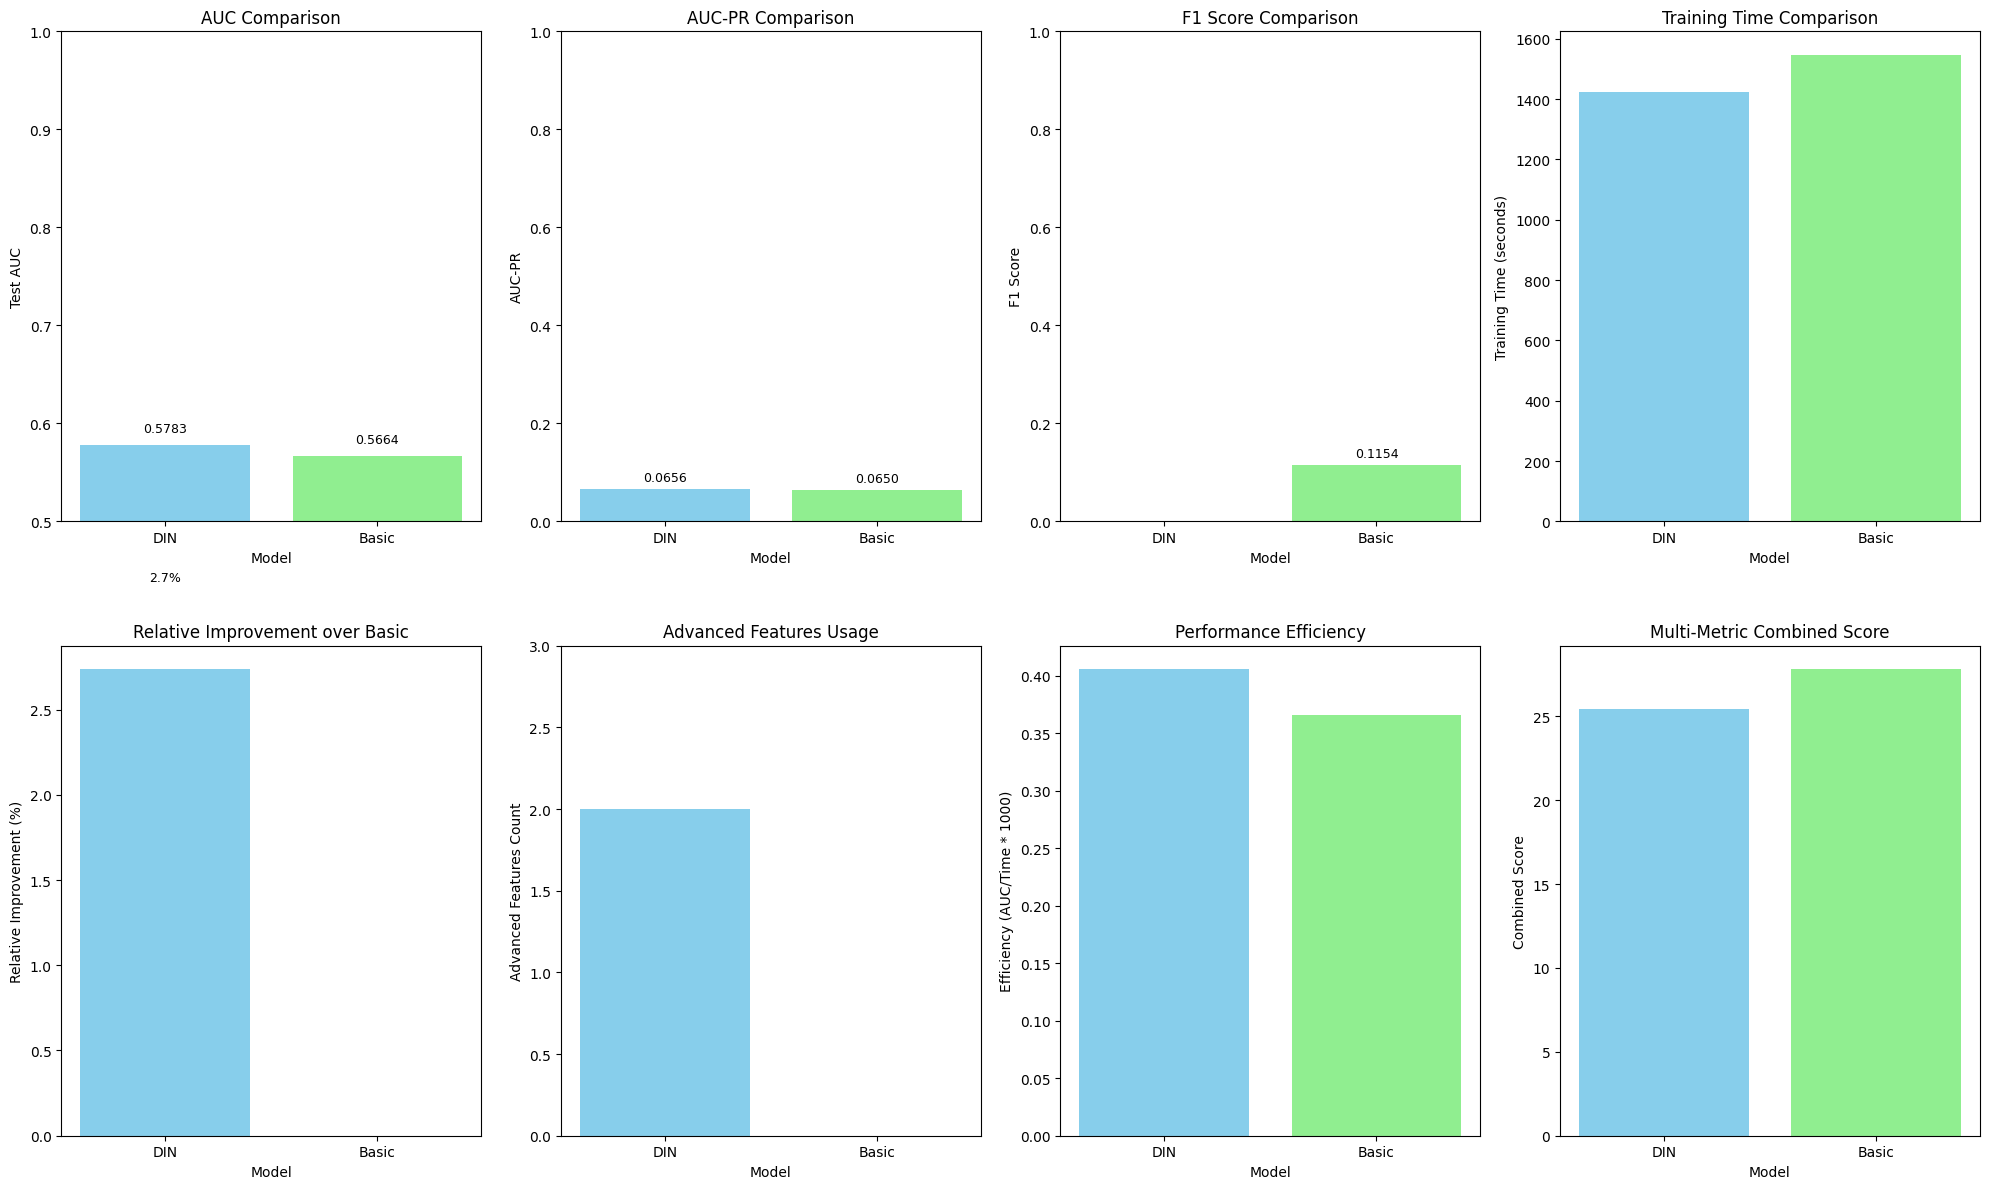


📊 Enhanced visualization saved to: /content/drive/MyDrive/TA/TAOBAO/models/enhanced_comprehensive_comparison.png

📈 SUMMARY STATISTICS:
  Average AUC: 0.5724
  Best AUC: 0.5783
  AUC Range: 0.0119
  Total Training Time: 2971.0 seconds
  Average Training Time: 1485.5 seconds
  Models with DICE Loss: ['DIN']


{'DIN': {'test_auc': np.float64(0.5783116898517753),
  'test_auc_roc': np.float64(0.5783116898517753),
  'test_auc_pr': np.float64(0.06559403448160535),
  'test_accuracy': 0.948596,
  'test_precision': 0.0,
  'test_recall': 0.0,
  'test_f1': 0.0,
  'test_specificity': np.float64(1.0),
  'test_log_loss': 0.5643111534076353,
  'train_auc': np.float64(0.9155838760420573),
  'train_auc_roc': np.float64(0.9155838760420573),
  'train_auc_pr': np.float64(0.7378319629529577),
  'optimal_threshold': 0.4,
  'optimal_f1': 0.09778507409876856,
  'training_time': 1424.0637872219086,
  'used_dice_loss': True,
  'loss_type': 'focal_dice',
  'positive_class_ratio': np.float64(0.05140425),
  'model_type': 'Enhanced DIN with focal_dice + Cyclical Features',
  'architecture': 'Multi-Head Attention + DICE Loss + Cyclical Features',
  'behavior_weighting': 'Enhanced with importance + context gating',
  'attention_mechanism': 'Multi-Head DIN Attention (4 heads)',
  'comprehensive_auc_roc': np.float64(0.5783

In [131]:
# 1. Load dan compare semua hasil
load_and_compare_results()

In [119]:
# 1. Advanced Analysis
advanced_analytics_dashboard()

# 2. System Performance Check
run_performance_diagnostics()

# 3. Complete Summary
training_summary_dashboard()

# 4. Architecture Review
show_model_architecture_summary()

# 5. Generate Final Report
generate_comprehensive_report()

# 6. Export for Further Analysis
export_results_to_csv()


🔬==========================================================🔬
              ADVANCED ANALYTICS DASHBOARD
🔬==========================================================🔬
✅ Using Multi-Head Attention with 4 heads

📈 PERFORMANCE ANALYSIS:

   🎯 DIN:
     • Test AUC: 0.5783
     • Train AUC: 0.9156
     • Overfitting Gap: 0.3373
     ⚠️  High overfitting detected
     • Optimal Threshold: 0.400

   🎯 Basic:
     • Test AUC: 0.5664
     • Train AUC: 0.9241
     • Overfitting Gap: 0.3576
     ⚠️  High overfitting detected
     • F1 Score: 0.1154
     • Optimal Threshold: 0.400

🎯 FEATURE IMPACT ESTIMATION:
   📊 Temporal Features: 2 active
     • time_segment: dimension 4
     • is_holiday: dimension 1
   📊 Demographic Features: 3 active
     • gender: dimension 3
     • age_level: dimension 7
     • shopping_level: dimension 4
   📊 Behavioral Features: 2 active
     • brand: dimension 5000
     • is_weekend: dimension 2

🔍 ADVANCED FEATURE ANALYSIS:
   🎯 DIN Advanced Features:
     • DICE Loss:

'/content/drive/MyDrive/TA/TAOBAO/models/enhanced_model_results.csv'

In [120]:
print(pd.Series(train_y).value_counts())

0    3794383
1     205617
Name: count, dtype: int64


In [121]:
# 1. Check detailed training status
def check_detailed_training_status():
    """Check detailed status of all models"""
    print("\n🔍 DETAILED TRAINING STATUS CHECK:")
    print("="*50)

    if os.path.exists(results_checkpoint):
        with open(results_checkpoint, 'rb') as f:
            all_results = pickle.load(f)

        print(f"📊 Models in checkpoint: {list(all_results.keys())}")

        for model_name, results in all_results.items():
            print(f"\n🎯 {model_name}:")
            if 'error' in results:
                print(f"   ❌ Error: {results['error']}")
            else:
                test_auc = results.get('test_auc', results.get('test_auc_roc', 'N/A'))
                training_time = results.get('training_time', 'N/A')
                print(f"   ✅ Test AUC: {test_auc}")
                print(f"   ⏱️  Time: {training_time}")

                # Check for cyclical features
                if 'used_cyclical_features' in results:
                    print(f"   🔄 Used cyclical: {results['used_cyclical_features']}")
    else:
        print("❌ No checkpoint found!")

check_detailed_training_status()


🔍 DETAILED TRAINING STATUS CHECK:
✅ Using Multi-Head Attention with 4 heads
📊 Models in checkpoint: ['DIN', 'Basic', 'DeepFM']

🎯 DIN:
   ✅ Test AUC: 0.5783116898517753
   ⏱️  Time: 1424.0637872219086
   🔄 Used cyclical: True

🎯 Basic:
   ✅ Test AUC: 0.566441776019243
   ⏱️  Time: 1546.9642009735107

🎯 DeepFM:
   ❌ Error: Missing data for input "is_weekend_fm". You passed a data dictionary with keys ['user', 'item', 'cat', 'price', 'hist_items', 'hist_cats', 'hist_behaviors', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'gender', 'age_level', 'shopping_level', 'time_segment', 'is_holiday', 'is_weekend', 'brand']. Expected the following keys: ['user', 'item', 'cat', 'price', 'hist_items', 'hist_cats', 'hist_behaviors', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'is_weekend_fm', 'time_segment_fm', 'is_holiday_fm', 'gender_fm', 'age_level_fm', 'shopping_level_fm', 'brand_fm', 'is_weekend_deep', 'time_segment_deep', 'is_holiday_deep', 'gender_deep', 'age_level_deep', 'shopping_level_d

In [122]:
# 2. Check if cyclical features exist in data
def verify_cyclical_features():
    """Verify cyclical features in training data"""
    print("\n🔍 VERIFYING CYCLICAL FEATURES:")
    print("="*40)

    print(f"📊 Available features in train_x:")
    for key in train_x.keys():
        print(f"   • {key}: {train_x[key].shape}")

    # Check for cyclical features specifically
    cyclical_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos']
    print(f"\n🔄 Cyclical Features Check:")

    cyclical_count = 0
    for feat in cyclical_features:
        if feat in train_x:
            print(f"   ✅ {feat}: FOUND")
            # Show sample values
            sample_vals = train_x[feat][:5].flatten()
            print(f"      Sample values: {sample_vals}")
            cyclical_count += 1
        else:
            print(f"   ❌ {feat}: MISSING")

    print(f"\n📈 Total cyclical features found: {cyclical_count}/4")

    # Check additional_dims
    if additional_dims:
        print(f"\n📊 Additional dimensions:")
        for feat, dim in additional_dims.items():
            feat_type = "Cyclical" if feat in cyclical_features else "Categorical"
            print(f"   • {feat}: {dim} ({feat_type})")

    return cyclical_count

cyclical_count = verify_cyclical_features()


🔍 VERIFYING CYCLICAL FEATURES:
📊 Available features in train_x:
   • user: (4000000,)
   • item: (4000000,)
   • cat: (4000000,)
   • price: (4000000,)
   • hist_items: (4000000, 40)
   • hist_cats: (4000000, 40)
   • hist_behaviors: (4000000, 40)
   • gender: (4000000,)
   • age_level: (4000000,)
   • shopping_level: (4000000,)
   • brand: (4000000, 1)
   • is_weekend: (4000000,)
   • hour_sin: (4000000,)
   • hour_cos: (4000000,)
   • day_sin: (4000000,)
   • day_cos: (4000000,)
   • time_segment: (4000000,)
   • is_holiday: (4000000,)

🔄 Cyclical Features Check:
   ✅ hour_sin: FOUND
      Sample values: [ 0.9659258   0.70710677  0.          0.25881904 -0.25881904]
   ✅ hour_cos: FOUND
      Sample values: [-0.25881904  0.70710677  1.         -0.9659258  -0.9659258 ]
   ✅ day_sin: FOUND
      Sample values: [ 0.43388373 -0.9749279  -0.9749279   0.43388373  0.43388373]
   ✅ day_cos: FOUND
      Sample values: [-0.90096885 -0.22252093 -0.22252093 -0.90096885 -0.90096885]

📈 Total cycl

In [123]:
# Check status checkpoint dengan detail
def diagnose_checkpoint_issue():
    """Diagnose checkpoint detection issue"""
    print("\n🔍 DIAGNOSING CHECKPOINT DETECTION ISSUE:")
    print("="*50)

    # Check if results checkpoint exists
    print(f"📁 Results checkpoint exists: {os.path.exists(results_checkpoint)}")
    print(f"📁 Checkpoint path: {results_checkpoint}")

    if os.path.exists(results_checkpoint):
        try:
            with open(results_checkpoint, 'rb') as f:
                results = pickle.load(f)

            print(f"✅ Checkpoint loaded successfully")
            print(f"📊 Models in checkpoint: {list(results.keys())}")

            for model_name, model_data in results.items():
                if 'error' in model_data:
                    print(f"   ❌ {model_name}: ERROR - {model_data['error']}")
                else:
                    # Try to get AUC safely
                    test_auc = model_data.get('test_auc_roc',
                              model_data.get('test_auc', 'Unknown'))
                    training_time = model_data.get('training_time', 'Unknown')
                    print(f"   ✅ {model_name}: AUC = {test_auc}, Time = {training_time}s")

                    # Check for specific keys
                    key_count = len([k for k in model_data.keys()
                                   if isinstance(model_data[k], (int, float, str, bool))])
                    print(f"      📊 Safe keys: {key_count}")

        except Exception as e:
            print(f"❌ Error loading checkpoint: {e}")
            print("💡 Checkpoint might be corrupted")
    else:
        print("❌ Results checkpoint does not exist!")
        print("💡 Training might not have saved properly")

    # Check individual model files
    print(f"\n📁 MODEL FILES CHECK:")
    model_files = ['basic_model.h5', 'deepfm_model_cyclical.h5', 'enhanced_din_cyclical_features.h5']

    for model_file in model_files:
        model_path = os.path.join(save_path, model_file)
        exists = os.path.exists(model_path)
        if exists:
            size_mb = os.path.getsize(model_path) / (1024 * 1024)
            print(f"   ✅ {model_file}: {size_mb:.1f} MB")
        else:
            print(f"   ❌ {model_file}: Not found")

# Run diagnosis
diagnose_checkpoint_issue()


🔍 DIAGNOSING CHECKPOINT DETECTION ISSUE:
📁 Results checkpoint exists: True
📁 Checkpoint path: /content/drive/MyDrive/TA/TAOBAO/checkpoints/results.pkl
✅ Using Multi-Head Attention with 4 heads
✅ Checkpoint loaded successfully
📊 Models in checkpoint: ['DIN', 'Basic', 'DeepFM']
   ✅ DIN: AUC = 0.5783116898517753, Time = 1424.0637872219086s
      📊 Safe keys: 23
   ✅ Basic: AUC = 0.566441776019243, Time = 1546.9642009735107s
      📊 Safe keys: 20
   ❌ DeepFM: ERROR - Missing data for input "is_weekend_fm". You passed a data dictionary with keys ['user', 'item', 'cat', 'price', 'hist_items', 'hist_cats', 'hist_behaviors', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'gender', 'age_level', 'shopping_level', 'time_segment', 'is_holiday', 'is_weekend', 'brand']. Expected the following keys: ['user', 'item', 'cat', 'price', 'hist_items', 'hist_cats', 'hist_behaviors', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'is_weekend_fm', 'time_segment_fm', 'is_holiday_fm', 'gender_fm', 'age_level_fm

In [124]:
# 1. DEBUG: Cek status sebenarnya dari semua model
def debug_all_model_status():
    """Debug status semua model secara detail"""
    print("🔍 DEBUGGING ALL MODEL STATUS:")
    print("="*50)

    # Check checkpoint file
    if os.path.exists(results_checkpoint):
        with open(results_checkpoint, 'rb') as f:
            results = pickle.load(f)

        print(f"📊 Models in checkpoint: {list(results.keys())}")

        for model_name, model_data in results.items():
            print(f"\n🎯 {model_name}:")
            if 'error' in model_data:
                print(f"   ❌ ERROR: {model_data['error']}")
            else:
                # Check basic metrics
                test_auc = model_data.get('test_auc_roc',
                          model_data.get('test_auc', 'N/A'))
                training_time = model_data.get('training_time', 'N/A')

                print(f"   ✅ Test AUC: {test_auc}")
                print(f"   ⏱️  Training Time: {training_time}")

                # Check cyclical features specifically
                used_cyclical = model_data.get('used_cyclical_features', 'Not found')
                print(f"   🔄 Used cyclical: {used_cyclical}")
    else:
        print("❌ No checkpoint found!")

    # Check model files
    print(f"\n📁 MODEL FILES:")
    model_files = {
        'Basic': 'basic_model.h5',
        'DeepFM': 'deepfm_model_cyclical.h5',
        'DIN': 'enhanced_din_cyclical_features.h5'
    }

    for model_name, filename in model_files.items():
        filepath = os.path.join(save_path, filename)
        if os.path.exists(filepath):
            size_mb = os.path.getsize(filepath) / (1024 * 1024)
            print(f"   ✅ {model_name}: {filename} ({size_mb:.1f} MB)")
        else:
            print(f"   ❌ {model_name}: {filename} - NOT FOUND")

# Run debug
debug_all_model_status()

🔍 DEBUGGING ALL MODEL STATUS:
✅ Using Multi-Head Attention with 4 heads
📊 Models in checkpoint: ['DIN', 'Basic', 'DeepFM']

🎯 DIN:
   ✅ Test AUC: 0.5783116898517753
   ⏱️  Training Time: 1424.0637872219086
   🔄 Used cyclical: True

🎯 Basic:
   ✅ Test AUC: 0.566441776019243
   ⏱️  Training Time: 1546.9642009735107
   🔄 Used cyclical: Not found

🎯 DeepFM:
   ❌ ERROR: Missing data for input "is_weekend_fm". You passed a data dictionary with keys ['user', 'item', 'cat', 'price', 'hist_items', 'hist_cats', 'hist_behaviors', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'gender', 'age_level', 'shopping_level', 'time_segment', 'is_holiday', 'is_weekend', 'brand']. Expected the following keys: ['user', 'item', 'cat', 'price', 'hist_items', 'hist_cats', 'hist_behaviors', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'is_weekend_fm', 'time_segment_fm', 'is_holiday_fm', 'gender_fm', 'age_level_fm', 'shopping_level_fm', 'brand_fm', 'is_weekend_deep', 'time_segment_deep', 'is_holiday_deep', 'gender

In [125]:
# 2. DEBUG: Cek cyclical features di data aktual
def debug_cyclical_features_in_data():
    """Debug cyclical features di training data"""
    print("\n🔍 DEBUGGING CYCLICAL FEATURES IN DATA:")
    print("="*40)

    cyclical_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos']

    print(f"📊 All features in train_x: {list(train_x.keys())}")

    cyclical_count = 0
    for feat in cyclical_features:
        if feat in train_x:
            print(f"   ✅ {feat}: FOUND")
            # Show sample values
            sample_vals = train_x[feat][:5].flatten()
            print(f"      Sample: {sample_vals}")
            cyclical_count += 1
        else:
            print(f"   ❌ {feat}: MISSING")

    print(f"\n📈 Total cyclical features: {cyclical_count}/4")

    # Check additional_dims
    if additional_dims:
        print(f"\n📊 Additional dimensions:")
        for feat, dim in additional_dims.items():
            feat_type = "🔄 Cyclical" if feat in cyclical_features else "📊 Categorical"
            print(f"   {feat_type} {feat}: {dim}")

    return cyclical_count

cyclical_found = debug_cyclical_features_in_data()


🔍 DEBUGGING CYCLICAL FEATURES IN DATA:
📊 All features in train_x: ['user', 'item', 'cat', 'price', 'hist_items', 'hist_cats', 'hist_behaviors', 'gender', 'age_level', 'shopping_level', 'brand', 'is_weekend', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'time_segment', 'is_holiday']
   ✅ hour_sin: FOUND
      Sample: [ 0.9659258   0.70710677  0.          0.25881904 -0.25881904]
   ✅ hour_cos: FOUND
      Sample: [-0.25881904  0.70710677  1.         -0.9659258  -0.9659258 ]
   ✅ day_sin: FOUND
      Sample: [ 0.43388373 -0.9749279  -0.9749279   0.43388373  0.43388373]
   ✅ day_cos: FOUND
      Sample: [-0.90096885 -0.22252093 -0.22252093 -0.90096885 -0.90096885]

📈 Total cyclical features: 4/4

📊 Additional dimensions:
   📊 Categorical is_weekend: 2
   📊 Categorical time_segment: 4
   📊 Categorical is_holiday: 1
   📊 Categorical gender: 3
   📊 Categorical age_level: 7
   📊 Categorical shopping_level: 4
   📊 Categorical brand: 5000


In [126]:
print(f"Keys in train_x: {list(train_x.keys())}")

Keys in train_x: ['user', 'item', 'cat', 'price', 'hist_items', 'hist_cats', 'hist_behaviors', 'gender', 'age_level', 'shopping_level', 'brand', 'is_weekend', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'time_segment', 'is_holiday']


In [127]:
def validate_cyclical_features(train_x):
    cyclical_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos']
    missing_features = [feat for feat in cyclical_features if feat not in train_x]
    if missing_features:
        print(f"❌ Missing cyclical features: {missing_features}")
    else:
        print("✅ All cyclical features are present")

validate_cyclical_features(train_x)

✅ All cyclical features are present
